# Project 2: AGODA - RECOMMENDATION SYSTEM

## Thành viên

| STT | Họ và Tên       |
| --- | --------------- |
| 1   | Trần Đình Hùng  |
| 2   | Phạm Ngọc Trọng |

## Tổng quan thực hiện

|                 | Mô tả                                                                                                                                          |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Mục tiêu**    | 1. Triển khai hệ thống Recommender System giúp đề xuất khách sạn / resort phù hợp tới người dùng.<br>2. Cung cấp insight dựa trên thông tin khách hàng cho Chủ khách sạn. |
| **Data**        | Data_Agoda_raw/<br>`hotel_info.csv`<br>`hotel_comments.csv`<br><br>files/<br>`emojicon.txt`<br>`english-vnmese.txt`<br>`teencode.txt`<br>`vietnamese-stopwords.txt`<br>`vietnamese-stopwords.txt`|
| **Phương pháp** | `1. Content-based filtering with gensim + TF-IDF`<br>`2. Content-based filtering with cosine-similarity`<br>`3. Collaborative filtering with ALS (spark)`<br>`4. Insight cho Chủ khách sạn`|

## 1. Library


In [1]:
# !pip install gensim pyvi

In [2]:
# =========================
# System & Utils
# =========================
import os
import re
import unicodedata
import warnings
from datetime import datetime

# =========================
# Data Processing
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Markdown

# =========================
# Profiling & Save Model
# =========================
from ydata_profiling import ProfileReport
import joblib  # save/load model .pkl

# =========================
# Statistics & NLP
# =========================
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from gensim import corpora, models, similarities
from pyvi.ViTokenizer import tokenize

# =========================
# Machine Learning (scikit-learn)
# =========================
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# =========================
# PySpark
# =========================
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

## 2. Config

In [3]:
# path
path = "D:\\Data_science\\07_DoAn\\DL07_K306_PhamNgocTrong_TranDinhHung\\Project_2\\"
in_path = "data_input\\"
out_path = "data_output\\"
images_path = "images\\"
code_path = "source_code\\"
model_path = "models\\"

# variables
dash_len = 30
n_rows = 3
dpi = 150 # dot per inch
figsize = (10, 5) # inches
random_state = 42

# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# config seaborn
sns.set_style("whitegrid")
sns.set_palette("Set2")

# ignore alert message
warnings.filterwarnings("ignore")

## 2. Functions


In [4]:
# fn_show
def fn_show(
    df: pd.DataFrame, n: int = 3, truncate: bool = False, print_schema: bool = False
):
    if print_schema:
        print(df.info())
        print(f"{'-' * dash_len}\n")
    print(f"dataframe: {df.shape[0]:,} rows x {df.shape[1]:,} cols")
    display(df.head(n))

# fn_show_spark
def fn_show_spark(df, n: int = 3, printSchema: bool = False, truncate: bool = False):
    print(f"dataframe: {df.count():,} rows x {len(df.columns)} cols\n")
    if printSchema:
        df.printSchema()
    df.show(n, truncate=truncate)

In [5]:
# fn_file_listing
def fn_file_listing(root_path: str):
    if not os.path.exists(root_path):
        print(f"Path does not exist: {root_path}")
        return []
    file_list = []
    for dirpath, _, filenames in os.walk(root_path):
        # indent = ' ' * 4 * (dirpath.replace(root_path, '').count(os.sep))
        # print(f"{indent}{os.path.basename(dirpath)}/")
        for f in filenames:
            # print(f"{indent}    {f}")
            rel_path = os.path.relpath(os.path.join(dirpath, f), root_path)
            file_list.append(rel_path)
    return file_list

In [6]:
# fn_read_csv
def fn_read_csv(folder_path, file_name, header=True, sep=","):
    try:
        return pd.read_csv(os.path.join(folder_path, file_name), header=0 if header else None, sep=sep)
    except:
        return pd.DataFrame()

In [7]:
# fn_save_csv
def fn_save_csv(
    df: pd.DataFrame,
    folder_path: str,
    file_name: str,
    header: bool = True,
    index: bool = False,
    sep: str = ",",
    encoding: str = "utf-8",
):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    try:
        df.to_csv(file_path, index=index, header=header, sep=sep, encoding=encoding)
        print(
            f"{os.path.basename(os.path.normpath(folder_path))}/\n"
            + "-" * dash_len
            + f"\n{file_name}"
        )
    except Exception as e:
        print(f"Error: {e}")

In [8]:
# # fn_column_listing
def fn_column_listing(df: pd.DataFrame) -> list:
    return list(df.columns)

In [9]:
# fn_rename
def fn_rename(df: pd.DataFrame) -> pd.DataFrame:
    import re, unicodedata
    def rm_accents(s): return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    df_temp = df.copy()
    df_temp.columns = [re.sub(r'\s+', '_', re.sub(r'[^a-z0-9\s]', ' ', rm_accents(str(c).lower()))).strip('_') for c in df.columns]
    return df_temp

In [10]:
# fn_Null_NaN_count
def fn_Null_NaN_count(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    total_rows = len(df)
    for col in df.columns:
        null_cnt = df[col].isnull().sum()
        null_pct = round((null_cnt / total_rows) * 100, 1) if total_rows > 0 else 0.0
        nan_cnt = df[col].apply(lambda x: isinstance(x, float) and pd.isna(x)).sum()
        nan_pct = round((nan_cnt / total_rows) * 100, 1) if total_rows > 0 else 0.0
        results.append(
            {
                "column": col,
                "Null_cnt": null_cnt,
                "Null_pct": null_pct,
                "NaN_cnt": nan_cnt,
                "NaN_pct": nan_pct,
            }
        )
    display(pd.DataFrame(results))

In [11]:
# fn_date_format

# datetime pattern:
# -   "%d-%m-%Y":             day-month-year (ví dụ: 25-12-2023)
# -   "%d/%m/%Y %H:%M:%S":    day/month/year hour:minute:second (ví dụ: 25/12/2023 14:30:00)
# -   "%m-%d-%Y":             month-day-year (ví dụ: 12-25-2023)
# -   "%H:%M:%S":             hour:minute:second (ví dụ: 14:30:00)


def fn_date_format(
    df: pd.DataFrame,
    cols: list,
    date_pattern: str = "%Y-%m-%d",
) -> pd.DataFrame:
    df2 = df.copy()
    for col in cols:
        df2[col] = pd.to_datetime(df2[col], format=date_pattern, errors="raise")
    return df2

In [12]:
# fn_save_image
def fn_save_image(
    path: str, image_name: str, dpi: int, bbox_inches: str = "tight"
):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, image_name)

    plt.savefig(save_path, dpi=dpi, bbox_inches=bbox_inches)
    print(
        f"{os.path.basename(os.path.normpath(path))}/\n"
        + "-" * dash_len
        + f"\n{image_name}"
    )

In [13]:
# fn_save_image_plotly
def fn_save_image_plotly(
    fig, path: str, image_name: str, figsize: tuple, scale: int = 1
):
    fig.write_image(f"{path}{image_name}", scale=scale, width=figsize[0], height=figsize[1])
    print(
        f"{os.path.basename(os.path.normpath(path))}/\n"
        + "-" * dash_len
        + f"\n{image_name}"
    )

In [14]:
# fn_chart_missingvalue_matrix
def fn_chart_missingvalue_matrix(df, title, figsize, color, dpi:int):
    import missingno as msno
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi/2)
    msno.matrix(df, fontsize=10, sparkline=False, color=color, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    fn_save_image(path = path + images_path, image_name = title.replace(" ", "_"), dpi=dpi)
    plt.show()

In [15]:
# fn_chart_corr
def fn_chart_corr(df, figsize, dpi, title="Correlation Heatmap", cols=None):
    d = df[cols] if cols else df.select_dtypes("number")
    c = d.corr()
    plt.figure(figsize=figsize, dpi=dpi)
    mask = np.triu(np.ones_like(c, dtype=bool), k=1)
    ax = sns.heatmap(
        c,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        square=True,
        annot_kws={"size": 6},
    )
    plt.title(title, fontsize=12, fontweight="bold")
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False)
    plt.tight_layout()
    fn_save_image(path=path + images_path, image_name=title.replace(" ", "_"), dpi=dpi)
    plt.show()

In [16]:
# fn_save_model_joblib
def fn_save_model_joblib(model, folder_path:str, model_name:str):
    os.makedirs(folder_path, exist_ok=True)
    joblib.dump(model, os.path.join(folder_path, model_name), compress=3, protocol=4)
    print(
    f"{os.path.basename(os.path.normpath(folder_path))}/\n"
    + "-" * dash_len
    + f"\n{model_name}"
)

In [17]:
# fn_load_model_joblib
def fn_load_model_joblib(folder_path: str, model_name: str):
    # import os, joblib
    path = os.path.join(folder_path, model_name)
    # if not os.path.exists(path):
    #     raise FileNotFoundError(f"Model not found: {path}")
    return joblib.load(path)

In [18]:
def fn_gensim_save_sparsematrixsimilarity(
    index_matrix, folder_path: str, file_name: str
):
    file_path = folder_path + file_name
    index_matrix.save(file_path)
    print(
        f"{os.path.basename(os.path.normpath(folder_path))}/\n"
        + "-" * dash_len
        + f"\n{file_name}"
    )


def fn_gensim_load_sparsematrixsimilarity(folder_path: str, file_name: str):
    from gensim.similarities import SparseMatrixSimilarity

    file_path = folder_path + file_name
    index_matrix = SparseMatrixSimilarity.load(file_path)
    # print(f"SparseMatrixSimilarity object loaded from: {file_path}")
    return index_matrix

In [19]:
# save matrix
def fn_cosine_sim_save(cosine_sim, folder_path, file_name):
    # os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, file_name)
    np.save(file_path, cosine_sim)
    print(
        f"{os.path.basename(os.path.normpath(folder_path))}/\n"
        + "-" * dash_len
        + f"\n{file_name}"
    )

# load matrix
def fn_cosine_sim_load(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    return np.load(file_path)

In [20]:
# fn_extract_nums
def fn_extract_nums(s: str) -> list:
    import re
    nums = re.findall(r"\d+(?:[.,]\d+)*", s)
    res = []
    for n in nums:
        try:
            if "," in n and "." in n:
                res.append(float(n.replace(",", "")))
            elif "," in n:
                res.append(int(n.replace(",", "")))
            elif "." in n:
                res.append(float(n))
            else:
                res.append(int(n))
        except: continue
    return res

In [21]:
# fn_date()
# convert [30, 7, 2023] to '2023-07-30'
def fn_date(lst):
    import datetime
    try:
        return datetime.datetime(int(lst[2]), int(lst[1]), int(lst[0]))
    except:
        return None

In [22]:
# fn_astype_float
def fn_astype_float(df: pd.DataFrame, col:str) -> pd.DataFrame:
    df_temp = df.copy()
    df_temp[col] = df_temp[col].astype(str).str.replace(',', '.', regex=False).replace('nan', np.nan).astype(float)
    return df_temp

In [23]:
# fn_read_dict
def fn_read_dict(path):
    d = {}
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            if '\t' in line:
                eng, vie = line.strip().split('\t', 1)
                d[eng.strip()] = vie.strip()
    return d

In [24]:
# fn_read_txt
def fn_read_txt(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.rstrip('\n') for line in f]

In [25]:
def fn_clean_tokens(
    text,
    dict_list=None,
    stopword=None,
    wrongword=None,
    remove_number=False,
    remove_punctuation=True,
    remove_vie_tone=False,
    lower=True,
):
    import re, unicodedata, string
    import numpy as np
    def remove_accents(text):
        text = unicodedata.normalize('NFD', text)
        text = text.encode('ascii', 'ignore').decode("utf-8")
        return str(text)
    punctuations = set(string.punctuation)
    def _process_token(tok):
        if dict_list:
            for d in dict_list:
                if tok in d:
                    tok = d[tok]
        if remove_number and re.fullmatch(r"[0-9]+(\.[0-9]+)?", tok):
            return None
        if remove_punctuation:
            tok = ''.join([c for c in tok if c not in punctuations])
            if not tok.strip():
                return None
        if lower:
            tok = tok.lower()
        if wrongword and tok in wrongword:
            return None
        if remove_vie_tone:
            tok = remove_accents(tok)
        if tok.strip():
            return tok
        return None
    def is_empty_or_nan(x):
        if x is None:
            return True
        if isinstance(x, float) and np.isnan(x):
            return True
        if isinstance(x, str) and str(x).strip() == "":
            return True
        return False
    if is_empty_or_nan(text) or (isinstance(text, list) and all(is_empty_or_nan(t) for t in text)):
        return [] if isinstance(text, list) else []
    if isinstance(text, list):
        texts = text
    else:
        texts = [text]
    results = []
    for t in texts:
        if is_empty_or_nan(t):
            results.append([])
            continue
        tokens = str(t).split()
        cleaned = []
        for tok in tokens:
            res = _process_token(tok)
            if res is not None:
                cleaned.append(res)
        # remove stopword ở bước cuối cùng
        if stopword:
            cleaned = [tok for tok in cleaned if tok not in stopword]
        results.append(cleaned)
    if isinstance(text, list):
        return results
    else:
        return results[0]

In [26]:
# fn_safe_get_row
# safe_get_row : lấy row hotel (an toàn khi missing)
def fn_safe_get_row(df, key_col, key_val):
    """Trả về Series"""
    sub = df[df[key_col] == key_val]
    return sub.iloc[0] if len(sub) else None

In [27]:
# fn_mean_ratings
# mean_ratings : mean hệ thống cho các thuộc tính rating
def fn_mean_ratings(df_info, rating_cols):
    return df_info[rating_cols].mean(skipna=True)

In [28]:
# fn_get_hotel_overview
# Hàm trả về dict tóm tắt: tên, địa chỉ, star (hotel_rank), avg score (total_score hoặc trung bình các rating nếu missing).
def fn_get_hotel_overview(df_info, hotel_id):
    r = fn_safe_get_row(df_info, "hotel_id", hotel_id)
    if r is None:
        return None
    # nếu total_score missing, tính trung bình các rating có trong hàng
    rating_cols = [
        "total_score",
        "location",
        "cleanliness",
        "service",
        "facilities",
        "value_for_money",
        "comfort_and_room_quality",
    ]
    available = [c for c in rating_cols if c in r.index]
    total_score = r["total_score"] if pd.notna(r.get("total_score", np.nan)) else np.nan
    if pd.isna(total_score) and available:
        vals = [r[c] for c in available if pd.notna(r[c])]
        # đã đánh giá thực nghiệm trên các hotel có đủ thông tin, cột total_score luôn = avg(các cột score thành phần)
        total_score = np.mean(vals) if vals else np.nan
    out = {
        "hotel_id": r["hotel_id"],
        "hotel_name": r.get("hotel_name", ""),
        "hotel_address": r.get("hotel_address", ""),
        "hotel_rank": r.get("hotel_rank", np.nan),
        "avg_score": total_score,
        # "comments_count": r.get("comments_count", 0),
    }
    return out

In [29]:
# fn_chart_score_distribution
def fn_chart_score_distribution(
    df,
    score_col,
    hotel_id_col,
    selected_hotel_id,
    color_dict={
        "hist": "#4C72B0",
        "kde": "#55A868",
        "highlight_bin": "#FFB000",
        "edge": "black"
    },
    figsize=(10, 6),
    bins_time: int = 1,
    dpi=dpi, image_name:str=''
):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.patches import Patch

    plt.figure(figsize=figsize)
    scores = df[score_col].dropna().values
    min_score, max_score = np.nanmin(scores), np.nanmax(scores)
    n_bins = max(int((max_score - min_score) * bins_time), 1)
    selected_row = df[df[hotel_id_col] == selected_hotel_id]
    selected_score = selected_row[score_col].values[0] if not selected_row.empty else None
    selected_hotel_name = selected_row["hotel_name"].values[0] if ("hotel_name" in df.columns and not selected_row.empty) else "Selected Hotel"
    bins = np.linspace(min_score, max_score, n_bins + 1)
    hist, bin_edges = np.histogram(scores, bins=bins)
    bin_idx = np.digitize(selected_score, bin_edges) - 1 if selected_score is not None else None
    if bin_idx == len(hist):
        bin_idx -= 1
    bar_colors = [color_dict["hist"]] * len(hist)
    if bin_idx is not None and 0 <= bin_idx < len(hist):
        bar_colors[bin_idx] = color_dict["highlight_bin"]
    for i in range(len(hist)):
        plt.bar(
            (bin_edges[i] + bin_edges[i+1]) / 2,
            hist[i],
            width=bin_edges[i+1] - bin_edges[i],
            color=bar_colors[i],
            edgecolor=color_dict["edge"],
            alpha=0.85,
            align="center"
        )
    ax = plt.gca()
    kde = sns.kdeplot(
        scores,
        bw_adjust=1,
        color=color_dict["kde"],
        linewidth=2,
        fill=False,
        ax=ax,
        label="KDE"
    )
    kde_y = kde.get_lines()[-1].get_ydata()
    if len(kde_y) > 0 and hist.sum() > 0 and kde_y.max() > 0:
        scale = hist.max() / kde_y.max()
        kde.get_lines()[-1].set_ydata(kde_y * scale)
    legend_handles = [
        Patch(facecolor=color_dict["hist"], edgecolor=color_dict["edge"], label=f"Other Hotels - {score_col}: {scores.mean():.1f}"),
        Patch(facecolor=color_dict["highlight_bin"], edgecolor=color_dict["edge"], label=f"{selected_hotel_name}  - {score_col}: {str(selected_score)}")
    ]
    plt.legend(handles=legend_handles, fontsize=10, loc="upper left", bbox_to_anchor=(0, 1), borderaxespad=1.0)
    plt.title(f"Distribution of Hotel '{score_col}'", fontsize=16)
    plt.xlabel(score_col, fontsize=13)
    plt.ylabel("Number of Hotels", fontsize=13)

    fn_save_image(path=path+images_path, image_name = image_name, dpi = dpi)
    plt.tight_layout()
    plt.show()

In [30]:
# fn_rating_diffs
def fn_rating_diffs(df, hotel_id_col, selected_hotel_id, rating_cols):
    means = df[rating_cols].mean(skipna=True)
    row = df[df[hotel_id_col] == selected_hotel_id]
    if row.empty:
        return None
    row = row.iloc[0]
    result = []
    for c in rating_cols:
        v = row[c]
        m = means[c]
        diff = v - m if pd.notna(v) and pd.notna(m) else np.nan
        if pd.notna(v):
            rank = df[c].rank(ascending=False, pct=True)[df[df[hotel_id_col] == selected_hotel_id].index[0]] * 100
            top_pct = round(rank, 1)
        else:
            top_pct = np.nan
        result.append({
            "attr": c,
            "selected_hotel": round(v, 1) if pd.notna(v) else np.nan,
            "all_mean": round(m, 1) if pd.notna(m) else np.nan,
            "diff": round(diff, 1) if pd.notna(diff) else np.nan,
            "top_percent": top_pct,
        })
    df_result = pd.DataFrame(result).sort_values("diff", ascending=False).reset_index(drop=True)
    return df_result

In [31]:
# fn_chart_radar
def fn_chart_radar(
    df, 
    selected_hotel_name='', 
    image_name='', 
    figsize=figsize, 
    dpi=dpi, 
    color_dict={
            "all_mean": "#4C72B0",
            "kde": "#55A868",
            "highlight_bin": "#FFB000",
            "edge": "black"
        }
):
    attributes = df['attr'].tolist()
    values = df['selected_hotel'].tolist() + [df['selected_hotel'].tolist()[0]]
    means = df['all_mean'].tolist() + [df['all_mean'].tolist()[0]]
    angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist() + [0]
    fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(polar=True), dpi=dpi)
    ax.plot(angles, values, label=selected_hotel_name, linewidth=2, color=color_dict["highlight_bin"])
    ax.fill(angles, values, alpha=0.20, color=color_dict["highlight_bin"])
    ax.plot(angles, means, label="Other Hotels", linewidth=2, linestyle='dashed', color=color_dict["all_mean"])
    ax.fill(angles, means, alpha=0.1, color=color_dict["all_mean"])
    ax.set_thetagrids(np.degrees(angles[:-1]), attributes, fontsize=10)
    title = "Strengths & Weaknesses"
    ax.set_title(label=title, fontsize=16, fontweight='bold', pad=16)
    ax.set_ylim(0, 10)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

    fn_save_image(path=path+images_path, image_name = image_name, dpi = dpi)    
    plt.tight_layout()
    plt.show()

In [32]:
# fn_score_classify
def fn_score_classify(score, score_classify_dict):
    if pd.isna(score):
        return None
    if score >= score_classify_dict["Strength"]:
        return "Strength"
    elif score >= score_classify_dict["Neutral"]:
        return "Neutral"
    else:
        return "Weakness"

In [33]:
def fn_chart_customer_analysis(df, chart_cols_dict, color, figsize, dpi, image_name, selected_hotel_name=''):
    def fn_bar_chart(ax, df, cat_col, color, title):
        data = df[cat_col].value_counts().sort_values(ascending=False)
        sns.barplot(x=data.values, y=data.index, ax=ax, color=color)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Count")
        ax.set_ylabel(cat_col)

    def fn_line_timeseries_chart(ax, df, time_col, color, title):
        data = df[time_col].value_counts().sort_index()
        try:
            x = pd.to_datetime(data.index)
        except Exception:
            x = data.index
        sns.lineplot(x=x, y=data.values, marker="o", ax=ax, color=color)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel(time_col)
        ax.set_ylabel("Count")
        if time_col in ['stay_month', 'review_month']:
            for label in ax.get_xticklabels():
                label.set_rotation(45)

    ncols = 2
    n_items = sum(len(cols) for cols in chart_cols_dict.values())
    nrows = int(np.ceil(n_items / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)
    axes = np.array(axes).reshape(nrows, ncols)
    idx = 0
    for fn_name, cols in chart_cols_dict.items():
        for col in cols:
            r, c = divmod(idx, ncols)
            ax = axes[r, c]
            if fn_name == 'fn_bar_chart':
                nlarge_items = df[col].nunique()
                if nlarge_items < 10:
                    fn_bar_chart(ax, df, col, color, f"'{col}' distribution")
                else:
                    top10_idx = df[col].value_counts().head(10).index
                    df_top10 = df[df[col].isin(top10_idx)]
                    fn_bar_chart(ax, df_top10, col, color, f"Top 10 '{col}'")
            elif fn_name == 'fn_line_timeseries_chart':
                fn_line_timeseries_chart(ax, df, col, color, f"'{col}' distribution")
            idx += 1
    for i in range(idx, nrows * ncols):
        r, c = divmod(i, ncols)
        axes[r, c].axis('off')
    fig.suptitle(t=f"Customer Analysis: {selected_hotel_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    fn_save_image(path=path + images_path, image_name=image_name, dpi=dpi)
    plt.show()

In [34]:
# fn_score_stats
def fn_score_stats(df, score_col: str = "score", score_level_col: str = "score_level"):
    stats = (
        df.groupby(score_level_col)[score_col]
        .agg(
            count="count",
            mean="mean",
            min="min",
            q1=lambda x: x.quantile(0.25),
            q2=lambda x: x.quantile(0.5),
            q3=lambda x: x.quantile(0.75),
            max="max",
        )
        .sort_values("mean", ascending=False)
        .reset_index()
    )
    total_count = stats["count"].sum()
    stats["count_pct"] = (stats["count"] / total_count * 100).round(1)
    return stats[["score_level", "count", "count_pct", "mean", "min", "q1", "q2", "q3", "max"]]

In [35]:
# fn_topwords
def fn_topwords(df, col='body_new_clean', topN=20, filter=None):
    # import pandas as pd
    from collections import Counter

    if filter in ['pos', 'nev']:
        df_filtered = df[df['classify'] == filter]
    else:
        df_filtered = df

    all_tokens = []
    for tokens in df_filtered[col]:
        if isinstance(tokens, list):
            all_tokens.extend(tokens)
    counter = Counter(all_tokens)
    top_words = counter.most_common(topN)
    df_top = pd.DataFrame(top_words, columns=['word', 'count'])
    total = df_top['count'].sum()
    df_top['pct'] = (df_top['count'] / total * 100).round(1)
    return df_top


In [36]:
# fn_chart_wordcloud
def fn_chart_wordcloud(df, title=None, figsize=None, dpi=None, image_name=None):
    from wordcloud import WordCloud
    # import matplotlib.pyplot as plt
    # import seaborn as sns
    # import pandas as pd

    # sns.set_style("whitegrid")
    # sns.set_palette("deep")

    freq_dict = pd.Series(df['count'].values, index=df['word']).to_dict()
    wc = WordCloud(width=1000, height=500, background_color='white',
                   colormap='viridis', prefer_horizontal=1.0,
                   font_path=None, max_words=len(df))
    wc.generate_from_frequencies(freq_dict)

    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if not title:
        title = "Top Keywords WordCloud"
    plt.title(title, fontsize=20, fontweight='bold', color='#222222', loc='center', pad=20)
    plt.tight_layout(pad=2.0)
    fn_save_image(path = path + images_path, image_name = image_name, dpi=dpi)
    plt.show()

## 3. Read input data


In [37]:
# check input folder
print(f"{in_path}\n" + "-" * dash_len)
for f in fn_file_listing(path + in_path):
    print(f)

data_input\
------------------------------
Data_Agoda_raw\hotel_comments.csv
Data_Agoda_raw\hotel_info.csv
Data_Agoda_raw\readme_v2.docx
files\emojicon.txt
files\english-vnmese.txt
files\teencode.txt
files\vietnamese-stopwords.txt
files\wrong-word.txt


In [38]:
# read raw data
df_hotel_comments_raw = fn_read_csv(folder_path=path + in_path, file_name="Data_Agoda_raw\hotel_comments.csv", header=True, sep=",")
df_hotel_info_raw = fn_read_csv(folder_path=path + in_path, file_name="Data_Agoda_raw\hotel_info.csv", header=True, sep=",")

In [39]:
fn_show(df=df_hotel_comments_raw, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB
None
------------------------------

dataframe: 80,314 rows x 13 cols


num Hotel ID Reviewer ID Reviewer Name Nationality   Group Name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                Room Type                     Stay Details  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  Đã ở 3 đêm vào Tháng 7 năm 2023   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  Đã ở 1 đêm vào Tháng 9 năm 2022   
2            Deluxe Hướng biển giường đôi  Đã ở 1 đêm vào Tháng 6 năm 2024   

  Score        Score Level                   Title  \
0  10,0  Trên cả tuyệt vời             Cao nhất‼︎”   
1  10,0  Trên cả tuyệt vời                Tháng 8”   
2   9,2  Trên cả tuyệt vời  Du lịch tại Nha Trang”   

                                                Body  \
0  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Lần này đến với Nha Trang, tôi book phòng tại ...   

                       Review Date  
0  Đã nhận xét vào 30 tháng 7 2023  
1  Đã nhận xét vào 05 tháng 9 2022  
2  Đã nhận xét vào 25 tháng 6 2024

In [40]:
fn_show(df=df_hotel_info_raw, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

num Hotel_ID                                         Hotel_Name  \
0    1      1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Khách sạn Aaron (Aaron Hotel)   

       Hotel_Rank                                      Hotel_Address  \
0    5 sao trên 5          60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam   
1    4 sao trên 5  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...   
2  3.5 sao trên 5  6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...   

  Total_Score Location Cleanliness Service Facilities Value_for_money  \
0         8,8      9,4         8,9     8,9        8,7             8,7   
1         7,7      7,8         7,6     8,1        7,5             8,1   
2         8,5      8,9         8,7     8,8        8,1             8,5   

  Comfort_and_room_quality  comments_count  \
0                      8,3            1269   
1                      NaN             337   
2                      NaN             300   

                                   Hotel_Description  
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...  
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...  
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...

## 4. EDA


### 4.1 Renamed Cols


In [41]:
df_hotel_info_raw = fn_rename(df=df_hotel_info_raw)
df_hotel_comments_raw = fn_rename(df=df_hotel_comments_raw)

fn_show(df=df_hotel_info_raw, n=n_rows)
fn_show(df=df_hotel_comments_raw, n=n_rows)

dataframe: 740 rows x 14 cols


num hotel_id                                         hotel_name  \
0    1      1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Khách sạn Aaron (Aaron Hotel)   

       hotel_rank                                      hotel_address  \
0    5 sao trên 5          60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam   
1    4 sao trên 5  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...   
2  3.5 sao trên 5  6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...   

  total_score location cleanliness service facilities value_for_money  \
0         8,8      9,4         8,9     8,9        8,7             8,7   
1         7,7      7,8         7,6     8,1        7,5             8,1   
2         8,5      8,9         8,7     8,8        8,1             8,5   

  comfort_and_room_quality  comments_count  \
0                      8,3            1269   
1                      NaN             337   
2                      NaN             300   

                                   hotel_description  
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...  
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...  
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...

dataframe: 80,314 rows x 13 cols


num hotel_id reviewer_id reviewer_name nationality   group_name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                room_type                     stay_details  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  Đã ở 3 đêm vào Tháng 7 năm 2023   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  Đã ở 1 đêm vào Tháng 9 năm 2022   
2            Deluxe Hướng biển giường đôi  Đã ở 1 đêm vào Tháng 6 năm 2024   

  score        score_level                   title  \
0  10,0  Trên cả tuyệt vời             Cao nhất‼︎”   
1  10,0  Trên cả tuyệt vời                Tháng 8”   
2   9,2  Trên cả tuyệt vời  Du lịch tại Nha Trang”   

                                                body  \
0  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Lần này đến với Nha Trang, tôi book phòng tại ...   

                       review_date  
0  Đã nhận xét vào 30 tháng 7 2023  
1  Đã nhận xét vào 05 tháng 9 2022  
2  Đã nhận xét vào 25 tháng 6 2024

### 4.2 Extract info

In [42]:
# extract review date
df_hotel_comments_raw['review_date_2'] = df_hotel_comments_raw['review_date'].apply(fn_extract_nums).apply(fn_date)
# extract stay_details : stay_month & stay_nights
df_hotel_comments_raw['stay_nights'] = df_hotel_comments_raw['stay_details'].apply(lambda x: fn_extract_nums(x)[0]).astype(int)
df_hotel_comments_raw['stay_month'] = df_hotel_comments_raw['stay_details'].apply(lambda x: [1] + fn_extract_nums(x)[1:3]).apply(fn_date)

# drop stay_details, review_date cols
df_hotel_comments = df_hotel_comments_raw.drop(columns=['stay_details', 'review_date']).rename(columns={'review_date_2': 'review_date'})

fn_show(df=df_hotel_comments, n=n_rows)

dataframe: 80,314 rows x 14 cols


num hotel_id reviewer_id reviewer_name nationality   group_name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                room_type score        score_level  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  10,0  Trên cả tuyệt vời   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển  10,0  Trên cả tuyệt vời   
2            Deluxe Hướng biển giường đôi   9,2  Trên cả tuyệt vời   

                    title                                               body  \
0             Cao nhất‼︎”  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1                Tháng 8”  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Du lịch tại Nha Trang”  Lần này đến với Nha Trang, tôi book phòng tại ...   

  review_date  stay_nights stay_month  
0  2023-07-30            3 2023-07-01  
1  2022-09-05            1 2022-09-01  
2  2024-06-25            1 2024-06-01

In [43]:
# extract hotel_rank
df_hotel_info_raw['hotel_rank_2'] = df_hotel_info_raw['hotel_rank'].apply(
    lambda x: fn_extract_nums(x)[0] if fn_extract_nums(x) and len(fn_extract_nums(x)) > 0 else np.nan
)

# drop hotel_rank col
df_hotel_info = df_hotel_info_raw.drop(columns=['hotel_rank']).rename(columns={'hotel_rank_2': 'hotel_rank'})
fn_show(df=df_hotel_info, n=n_rows)

dataframe: 740 rows x 14 cols


num hotel_id                                         hotel_name  \
0    1      1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Khách sạn Aaron (Aaron Hotel)   

                                       hotel_address total_score location  \
0          60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam         8,8      9,4   
1  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...         7,7      7,8   
2  6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...         8,5      8,9   

  cleanliness service facilities value_for_money comfort_and_room_quality  \
0         8,9     8,9        8,7             8,7                      8,3   
1         7,6     8,1        7,5             8,1                      NaN   
2         8,7     8,8        8,1             8,5                      NaN   

   comments_count                                  hotel_description  \
0            1269  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...   
1             337  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
2             300  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...   

   hotel_rank  
0         5.0  
1         4.0  
2         3.5

### 4.3 Replace values

In [44]:
# những cột cần kiểm tra "No infomartion" xuất hiện ở các cột score
lst_info_score = ['total_score', 'location', 'cleanliness', 'service', 'facilities', 'value_for_money', 'comfort_and_room_quality', 'hotel_rank']
lst_comments_score = ['score']

In [45]:
# check "No information" xuất hiện ở các cột score
for c in lst_info_score:
    print(f"{c}:\n{sorted(df_hotel_info[c].astype(str).unique(), reverse=True)}\n")

# check No information" xuất hiện ở các cột score
for c in lst_comments_score:
    print(f"{c}:\n{sorted(df_hotel_comments[c].astype(str).unique(), reverse=True)}\n")

total_score:
['No information', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,3', '6,2', '6,1', '5,8', '5,6', '5,3', '5,2', '5,0', '4,8', '4,4', '4,3', '3,5', '2,8', '2,6', '2,5', '2,0', '10']

location:
['nan', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,5', '5,3', '5,2', '5,0', '4,7', '4,0', '3,0', '2,0', '10,0']

cleanliness:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,

In [46]:
# replace "No information" bằng NaN nếu có
for c in lst_info_score:
    df_hotel_info[c] = df_hotel_info[c].replace('No information', np.nan)

for c in lst_comments_score:
    df_hotel_comments[c] = df_hotel_comments[c].replace('No information', np.nan)    

# after replace
for c in lst_info_score:
    print(f"{c}:\n{sorted(df_hotel_info[c].astype(str).unique(), reverse=True)}\n")

for c in lst_comments_score:
    print(f"{c}:\n{sorted(df_hotel_comments[c].astype(str).unique(), reverse=True)}\n")

total_score:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,3', '6,2', '6,1', '5,8', '5,6', '5,3', '5,2', '5,0', '4,8', '4,4', '4,3', '3,5', '2,8', '2,6', '2,5', '2,0', '10']

location:
['nan', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,5', '5,3', '5,2', '5,0', '4,7', '4,0', '3,0', '2,0', '10,0']

cleanliness:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,9', '5,8', 

In [47]:
#  cột hotel_description có lỗi #NAME?
df_hotel_info['hotel_description'] = df_hotel_info['hotel_description'].replace('#NAME?', np.nan)

In [48]:
# remove các dấu xuống dòng
for col in df_hotel_info.select_dtypes(include=['object']).columns:
    df_hotel_info[col] = df_hotel_info[col].apply(lambda x: str(x).replace('\n', ' ').strip() if pd.notnull(x) else x)

for col in df_hotel_comments.select_dtypes(include=['object']).columns:
    df_hotel_comments[col] = df_hotel_comments[col].apply(lambda x: str(x).replace('\n', ' ').strip() if pd.notnull(x) else x)    

### 4.4 Astype

In [49]:
# Đổi kiểu dữ liệu các cột score về float
for c in lst_info_score:
    df_hotel_info = fn_astype_float(df=df_hotel_info, col=c)

for c in lst_comments_score:
    df_hotel_comments = fn_astype_float(df=df_hotel_comments, col=c)    

In [50]:
# data sau chuyển kiểu dữ liệu
fn_show(df=df_hotel_info, n=n_rows, print_schema=True)
fn_show(df=df_hotel_comments, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   hotel_id                  740 non-null    object 
 2   hotel_name                740 non-null    object 
 3   hotel_address             740 non-null    object 
 4   total_score               414 non-null    float64
 5   location                  413 non-null    float64
 6   cleanliness               412 non-null    float64
 7   service                   373 non-null    float64
 8   facilities                370 non-null    float64
 9   value_for_money           410 non-null    float64
 10  comfort_and_room_quality  51 non-null     float64
 11  comments_count            740 non-null    int64  
 12  hotel_description         735 non-null    object 
 13  hotel_rank                267 non-null    float64
dtypes: float64

num hotel_id                                         hotel_name  \
0    1      1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Khách sạn Aaron (Aaron Hotel)   

                                       hotel_address  total_score  location  \
0          60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam          8.8       9.4   
1  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...          7.7       7.8   
2  6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...          8.5       8.9   

   cleanliness  service  facilities  value_for_money  \
0          8.9      8.9         8.7              8.7   
1          7.6      8.1         7.5              8.1   
2          8.7      8.8         8.1              8.5   

   comfort_and_room_quality  comments_count  \
0                       8.3            1269   
1                       NaN             337   
2                       NaN             300   

                                   hotel_description  hotel_rank  
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...         5.0  
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...         4.0  
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...         3.5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   num            80314 non-null  int64         
 1   hotel_id       80314 non-null  object        
 2   reviewer_id    80314 non-null  object        
 3   reviewer_name  80228 non-null  object        
 4   nationality    80314 non-null  object        
 5   group_name     80314 non-null  object        
 6   room_type      80314 non-null  object        
 7   score          80314 non-null  float64       
 8   score_level    80314 non-null  object        
 9   title          80314 non-null  object        
 10  body           80272 non-null  object        
 11  review_date    80314 non-null  datetime64[ns]
 12  stay_nights    80314 non-null  int32         
 13  stay_month     80314 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(9)
memory

num hotel_id reviewer_id reviewer_name nationality   group_name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                room_type  score        score_level  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
2            Deluxe Hướng biển giường đôi    9.2  Trên cả tuyệt vời   

                    title                                               body  \
0             Cao nhất‼︎”  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1                Tháng 8”  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Du lịch tại Nha Trang”  Lần này đến với Nha Trang, tôi book phòng tại ...   

  review_date  stay_nights stay_month  
0  2023-07-30            3 2023-07-01  
1  2022-09-05            1 2022-09-01  
2  2024-06-25            1 2024-06-01

### 4.5 Data profiling

In [51]:
# extract hotel_rank
ProfileReport(
    df_hotel_info,
    title="df_hotel_info Data Profiling Report",
    explorative=True,
).to_file(path + out_path + "df_hotel_info_profile.html")

ProfileReport(
    df_hotel_comments,
    title="df_hotel_comments Data Profiling Report",
    explorative=True,
).to_file(path + out_path + "df_hotel_comments_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:01<00:00, 11.10it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:03<00:00,  4.19it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
# List profile ".html"
print(f"{out_path}\n" + "-" * dash_len)
for f in fn_file_listing(root_path=path + out_path):
    if f.endswith('.html'):
        print(f)

data_output\
------------------------------
df_hotel_comments_profile.html
df_hotel_info_profile.html


### 4.6 Data description


#### Hotel info

In [53]:
# Data description: info
fn_show(df=df_hotel_info.describe().T, n=None)
fn_show(df=df_hotel_info.describe(include="object").T, n=None)

dataframe: 10 rows x 8 cols


count        mean         std  min      25%     50%  \
num                       740.0  370.500000  213.763888  1.0  185.750  370.50   
total_score               414.0    8.014734    1.763279  2.0    7.700    8.50   
location                  413.0    8.273123    1.923609  2.0    8.200    8.70   
cleanliness               412.0    8.121845    1.914246  2.0    7.800    8.70   
service                   373.0    8.295442    1.741000  2.0    8.000    8.80   
facilities                370.0    7.903514    1.697763  2.0    7.425    8.25   
value_for_money           410.0    8.182439    1.889938  2.0    8.000    8.70   
comfort_and_room_quality   51.0    8.301961    1.207227  3.0    7.700    8.50   
comments_count            740.0   94.401351  258.096718  0.0    0.000    0.00   
hotel_rank                267.0    4.134831    0.993676  1.0    3.500    4.50   

                             75%     max  
num                       555.25   740.0  
total_score                 8.90    10.0  
location                    9.30    10.0  
cleanliness                 9.20    10.0  
service                     9.20    10.0  
facilities                  8.90    10.0  
value_for_money             9.20    10.0  
comfort_and_room_quality    9.10    10.0  
comments_count             28.25  1464.0  
hotel_rank                  5.00     5.0

dataframe: 4 rows x 4 cols


count unique  \
hotel_id            740    740   
hotel_name          740    740   
hotel_address       740    361   
hotel_description   735    701   

                                                                 top freq  
hotel_id                                                         1_1    1  
hotel_name         Khách sạn Mường Thanh Luxury Nha Trang (Muong ...    1  
hotel_address                           Lộc Thọ, Nha Trang, Việt Nam  114  
hotel_description  Cho dù làm việc từ xa hay du lịch cùng gia đìn...    6

column  Null_cnt  Null_pct  NaN_cnt  NaN_pct
0                        num         0       0.0        0      0.0
1                   hotel_id         0       0.0        0      0.0
2                 hotel_name         0       0.0        0      0.0
3              hotel_address         0       0.0        0      0.0
4                total_score       326      44.1      326     44.1
5                   location       327      44.2      327     44.2
6                cleanliness       328      44.3      328     44.3
7                    service       367      49.6      367     49.6
8                 facilities       370      50.0      370     50.0
9            value_for_money       330      44.6      330     44.6
10  comfort_and_room_quality       689      93.1      689     93.1
11            comments_count         0       0.0        0      0.0
12         hotel_description         5       0.7        5      0.7
13                hotel_rank       473      63.9      473     63.9

images/
------------------------------
01_df_hotel_info_MISSING_VALUES_MATRIX


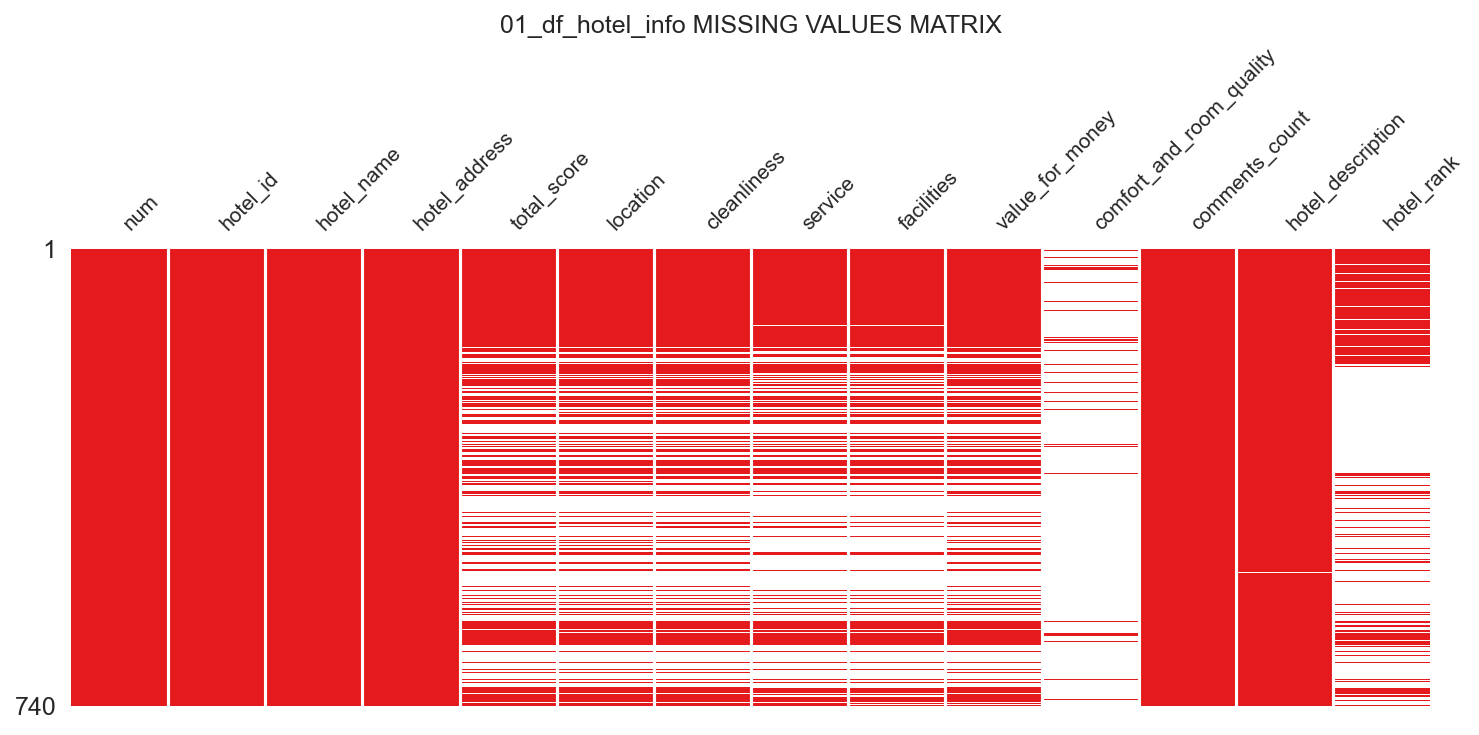

In [54]:
# check Null/NaN
fn_Null_NaN_count(df=df_hotel_info)
fn_chart_missingvalue_matrix(df=df_hotel_info, title="01_df_hotel_info MISSING VALUES MATRIX", figsize=figsize, color=sns.color_palette("Set1")[0], dpi=dpi)

images/
------------------------------
03_df_hotel_info_correlation_heatmap


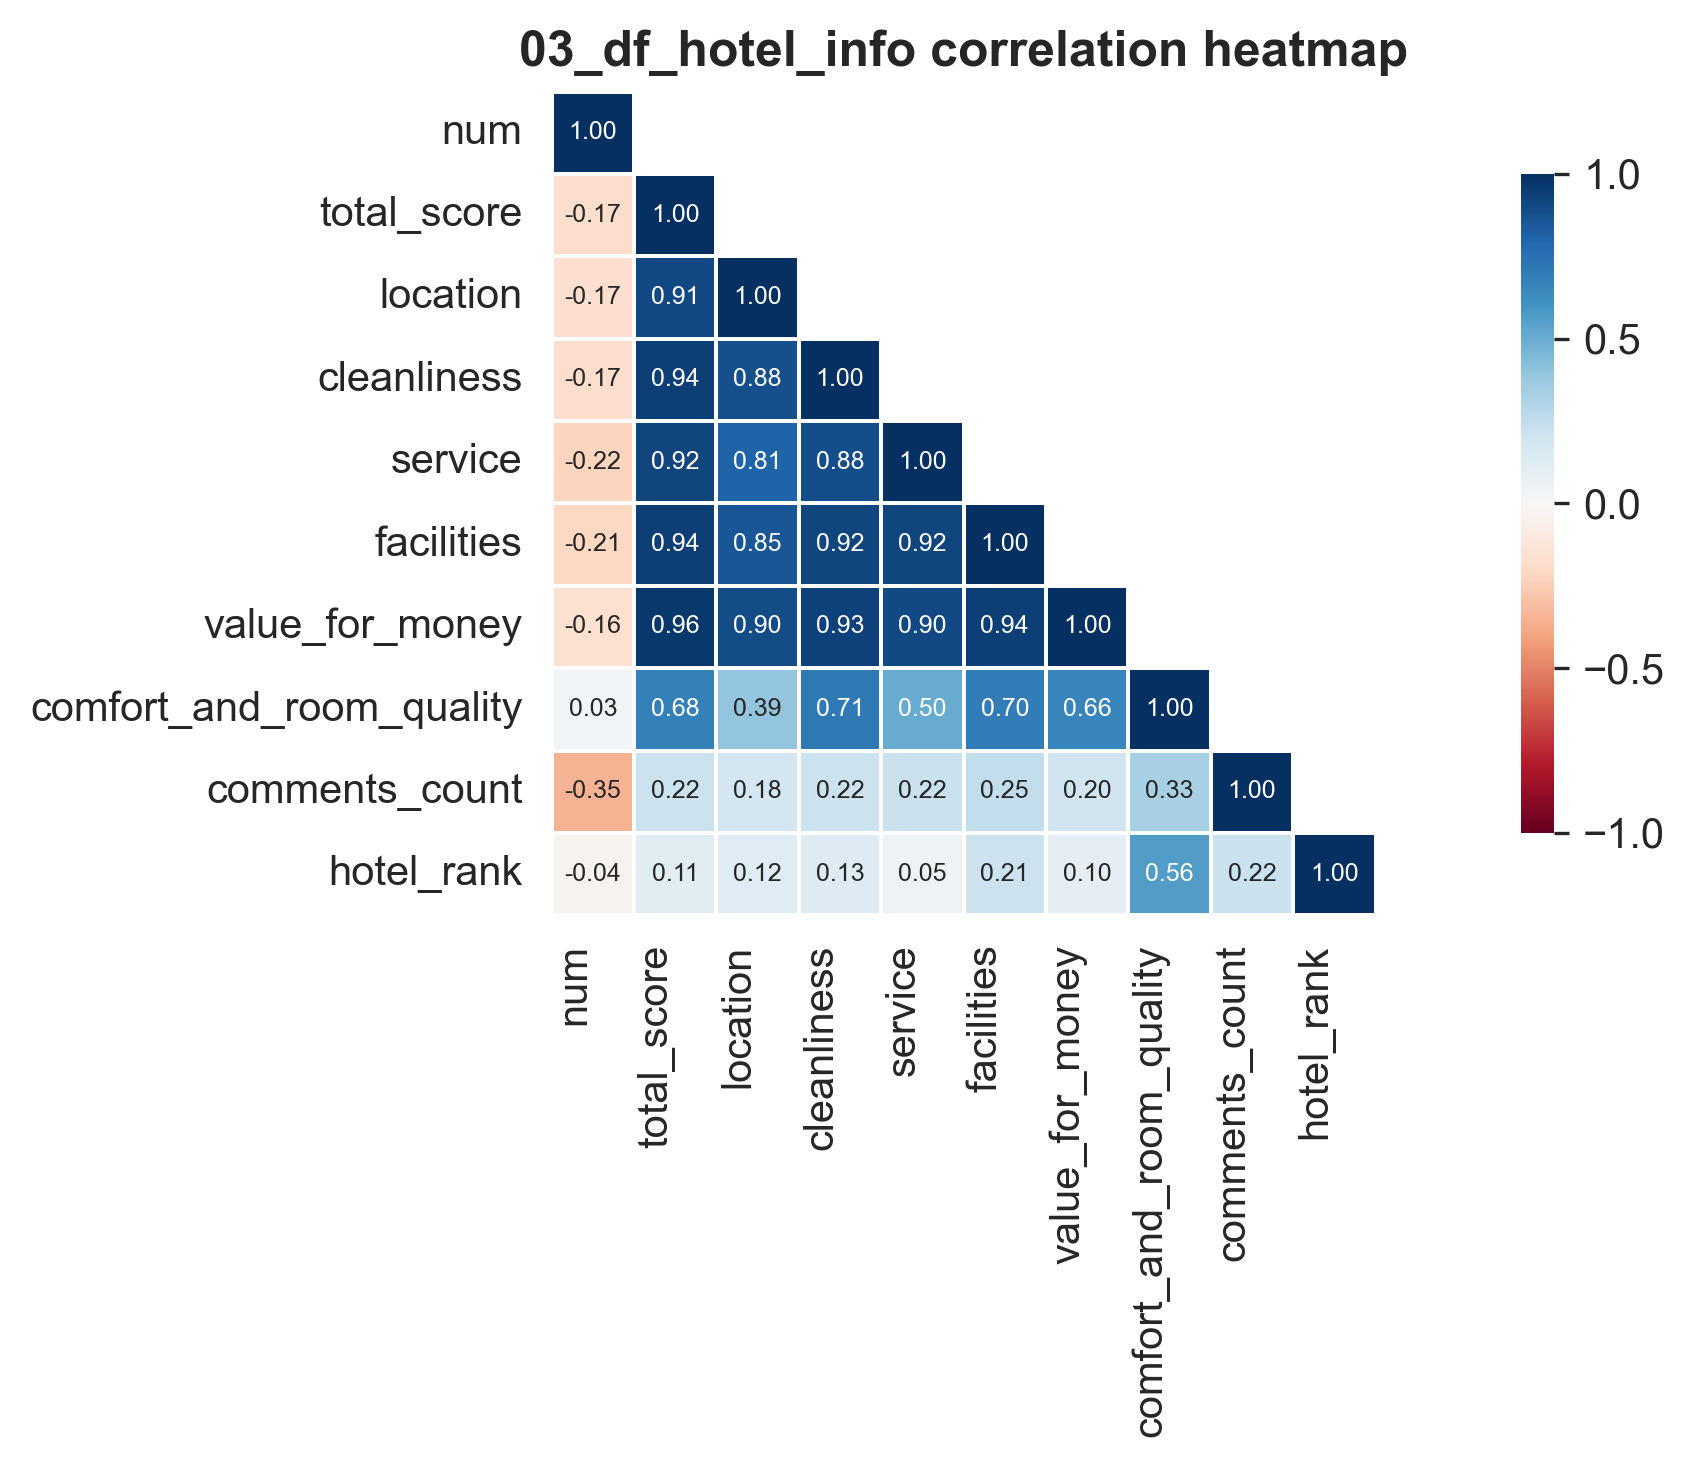

In [55]:
# corr heatmap
fn_chart_corr(df=df_hotel_info, cols=list(df_hotel_info.select_dtypes("number")), figsize=figsize, dpi=dpi, title='03_df_hotel_info correlation heatmap')

#### Hotel comments

In [56]:
# Data description: comments
fn_show(df=df_hotel_comments.describe().T, n=None)
fn_show(df=df_hotel_comments.describe(include="object").T, n=None)

dataframe: 5 rows x 8 cols


count                           mean                  min  \
num          80314.0                        40157.5                  1.0   
score        80314.0                        9.30992                  6.3   
review_date    80314  2022-11-09 00:34:58.842044928  2009-11-15 00:00:00   
stay_nights  80314.0                       2.068842                  1.0   
stay_month     80314  2022-10-01 01:49:26.546305792  2009-11-01 00:00:00   

                             25%                  50%                  75%  \
num                     20079.25              40157.5             60235.75   
score                        8.8                  9.6                 10.0   
review_date  2022-07-26 00:00:00  2023-08-25 00:00:00  2024-03-19 00:00:00   
stay_nights                  1.0                  2.0                  3.0   
stay_month   2022-07-01 00:00:00  2023-08-01 00:00:00  2024-02-01 00:00:00   

                             max           std  
num                      80314.0  23184.799097  
score                       10.0      0.946278  
review_date  2024-07-17 00:00:00           NaN  
stay_nights                 41.0      1.568909  
stay_month   2024-07-01 00:00:00           NaN

dataframe: 9 rows x 4 cols


count unique                          top   freq
hotel_id       80314    473                        10_12   1464
reviewer_id    80314  80314                        1_1_1      1
reviewer_name  80228   8190                       Nguyễn   1612
nationality    80314    110                     Việt Nam  49433
group_name     80314      6                      Cặp đôi  31068
room_type      80314   1331  Deluxe giường đôi Hướng phố   2054
score_level    80314      4            Trên cả tuyệt vời  58051
title          80314  14410           Trên cả tuyệt vời”  15494
body           80272  24899                         Good    775

column  Null_cnt  Null_pct  NaN_cnt  NaN_pct
0             num         0       0.0        0      0.0
1        hotel_id         0       0.0        0      0.0
2     reviewer_id         0       0.0        0      0.0
3   reviewer_name        86       0.1       86      0.1
4     nationality         0       0.0        0      0.0
5      group_name         0       0.0        0      0.0
6       room_type         0       0.0        0      0.0
7           score         0       0.0        0      0.0
8     score_level         0       0.0        0      0.0
9           title         0       0.0        0      0.0
10           body        42       0.1       42      0.1
11    review_date         0       0.0        0      0.0
12    stay_nights         0       0.0        0      0.0
13     stay_month         0       0.0        0      0.0

images/
------------------------------
02_df_hotel_comments_MISSING_VALUES_MATRIX


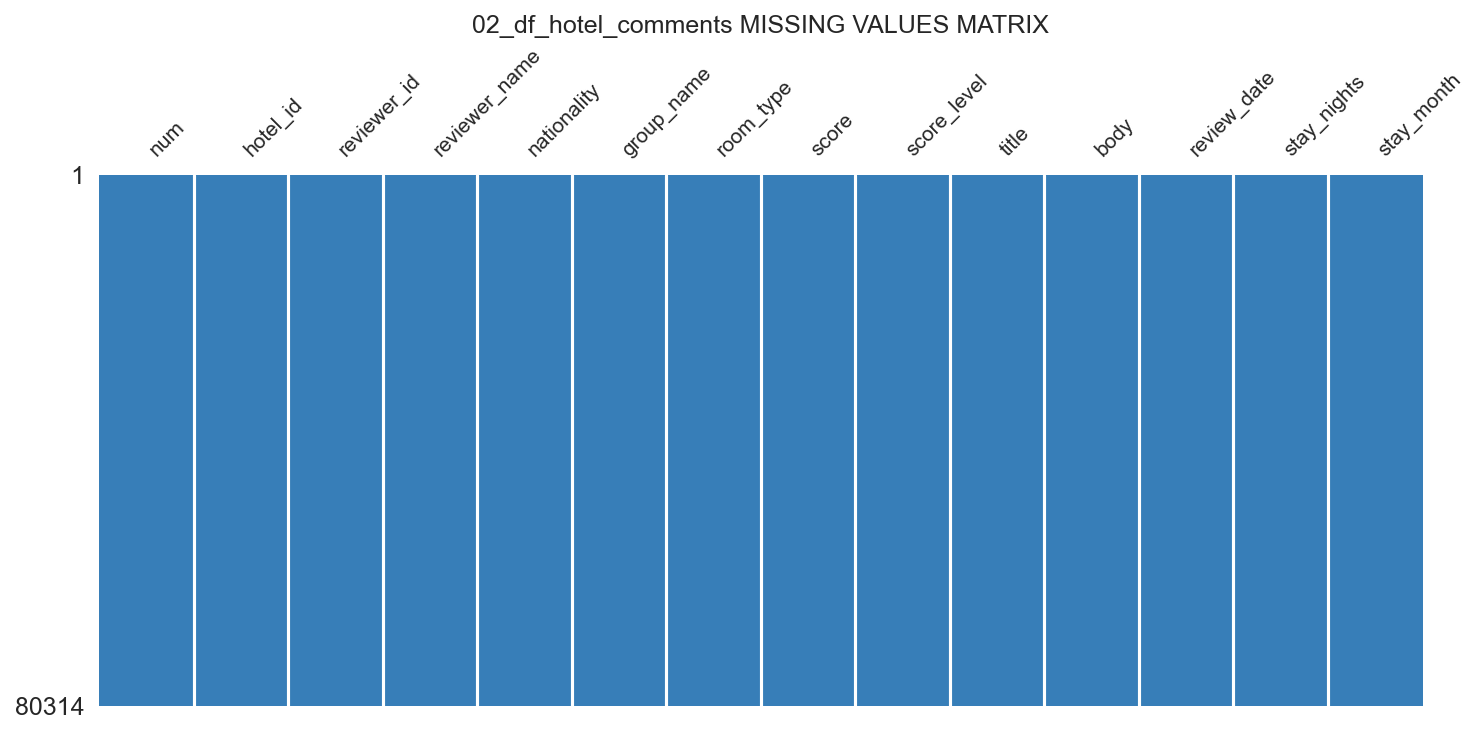

In [57]:
# check Null
fn_Null_NaN_count(df=df_hotel_comments)
fn_chart_missingvalue_matrix(df=df_hotel_comments, title="02_df_hotel_comments MISSING VALUES MATRIX", figsize=figsize, color=sns.color_palette("Set1")[1], dpi=dpi)

images/
------------------------------
04_df_hotel_comments_correlation_heatmap


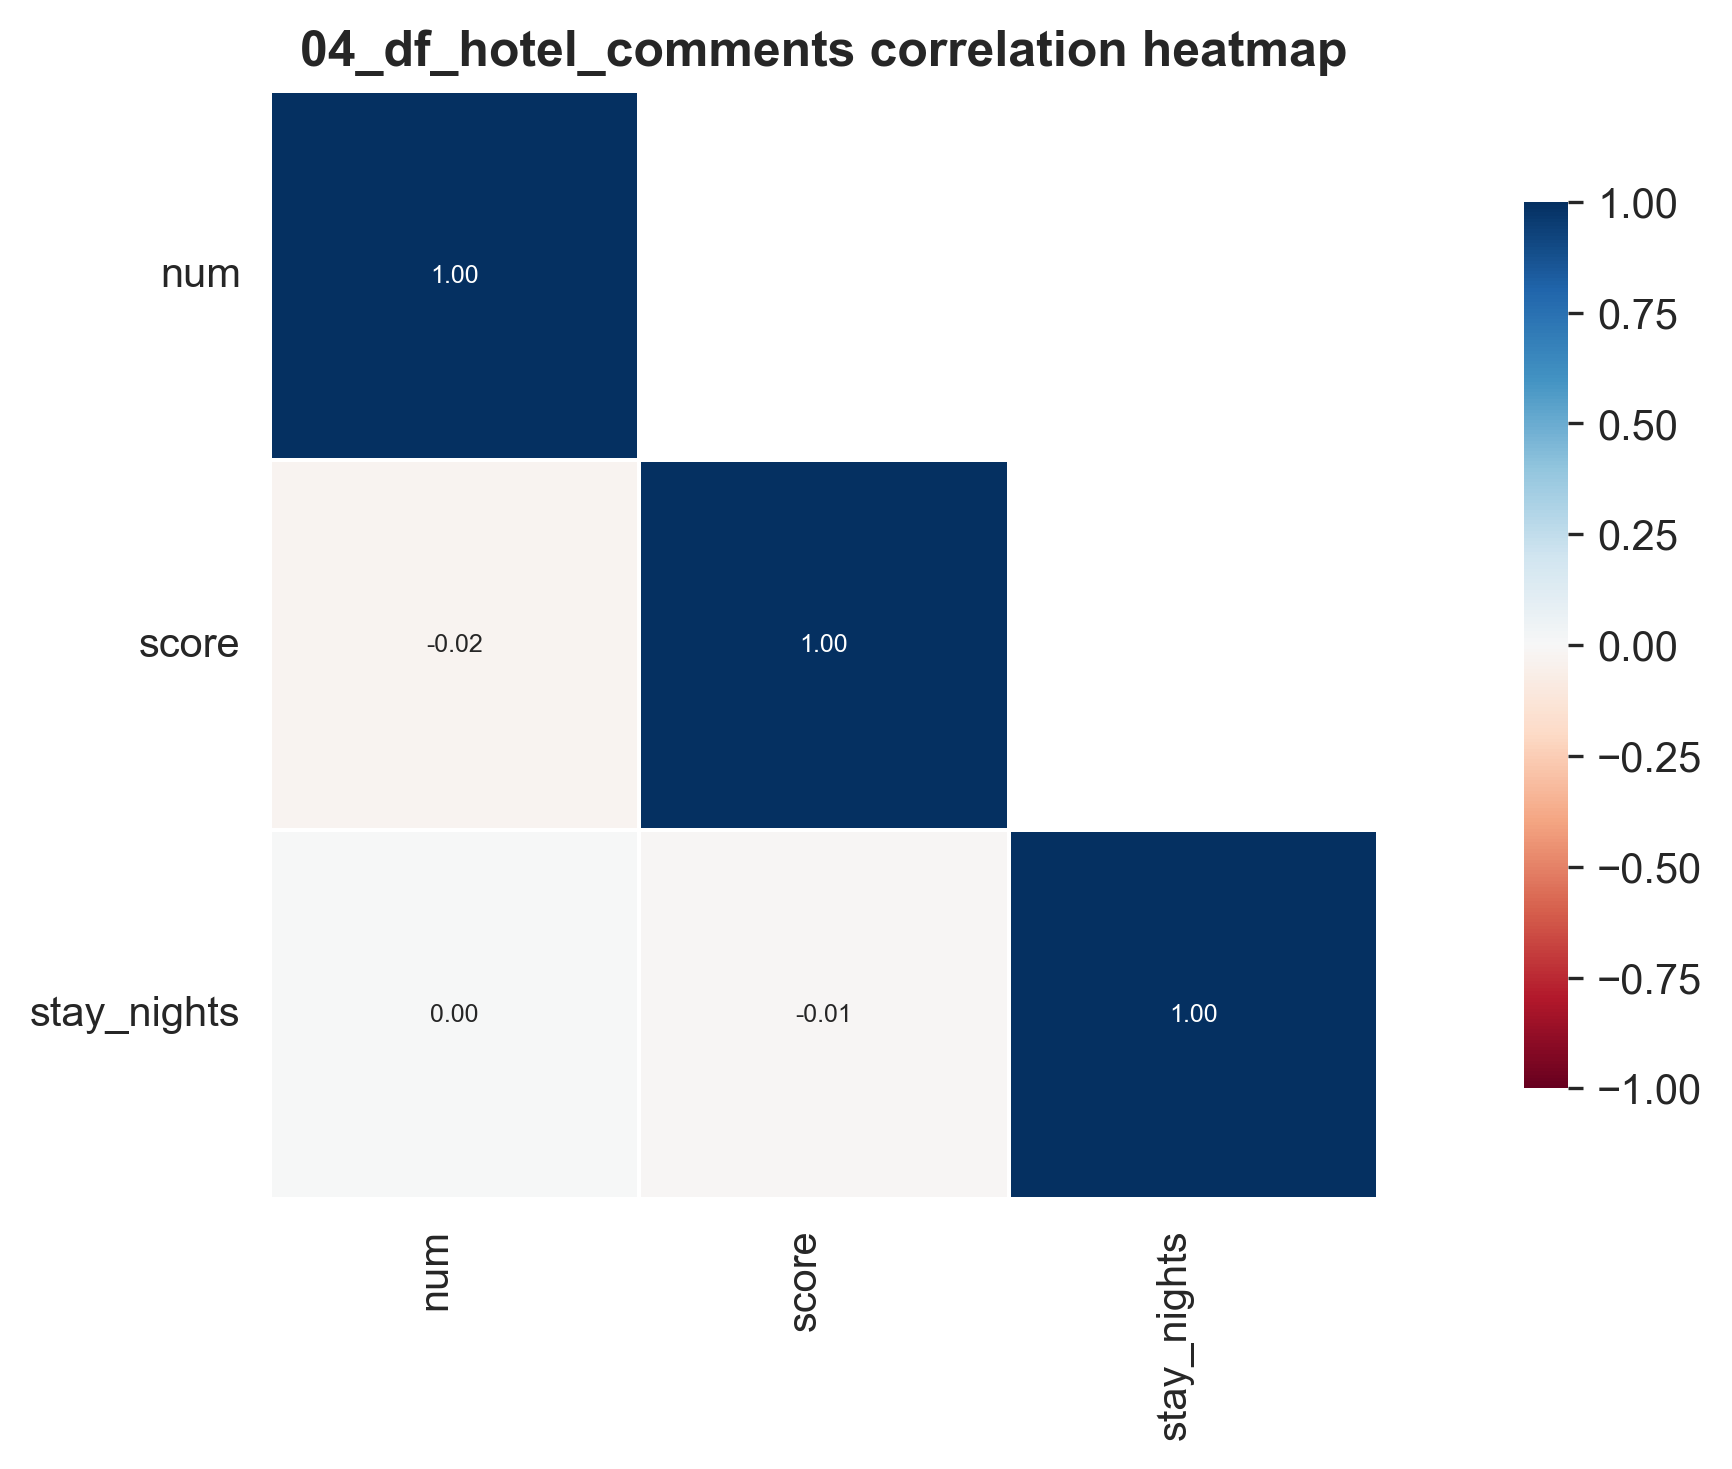

In [58]:
# corr heatmap
fn_chart_corr(df=df_hotel_comments, cols=list(df_hotel_comments.select_dtypes("number")), figsize=figsize, dpi=dpi, title='04_df_hotel_comments correlation heatmap')

### 4.9 Data final

In [59]:
# Data Final
df_info = df_hotel_info.copy()
fn_show(df=df_info, n=n_rows)
fn_save_csv(df=df_info, folder_path=path + out_path, file_name='01_df_info.csv', header=True, index=False, sep=",")

dataframe: 740 rows x 14 cols


num hotel_id                                         hotel_name  \
0    1      1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Khách sạn Aaron (Aaron Hotel)   

                                       hotel_address  total_score  location  \
0          60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam          8.8       9.4   
1  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...          7.7       7.8   
2  6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...          8.5       8.9   

   cleanliness  service  facilities  value_for_money  \
0          8.9      8.9         8.7              8.7   
1          7.6      8.1         7.5              8.1   
2          8.7      8.8         8.1              8.5   

   comfort_and_room_quality  comments_count  \
0                       8.3            1269   
1                       NaN             337   
2                       NaN             300   

                                   hotel_description  hotel_rank  
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...         5.0  
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...         4.0  
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...         3.5

data_output/
------------------------------
01_df_info.csv


In [60]:
df_comments = df_hotel_comments.copy()
fn_show(df=df_comments, n=n_rows)
fn_save_csv(df=df_comments, folder_path=path + out_path, file_name='02_df_comments.csv', header=True, index=False, sep=",")

dataframe: 80,314 rows x 14 cols


num hotel_id reviewer_id reviewer_name nationality   group_name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                room_type  score        score_level  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
2            Deluxe Hướng biển giường đôi    9.2  Trên cả tuyệt vời   

                    title                                               body  \
0             Cao nhất‼︎”  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1                Tháng 8”  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Du lịch tại Nha Trang”  Lần này đến với Nha Trang, tôi book phòng tại ...   

  review_date  stay_nights stay_month  
0  2023-07-30            3 2023-07-01  
1  2022-09-05            1 2022-09-01  
2  2024-06-25            1 2024-06-01

data_output/
------------------------------
02_df_comments.csv


## 5. Data Preprocessing


## 6. Modeling

| Hậu tố | Ý nghĩa                                |
|--------|----------------------------------------|
| _c1  | case 1: gensim + TF-IDF            |
| _c2  | case 2: cosine similarity          |
| _c3  | case 3: ALS model                  |
| _c4  | case 4: hotel Insight              |

In [61]:
# vietnamese stop words
for f in fn_file_listing(root_path=path + in_path + "files"):
    print(f"{f}")

emojicon.txt
english-vnmese.txt
teencode.txt
vietnamese-stopwords.txt
wrong-word.txt


In [62]:
# emoji
emoji = fn_read_dict(path=path + in_path + "files\\emojicon.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), emoji.items()):
    print(f"{k}: {v}")

❤: yêu
👍: thích
😍: cười
😊: cười


In [63]:
# english - vietnamese
engvie = fn_read_dict(path=path + in_path + "files\\english-vnmese.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), engvie.items()):
    print(f"{k}: {v}")

district: huyện
pebble: đá cuội
wedding: lễ cưới
comment: bình luận


In [64]:
# teen code
teencode = fn_read_dict(path=path + in_path + "files\\teencode.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), teencode.items()):
    print(f"{k}: {v}")

ctrai: con trai
khôg: không
bme: bố mẹ
cta: chúng ta


In [65]:
# vietnamese stop words
stopword_vie = fn_read_txt(path=path + in_path + "files\\vietnamese-stopwords.txt")
# print sample
for i in stopword_vie[:n_rows]: print(i)

a_lô
a_ha
ai


In [66]:
# wrong words
wrongword = fn_read_txt(path=path + in_path + "files\\wrong-word.txt")
# print sample
for i in wrongword[:n_rows]: print(i)

aud
se
gd


### 6.1 Content-based Filtering: using gensim + TF-IDF

In [67]:
# from pyvi.ViTokenizer import tokenize

In [68]:
# tạo cột content
df_hotel_info['content'] = df_hotel_info['hotel_description']

In [69]:
# tạo cột content_wt
df_hotel_info['content_wt'] = df_hotel_info['content'].apply(
    lambda x: fn_clean_tokens(
        text=str(x),
        dict_list=[emoji, teencode, engvie],
        stopword=stopword_vie,
        wrongword=wrongword,
        remove_number=True,
        remove_punctuation=True,
        remove_vie_tone=False,
        lower=True,
    )
)

In [70]:
# print sample
df_hotel_info[['hotel_description', 'content', 'content_wt']]

hotel_description  \
0    Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...   
1    ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
2    Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...   
3    Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...   
4    Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...   
..                                                 ...   
735  Victor Condotel Cam Ranh  Tận hưởng tất cả nhữ...   
736  Victor Group - Sam Sam Cam Ranh Condotel  Vict...   
737  Victory's House Ngoc Hoa  Victory's House Ngoc...   
738  Western Seaview (The Arena Cam Ranh)  Western ...   
739  Wyndham Grand KN Paradise Cam Ranh - Nơi Lý Tư...   

                                               content  \
0    Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...   
1    ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
2    Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...   
3    Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...   
4    Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...   
..                                                 ...   
735  Victor Condotel Cam Ranh  Tận hưởng tất cả nhữ...   
736  Victor Group - Sam Sam Cam Ranh Condotel  Vict...   
737  Victory's House Ngoc Hoa  Victory's House Ngoc...   
738  Western Seaview (The Arena Cam Ranh)  Western ...   
739  Wyndham Grand KN Paradise Cam Ranh - Nơi Lý Tư...   

                                            content_wt  
0    [sạn, mường, lưu, trú, tuyệt, vời, sạn, mường,...  
1    [sạn, việt, nam, sạn, tọa, lạc, thành, phố, bi...  
2    [sạn, nghỉ, dưỡng, tuyệt, vời, sạn, sạn, tọa, ...  
3    [kỳ, nghỉ, tuyệt, vời, sạn, tọa, lạc, thành, p...  
4    [sạn, nghỉ, dưỡng, tuyệt, vời, sạn, sạn, nằm, ...  
..                                                 ...  
735  [tận, hưởng, tất, vị, trí, thuận, tiện, sạn, g...  
736  [bổ, biệt, lựa, thông, quý, đi, công, tác, cỏ ...  
737  [victorys, victorys, lựa, thông, kỳ, nghỉ, thư...  
738  [western, arena, western, arena, lựa, thông, k...  
739  [lý, tưởng, tận, hưởng, kỳ, nghỉ, tuyệt, vời, ...  

[740 rows x 3 columns]

In [71]:
# content_gem
content_gem_cleaned = df_hotel_info['content_wt']

In [72]:
# bag of words
dictionary = corpora.Dictionary(content_gem_cleaned)

# Save dictionary to file
dictionary.save(path + model_path + "02_dictionary.dict")

# token to id
# dictionary.token2id

# feature count
feature_cnt = len(dictionary.token2id)
print(f"Number of features (word) in dictionary: {feature_cnt:,}")

Number of features (word) in dictionary: 4,536


In [73]:
corpus = [dictionary.doc2bow(text) for text in content_gem_cleaned]

# print sample
# corpus[0]

In [74]:
# Use TF-IDF Model to process corpus, obtaining index
model_tfidf = models.TfidfModel(corpus)

# save model TF-IDF
fn_save_model_joblib(model=model_tfidf, folder_path = path + model_path, model_name="01_tfidf.pkl")

# tính toán sự tương tự trong ma trận thưa thớt
# Khởi tạo index_matrix
index_matrix = similarities.SparseMatrixSimilarity(model_tfidf[corpus], num_features=feature_cnt)

# save matrix
fn_gensim_save_sparsematrixsimilarity(index_matrix = index_matrix ,folder_path = path + model_path, file_name = "03_gesim_sparsematrixsimilarity.index")

models/
------------------------------
01_tfidf.pkl
models/
------------------------------
03_gesim_sparsematrixsimilarity.index


In [75]:
# ma tran: n x n
df_index_matrix = pd.DataFrame(index_matrix)

# save .csv
fn_save_csv(df=df_index_matrix, folder_path = path + out_path, file_name = "03_gensim_tfidf_df_index_matrix.csv", header=False, index=False)

#print sample
display(df_index_matrix)

data_output/
------------------------------
03_gensim_tfidf_df_index_matrix.csv


0         1         2         3         4         5         6    \
0    1.000000  0.808111  0.769063  0.754719  0.792352  0.760445  0.740023   
1    0.808111  1.000000  0.812115  0.782735  0.811636  0.772077  0.758775   
2    0.769063  0.812115  1.000000  0.778994  0.811409  0.809888  0.712303   
3    0.754719  0.782735  0.778994  1.000000  0.785632  0.774768  0.683859   
4    0.792352  0.811636  0.811409  0.785632  1.000000  0.776301  0.703802   
..        ...       ...       ...       ...       ...       ...       ...   
735  0.187251  0.197568  0.203911  0.208808  0.210934  0.185372  0.160483   
736  0.165324  0.164952  0.151076  0.168039  0.163411  0.157186  0.147989   
737  0.071423  0.088453  0.083513  0.076413  0.102275  0.081098  0.082366   
738  0.246007  0.267196  0.251452  0.237346  0.277411  0.225684  0.228289   
739  0.702468  0.716614  0.698375  0.702339  0.685725  0.690158  0.684300   

          7         8         9    ...       730       731       732  \
0    0.672728  0.683618  0.372342  ...  0.297716  0.705507  0.297596   
1    0.686442  0.721131  0.382485  ...  0.288304  0.753292  0.287124   
2    0.677998  0.710637  0.371484  ...  0.283994  0.741404  0.285971   
3    0.626563  0.691339  0.327419  ...  0.250389  0.701079  0.282809   
4    0.671664  0.700383  0.359801  ...  0.283519  0.694933  0.296641   
..        ...       ...       ...  ...       ...       ...       ...   
735  0.179126  0.182083  0.342400  ...  0.551700  0.178267  0.410566   
736  0.134429  0.150411  0.388416  ...  0.364269  0.147618  0.419751   
737  0.067019  0.077454  0.205441  ...  0.170927  0.080797  0.248316   
738  0.215877  0.243333  0.476393  ...  0.354767  0.227741  0.503919   
739  0.631532  0.671324  0.331844  ...  0.276269  0.719886  0.252991   

          733       734       735       736       737       738       739  
0    0.577106  0.259236  0.187251  0.165324  0.071423  0.246007  0.702468  
1    0.603274  0.261573  0.197568  0.164952  0.088453  0.267196  0.716614  
2    0.596263  0.263042  0.203911  0.151076  0.083513  0.251452  0.698375  
3    0.586156  0.227660  0.208808  0.168039  0.076413  0.237346  0.702339  
4    0.567125  0.239929  0.210934  0.163411  0.102275  0.277411  0.685725  
..        ...       ...       ...       ...       ...       ...       ...  
735  0.155566  0.329497  1.000000  0.525792  0.222390  0.338937  0.203711  
736  0.129188  0.395768  0.525792  1.000000  0.263765  0.405007  0.149682  
737  0.059363  0.192170  0.222390  0.263765  1.000000  0.234014  0.086656  
738  0.207413  0.377532  0.338937  0.405007  0.234014  1.000000  0.237797  
739  0.646525  0.225325  0.203711  0.149682  0.086656  0.237797  1.000000  

[740 rows x 740 columns]

### 6.2 Content-based Filtering: using cosine_similarity

In [76]:
df_hotel_info[['hotel_description', 'content', 'content_wt']].head(n=n_rows)

hotel_description  \
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...   
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...   

                                             content  \
0  Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...   
1  ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
2  Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...   

                                          content_wt  
0  [sạn, mường, lưu, trú, tuyệt, vời, sạn, mường,...  
1  [sạn, việt, nam, sạn, tọa, lạc, thành, phố, bi...  
2  [sạn, nghỉ, dưỡng, tuyệt, vời, sạn, sạn, tọa, ...

In [77]:
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

In [78]:
# Vector hóa nội dung
# from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="word", stop_words=stopword_vie)
tfidf_matrix = vectorizer.fit_transform(df_hotel_info["content_wt"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x)))

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# save matrix
fn_cosine_sim_save(cosine_sim=cosine_sim, folder_path = path + model_path, file_name = "04_cosine_sparsematrixsimilarity.npy")

# Ma trận cosine_sim
df_index_matrix_cosine = pd.DataFrame(cosine_sim)

# save file csv
fn_save_csv(df=df_index_matrix_cosine, folder_path = path + out_path, file_name = "06_cosine_tfidf_df_index_matrix.csv")

models/
------------------------------
04_cosine_sparsematrixsimilarity.npy
data_output/
------------------------------
06_cosine_tfidf_df_index_matrix.csv


In [79]:
df_index_matrix_cosine

0         1         2         3         4         5         6    \
0    1.000000  0.878246  0.843660  0.838254  0.870464  0.833998  0.852611   
1    0.878246  1.000000  0.872926  0.848705  0.884773  0.846795  0.867274   
2    0.843660  0.872926  1.000000  0.845809  0.873491  0.868740  0.826243   
3    0.838254  0.848705  0.845809  1.000000  0.859670  0.855922  0.803222   
4    0.870464  0.884773  0.873491  0.859670  1.000000  0.856183  0.827866   
..        ...       ...       ...       ...       ...       ...       ...   
735  0.279298  0.285302  0.303166  0.301309  0.313857  0.259740  0.261653   
736  0.292794  0.277234  0.263381  0.284484  0.281353  0.263895  0.278725   
737  0.165380  0.192111  0.186885  0.187652  0.209813  0.180794  0.184736   
738  0.394175  0.406015  0.396492  0.383026  0.421762  0.357884  0.377377   
739  0.810349  0.812625  0.798956  0.807359  0.800133  0.795134  0.806364   

          7         8         9    ...       730       731       732  \
0    0.819883  0.805962  0.525707  ...  0.426885  0.799415  0.405471   
1    0.825541  0.838212  0.524182  ...  0.414576  0.840683  0.389085   
2    0.817763  0.822417  0.507033  ...  0.420095  0.825680  0.385578   
3    0.772804  0.813303  0.475499  ...  0.385179  0.797316  0.383095   
4    0.817489  0.828289  0.512499  ...  0.420200  0.798097  0.408376   
..        ...       ...       ...  ...       ...       ...       ...   
735  0.266250  0.281782  0.467570  ...  0.657745  0.261592  0.512462   
736  0.244514  0.261191  0.521268  ...  0.503799  0.238592  0.534447   
737  0.158803  0.188749  0.360045  ...  0.348274  0.182854  0.418806   
738  0.364752  0.389246  0.674610  ...  0.539764  0.357319  0.679850   
739  0.776787  0.796586  0.474705  ...  0.414184  0.825069  0.360789   

          733       734       735       736       737       738       739  
0    0.754377  0.420166  0.279298  0.292794  0.165380  0.394175  0.810349  
1    0.767323  0.414092  0.285302  0.277234  0.192111  0.406015  0.812625  
2    0.760531  0.406984  0.303166  0.263381  0.186885  0.396492  0.798956  
3    0.745270  0.369981  0.301309  0.284484  0.187652  0.383026  0.807359  
4    0.738951  0.397098  0.313857  0.281353  0.209813  0.421762  0.800133  
..        ...       ...       ...       ...       ...       ...       ...  
735  0.268323  0.471124  1.000000  0.583161  0.362585  0.468462  0.298727  
736  0.263078  0.556766  0.583161  1.000000  0.390671  0.530504  0.262870  
737  0.159957  0.367316  0.362585  0.390671  1.000000  0.402797  0.209836  
738  0.376689  0.592921  0.468462  0.530504  0.402797  1.000000  0.382577  
739  0.786607  0.377358  0.298727  0.262870  0.209836  0.382577  1.000000  

[740 rows x 740 columns]

### 6.3 Collaborative filtering: using ALS (spark)

In [80]:
# import findspark

# findspark.init()

# from pyspark.sql import SparkSession
# from pyspark import SparkContext
# from pyspark.sql import functions as F

# from pyspark.ml.recommendation import ALS
# from pyspark.ml.evaluation import RegressionEvaluator
# # convert string to index
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml import Pipeline

In [81]:
sc = SparkContext(master="local", appName="agoda_recommendation_ALS")
spark = SparkSession(sc)

In [82]:
fn_show(df=df_hotel_comments[df_hotel_comments["score"].notna()], n = n_rows)

dataframe: 80,314 rows x 14 cols


num hotel_id reviewer_id reviewer_name nationality   group_name  \
0    1      1_1       1_1_1        MARIKO    Nhật Bản      Cặp đôi   
1    2      1_1       1_1_2          Hong    Việt Nam  Đi công tác   
2    3      1_1       1_1_3          Guai    Việt Nam      Cặp đôi   

                                room_type  score        score_level  \
0  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
1  Phòng Deluxe 2 Giường đơn Nhìn ra Biển   10.0  Trên cả tuyệt vời   
2            Deluxe Hướng biển giường đôi    9.2  Trên cả tuyệt vời   

                    title                                               body  \
0             Cao nhất‼︎”  Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...   
1                Tháng 8”  Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...   
2  Du lịch tại Nha Trang”  Lần này đến với Nha Trang, tôi book phòng tại ...   

  review_date  stay_nights stay_month  
0  2023-07-30            3 2023-07-01  
1  2022-09-05            1 2022-09-01  
2  2024-06-25            1 2024-06-01

In [83]:
# data input ALS
# sử dụng "score" làm cột "rating"
df_hotel_comments_ALS = spark.createDataFrame(df_hotel_comments[df_hotel_comments["score"].notna()][["hotel_id", "reviewer_name", "score"]])

# show sample
print(f"Hotel comments original data: {df_hotel_comments.shape[0]:,} rows x {df_hotel_comments.shape[1]} cols")
print(f"ALS               input data: {df_hotel_comments_ALS.count():,} rows x {len(df_hotel_comments_ALS.columns)} cols\n")
fn_show_spark(df=df_hotel_comments_ALS, n=n_rows, printSchema=True, truncate=False)

Hotel comments original data: 80,314 rows x 14 cols
ALS               input data: 80,314 rows x 3 cols

dataframe: 80,314 rows x 3 cols

root
 |-- hotel_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- score: double (nullable = true)

+--------+-------------+-----+
|hotel_id|reviewer_name|score|
+--------+-------------+-----+
|1_1     |MARIKO       |10.0 |
|1_1     |Hong         |10.0 |
|1_1     |Guai         |9.2  |
+--------+-------------+-----+
only showing top 3 rows



In [84]:
# kiểm tra giá trị null
df_hotel_comments_ALS.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_hotel_comments_ALS.columns]).show()

+--------+-------------+-----+
|hotel_id|reviewer_name|score|
+--------+-------------+-----+
|       0|            0|    0|
+--------+-------------+-----+



In [85]:
# distinct reviewers and hotels
reviewer_cnt = df_hotel_comments_ALS.select("reviewer_name").distinct().count()
hotel_cnt = df_hotel_comments_ALS.select("hotel_id").distinct().count()
numerator = df_hotel_comments_ALS.count()

print(f"Total numerator (ratings): {numerator:,}")
print(f"Total users              : {reviewer_cnt:,}")
print(f"Total hotels             : {hotel_cnt:,}")

Total numerator (ratings): 80,314
Total users              : 8,191
Total hotels             : 473


In [86]:
# denominator
denominator = reviewer_cnt * hotel_cnt
print(f"Total denominator (ratings matrix): {denominator:,}")

# calculate sparsity
sparsity = 1 - (numerator * 1.0 / denominator)
print(f"Sparsity: {sparsity:,.2%}")

Total denominator (ratings matrix): 3,874,343
Sparsity: 97.93%


In [87]:
# string indexer
indexer = StringIndexer(inputCol="hotel_id", outputCol="hotel_id_idx")
indexer_model = indexer.fit(df_hotel_comments_ALS)
data_indexed = indexer_model.transform(df_hotel_comments_ALS)

indexer_1 = StringIndexer(inputCol="reviewer_name", outputCol="reviewer_name_idx")
indexer_1_model = indexer_1.fit(data_indexed)
data_indexed = indexer_1_model.transform(data_indexed)

fn_show_spark(df=data_indexed, n=n_rows, truncate=False)

dataframe: 80,314 rows x 5 cols

+--------+-------------+-----+------------+-----------------+
|hotel_id|reviewer_name|score|hotel_id_idx|reviewer_name_idx|
+--------+-------------+-----+------------+-----------------+
|1_1     |MARIKO       |10.0 |15.0        |1682.0           |
|1_1     |Hong         |10.0 |15.0        |34.0             |
|1_1     |Guai         |9.2  |15.0        |1929.0           |
+--------+-------------+-----+------------+-----------------+
only showing top 3 rows



In [88]:
# kiểm tra giá trị null
data_indexed.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data_indexed.columns]).show()

+--------+-------------+-----+------------+-----------------+
|hotel_id|reviewer_name|score|hotel_id_idx|reviewer_name_idx|
+--------+-------------+-----+------------+-----------------+
|       0|            0|    0|           0|                0|
+--------+-------------+-----+------------+-----------------+



In [89]:
# train test split
df_ALS_train, df_ALS_test = data_indexed.randomSplit([0.8, 0.2], seed=random_state)

##### Tuning hyperparameter

In [90]:
# # Tuning hyperparameter

# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator

In [91]:
# # ALS model
# als = ALS(
#     userCol="reviewer_name_idx",
#     itemCol="hotel_id_idx",
#     ratingCol="score",
#     coldStartStrategy="drop",
#     nonnegative=True
# )

# # evaluator
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="score", predictionCol="prediction")

# # grid search
# paramGrid = (
#     ParamGridBuilder()
#     .addGrid(als.rank, [10, 25, 50])
#     .addGrid(als.regParam, [0.01, 0.05, 0.1])
#     .addGrid(als.maxIter, [10, 20])
#     .build()
# )

# # cross validation
# cv = CrossValidator(
#     estimator=als,
#     estimatorParamMaps=paramGrid,
#     evaluator=evaluator,
#     numFolds=3,             # 3-fold CV
#     parallelism=4           # chạy song song
# )

# # fit model
# cvModel = cv.fit(df_ALS_train)

# # best model
# bestModel = cvModel.bestModel
# print("Best rank:", bestModel.rank)
# print("Best regParam:", bestModel._java_obj.parent().getRegParam())
# print("Best maxIter:", bestModel._java_obj.parent().getMaxIter())

In [92]:
# Best rank: 50
# Best regParam: 0.05
# Best maxIter: 20

In [93]:
# ALS model
als = ALS(
    maxIter=20,
    regParam=0.05,
    rank=50,
    userCol="reviewer_name_idx",
    itemCol="hotel_id_idx",
    ratingCol="score",
    coldStartStrategy="drop",
    nonnegative=True,
)
ALS_model = als.fit(df_ALS_train)

# save model
ALS_model.write().overwrite().save(os.path.join(path, model_path, "05_ALS_model"))

In [94]:
# predictions
ALS_predictions = ALS_model.transform(df_ALS_test)
ALS_predictions.select(["hotel_id_idx", "reviewer_name_idx", "score", "prediction"]).show(n=n_rows)

+------------+-----------------+-----+----------+
|hotel_id_idx|reviewer_name_idx|score|prediction|
+------------+-----------------+-----+----------+
|        27.0|           1580.0|  9.6|   9.57965|
|        63.0|            463.0| 10.0|   9.86652|
|         6.0|            496.0| 10.0|  9.950888|
+------------+-----------------+-----+----------+
only showing top 3 rows



In [95]:
# evaluate
rmse = RegressionEvaluator(metricName="rmse", labelCol="score", predictionCol="prediction").evaluate(ALS_predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse:.2f}")

Root Mean Squared Error (RMSE) = 0.62


Nhận xét: RMSE

| Chỉ số | Giá trị | Ý nghĩa |
|-------|---------|---------|
| RMSE `sau tuning` | **0.62** | - Cải thiện đáng kể, mức khá mạnh cho collaborative filtering<br>- Model dự đoán khá gần với hành vi user|

### 6.4 Hotel Insight

In [96]:
df_info.describe().T

count        mean         std  min      25%     50%  \
num                       740.0  370.500000  213.763888  1.0  185.750  370.50   
total_score               414.0    8.014734    1.763279  2.0    7.700    8.50   
location                  413.0    8.273123    1.923609  2.0    8.200    8.70   
cleanliness               412.0    8.121845    1.914246  2.0    7.800    8.70   
service                   373.0    8.295442    1.741000  2.0    8.000    8.80   
facilities                370.0    7.903514    1.697763  2.0    7.425    8.25   
value_for_money           410.0    8.182439    1.889938  2.0    8.000    8.70   
comfort_and_room_quality   51.0    8.301961    1.207227  3.0    7.700    8.50   
comments_count            740.0   94.401351  258.096718  0.0    0.000    0.00   
hotel_rank                267.0    4.134831    0.993676  1.0    3.500    4.50   

                             75%     max  
num                       555.25   740.0  
total_score                 8.90    10.0  
location                    9.30    10.0  
cleanliness                 9.20    10.0  
service                     9.20    10.0  
facilities                  8.90    10.0  
value_for_money             9.20    10.0  
comfort_and_room_quality    9.10    10.0  
comments_count             28.25  1464.0  
hotel_rank                  5.00     5.0

In [97]:
df_comments.describe().T

count                           mean                  min  \
num          80314.0                        40157.5                  1.0   
score        80314.0                        9.30992                  6.3   
review_date    80314  2022-11-09 00:34:58.842044928  2009-11-15 00:00:00   
stay_nights  80314.0                       2.068842                  1.0   
stay_month     80314  2022-10-01 01:49:26.546305792  2009-11-01 00:00:00   

                             25%                  50%                  75%  \
num                     20079.25              40157.5             60235.75   
score                        8.8                  9.6                 10.0   
review_date  2022-07-26 00:00:00  2023-08-25 00:00:00  2024-03-19 00:00:00   
stay_nights                  1.0                  2.0                  3.0   
stay_month   2022-07-01 00:00:00  2023-08-01 00:00:00  2024-02-01 00:00:00   

                             max           std  
num                      80314.0  23184.799097  
score                       10.0      0.946278  
review_date  2024-07-17 00:00:00           NaN  
stay_nights                 41.0      1.568909  
stay_month   2024-07-01 00:00:00           NaN

## 7. Predict

### Predict top N = 

In [98]:
top_N: int = 3 # top 3 khách sạn tương đồng nhất
info_cols_toshow = [
    "hotel_id",
    "hotel_name",
    "hotel_address",
    "total_score",
    "location",
    "cleanliness",
    "service",
    "facilities",
    "value_for_money",
    "comfort_and_room_quality",
    "comments_count",
    "hotel_description",
    "hotel_rank",
]

In [99]:
# Danh sách Khách sạn
hotel_lst = df_hotel_info[['hotel_id', 'hotel_name']].drop_duplicates()
hotel_lst

hotel_id                                         hotel_name
0        1_1  Khách sạn Mường Thanh Luxury Nha Trang (Muong ...
1        1_2                               ALPHA BIRD NHA TRANG
2        1_3                      Khách sạn Aaron (Aaron Hotel)
3        1_4                      Panorama Star Beach Nha Trang
4        1_5  Khách sạn Balcony Nha Trang (Balcony Nha Trang...
..       ...                                                ...
735     16_5                           Victor Condotel Cam Ranh
736    30_24           Victor Group - Sam Sam Cam Ranh Condotel
737    27_21                           Victory's House Ngoc Hoa
738     8_21               Western Seaview (The Arena Cam Ranh)
739    14_14                 Wyndham Grand KN Paradise Cam Ranh

[740 rows x 2 columns]

### Chọn 'Khách sạn' trên index

In [100]:
# seed
np.random.seed(random_state)

# Giả sử chọn 1 khách sạn:
search_hotel_idx = np.random.randint(0, len(hotel_lst))
search_hotel_id = hotel_lst.iloc[search_hotel_idx]["hotel_id"]
search_hotel_name = hotel_lst.iloc[search_hotel_idx]["hotel_name"]

print(f"hotel_idx  : {search_hotel_idx}")
print(f"hotel_id   : {search_hotel_id}")
print(f"hotel_name : {search_hotel_name}")

hotel_idx  : 102
hotel_id   : 5_6
hotel_name : Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)


### Chọn 'Khách sạn' dựa trên từ khóa tìm kiếm

In [101]:
# Giả sử nhập tìm kiếm như sau
search_input = "Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình"

### 7.1 Content-based Filtering: using gensim + TF-IDF

#### 7.1.1 Search bằng index

In [102]:
# top N khách sạn tương đồng với Khách sạn đang chọn
top_indices_c1 = df_index_matrix.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
print(f"top indices idx: {top_indices_c1}")

# predict
df_predict_c1 = df_hotel_info.loc[df_hotel_info.index[top_indices_c1], info_cols_toshow]
fn_show(df=df_predict_c1, n=None)

# save csv
fn_save_csv(df=df_predict_c1, folder_path = path + out_path, file_name = '04_gensim_tfidf_predict_idx.csv', header=True, index=True)

top indices idx: [29, 149, 624]
dataframe: 3 rows x 13 cols


hotel_id                                         hotel_name  \
29      1_30                              Areca Hotel Nha Trang   
149    10_22  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...   
624     4_23  Khách sạn Havana  Nha Trang (Havana Nha Trang ...   

                                         hotel_address  total_score  location  \
29   46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...          8.9       9.0   
149  12 Trần Phú , Xương Huân, Nha Trang, Việt Nam,...          8.9       9.0   
624  38 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 650000          9.0       9.5   

     cleanliness  service  facilities  value_for_money  \
29           9.2      9.1         8.9              9.2   
149          9.1      9.2         8.8              8.9   
624          9.1      9.2         9.1              9.2   

     comfort_and_room_quality  comments_count  \
29                        NaN             160   
149                       8.9             846   
624                       8.8            1338   

                                     hotel_description  hotel_rank  
29   Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...         4.0  
149  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...         5.0  
624  Khách sạn Havana  Nha Trang - Nơi lưu trú hoàn...         5.0

data_output/
------------------------------
04_gensim_tfidf_predict_idx.csv


In [103]:
# # sử dụng bằng file csv đã lưu trước đó
# df_index_matrix_csv = fn_read_csv(folder_path = path + out_path, file_name = "03_gensim_tfidf_df_index_matrix.csv", header=False)

# top_indices_c1_csv = df_index_matrix_csv.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
# print(f"top indices idx: {top_indices_c1_csv}")

# # predict
# df_predict_c1_csv = df_hotel_info.loc[df_hotel_info.index[top_indices_c1_csv], info_cols_toshow]
# fn_show(df=df_predict_c1_csv, n=None)

# # save csv
# fn_save_csv(df=df_predict_c1_csv, folder_path = path + out_path, file_name = '04_gensim_tfidf_predict_idx.csv', header=True, index=True)

#### 7.1.2 Search bằng từ khóa

In [104]:
# từ khóa
print(f"search: '{search_input}'")

search: 'Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình'


In [105]:
# xử lý token của search_input
search_input_tokens = fn_clean_tokens(
    text=search_input,
    dict_list=[emoji, teencode, engvie],
    stopword=stopword_vie,
    wrongword=wrongword,
    remove_number=True,
    remove_punctuation=True,
    remove_vie_tone=False,
    lower=True,
)

# load dictionary from file
loaded_dictionary = corpora.Dictionary.load(path + model_path +"02_dictionary.dict")

# load model tf-idf
loaded_model_tfidf = fn_load_model_joblib(folder_path = path + model_path, model_name = "01_tfidf.pkl")

# load index matrix
loaded_index_matrix = fn_gensim_load_sparsematrixsimilarity(folder_path = path + model_path, file_name = "03_gesim_sparsematrixsimilarity.index")

# sim
sim = loaded_index_matrix[loaded_model_tfidf[loaded_dictionary.doc2bow(search_input_tokens)]]

# top N khách sạn tương đồng với từ khóa
recommend = pd.DataFrame({"id": range(len(sim)), "sim": sim}).nlargest(n=top_N, columns="sim")
top_indices_c1_search = recommend['id'].to_list()
print(f"top indices idx: {top_indices_c1_search}")

# predict
df_predict_c1_search = df_hotel_info.loc[df_hotel_info.index[top_indices_c1], info_cols_toshow]
fn_show(df=df_predict_c1_search, n=None)

# save csv
fn_save_csv(df=df_predict_c1_search, folder_path = path + out_path, file_name = '05_gensim_tfidf_predict_search.csv', header=True, index=True)

top indices idx: [454, 525, 301]
dataframe: 3 rows x 13 cols


hotel_id                                         hotel_name  \
29      1_30                              Areca Hotel Nha Trang   
149    10_22  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...   
624     4_23  Khách sạn Havana  Nha Trang (Havana Nha Trang ...   

                                         hotel_address  total_score  location  \
29   46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...          8.9       9.0   
149  12 Trần Phú , Xương Huân, Nha Trang, Việt Nam,...          8.9       9.0   
624  38 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 650000          9.0       9.5   

     cleanliness  service  facilities  value_for_money  \
29           9.2      9.1         8.9              9.2   
149          9.1      9.2         8.8              8.9   
624          9.1      9.2         9.1              9.2   

     comfort_and_room_quality  comments_count  \
29                        NaN             160   
149                       8.9             846   
624                       8.8            1338   

                                     hotel_description  hotel_rank  
29   Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...         4.0  
149  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...         5.0  
624  Khách sạn Havana  Nha Trang - Nơi lưu trú hoàn...         5.0

data_output/
------------------------------
05_gensim_tfidf_predict_search.csv


### 7.2 Content-based Filtering: using cosine_similarity

#### 7.2.1 Search bằng index

In [106]:
# top N khách sạn tương đồng với Khách sạn đang chọn
top_indices_c2 = df_index_matrix_cosine.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
print(f"top indices idx: {top_indices_c2}")

# predict
df_predict_c2 = df_hotel_info.loc[df_hotel_info.index[top_indices_c2], info_cols_toshow]
fn_show(df=df_predict_c2, n=None)

# save csv
fn_save_csv(df=df_predict_c2, folder_path = path + out_path, file_name = '07_cosine_tfidf_predict_idx.csv', header=True, index=True)

top indices idx: [29, 149, 624]
dataframe: 3 rows x 13 cols


hotel_id                                         hotel_name  \
29      1_30                              Areca Hotel Nha Trang   
149    10_22  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...   
624     4_23  Khách sạn Havana  Nha Trang (Havana Nha Trang ...   

                                         hotel_address  total_score  location  \
29   46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...          8.9       9.0   
149  12 Trần Phú , Xương Huân, Nha Trang, Việt Nam,...          8.9       9.0   
624  38 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 650000          9.0       9.5   

     cleanliness  service  facilities  value_for_money  \
29           9.2      9.1         8.9              9.2   
149          9.1      9.2         8.8              8.9   
624          9.1      9.2         9.1              9.2   

     comfort_and_room_quality  comments_count  \
29                        NaN             160   
149                       8.9             846   
624                       8.8            1338   

                                     hotel_description  hotel_rank  
29   Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...         4.0  
149  Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...         5.0  
624  Khách sạn Havana  Nha Trang - Nơi lưu trú hoàn...         5.0

data_output/
------------------------------
07_cosine_tfidf_predict_idx.csv


#### 7.2.2 Search bằng từ khóa

In [107]:
# từ khóa
print(f"search: '{search_input}'")

search: 'Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình'


In [108]:
# Khởi tạo lại vectorizer và fit trên toàn bộ dữ liệu để đảm bảo tính nhất quán khi transform search_input
vectorizer = TfidfVectorizer(analyzer="word", stop_words=stopword_vie)
tfidf_matrix = vectorizer.fit_transform(df_hotel_info["content_wt"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x)))

# Vector hóa search_input
search_vec = vectorizer.transform([search_input])

# Tính toán độ tương đồng giữa search_input và toàn bộ khách sạn (dùng lại tfidf_matrix đã fit)
cosine_sim_search = cosine_similarity(search_vec, tfidf_matrix).flatten()


# top N khách sạn tương đồng với từ khóa
recommend_cosine = pd.DataFrame({"id": range(len(cosine_sim_search)), "sim": cosine_sim_search}).nlargest(n=top_N, columns="sim")

top_indices_c2_search = recommend_cosine['id'].to_list()
print(f"top indices idx: {top_indices_c2_search}")

# predict
df_predict_c2_search = df_hotel_info.loc[df_hotel_info.index[top_indices_c2_search], info_cols_toshow]
fn_show(df=df_predict_c2_search, n=None)

# save csv
fn_save_csv(df=df_predict_c2_search, folder_path=path + out_path, file_name='08_cosine_tfidf_predict_search.csv', header=True, index=True)

top indices idx: [454, 318, 654]
dataframe: 3 rows x 13 cols


hotel_id                                         hotel_name  \
454    43_14  Chung cư studio 60 m² có 1 phòng tắm riêng ở L...   
318    35_28  Căn hộ 70 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...   
654    39_18  Nhà mặt đất 20 m² 2 phòng ngủ, 2 phòng tắm riê...   

                       hotel_address  total_score  location  cleanliness  \
454     Lộc Thọ, Nha Trang, Việt Nam          NaN       NaN          NaN   
318  Vĩnh Phước, Nha Trang, Việt Nam          NaN       NaN          NaN   
654  Vĩnh Phước, Nha Trang, Việt Nam          NaN       NaN          NaN   

     service  facilities  value_for_money  comfort_and_room_quality  \
454      NaN         NaN              NaN                       NaN   
318      NaN         NaN              NaN                       NaN   
654      NaN         NaN              NaN                       NaN   

     comments_count                                  hotel_description  \
454               0  Căn hộ 60m2 phù hợp view biển tại tầng 15 phù ...   
318               0  My apartment has 2 bedroom and 1 living room. ...   
654               0  Ít hơn 1 phút đến bãi biển Gần siêu thị, chợ, ...   

     hotel_rank  
454         NaN  
318         NaN  
654         NaN

data_output/
------------------------------
08_cosine_tfidf_predict_search.csv


### 7.3 Collaborative filtering: using ALS (spark)

##### Providing Recommendations: for all users

In [109]:
user_recs = ALS_model.recommendForAllUsers(numItems=top_N)
user_recs.show(n=n_rows, truncate=False)

+-----------------+------------------------------------------------------+
|reviewer_name_idx|recommendations                                       |
+-----------------+------------------------------------------------------+
|0                |[{427, 11.250131}, {435, 11.218865}, {433, 11.218865}]|
|1                |[{427, 11.315877}, {335, 10.822547}, {323, 10.812606}]|
|2                |[{427, 11.410884}, {323, 10.772585}, {335, 10.760655}]|
+-----------------+------------------------------------------------------+
only showing top 3 rows



In [110]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, FloatType, StringType

def replace_hotel_idx_with_id(recs):
    return [
        {"hotel_id": hotel_idx_to_id.get(rec["hotel_id_idx"], None), "rating": rec["rating"]}
        for rec in recs
    ]


# Lấy danh sách người dùng và khách sạn với index tương ứng
reviewer_agoda_lst = data_indexed.select("reviewer_name", "reviewer_name_idx").distinct()
hotels_agoda_lst = data_indexed.select("hotel_id", "hotel_id_idx").distinct()

# Join bảng gợi ý với bảng người dùng để lấy thông tin reviewer_name
user_recs_joined = user_recs.join(reviewer_agoda_lst, on="reviewer_name_idx", how="left")

# Tạo dictionary ánh xạ từ hotel_id_idx sang hotel_id
hotel_idx_to_id = {row["hotel_id_idx"]: row["hotel_id"] for row in hotels_agoda_lst.collect()}

# Định nghĩa schema cho cột recommendations mới
schema_agoda = ArrayType(
    StructType(
        [
            StructField("hotel_id", StringType(), True),
            StructField("rating", FloatType(), True),
        ]
    )
)

replace_udf_agoda = F.udf(replace_hotel_idx_with_id, schema_agoda)

# Áp dụng UDF để thay thế hotel_id_idx bằng hotel_id thực tế
new_user_recs_joined = user_recs_joined.withColumn("recommendations", replace_udf_agoda(F.col("recommendations")))

In [111]:
print(f"new_user_recs: {new_user_recs_joined.count():,} rows x {len(new_user_recs_joined.columns)} cols\n")
new_user_recs_joined.printSchema()
new_user_recs_joined.select("reviewer_name", "recommendations").show(3, truncate=False)

new_user_recs: 7,645 rows x 3 cols

root
 |-- reviewer_name_idx: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- hotel_id: string (nullable = true)
 |    |    |-- rating: float (nullable = true)
 |-- reviewer_name: string (nullable = true)

+-------------+------------------------------------------------------------+
|reviewer_name|recommendations                                             |
+-------------+------------------------------------------------------------+
|Nguyễn       |[{18_30, 11.250131}, {26_11, 11.218865}, {25_16, 11.218865}]|
|Nguyen       |[{18_30, 11.315877}, {7_9, 10.822547}, {12_13, 10.812606}]  |
|Thanh        |[{18_30, 10.744845}, {39_17, 10.605831}, {16_14, 10.374449}]|
+-------------+------------------------------------------------------------+
only showing top 3 rows



In [112]:
def flatten_recommendations(new_user_recs_joined, hotels_agoda_lst):
    from pyspark.sql import Row
    from pyspark.sql.functions import udf, col
    from pyspark.sql.types import IntegerType

    # Build mapping from hotel_id to hotel_id_idx
    hotel_id_to_idx = {row["hotel_id"]: row["hotel_id_idx"] for row in hotels_agoda_lst.collect()}

    def explode_recommendations(row):
        results = []
        if row["recommendations"]:
            for rec in row["recommendations"][:3]:  # only top 3
                results.append(
                    Row(
                        reviewer_name=row["reviewer_name"],
                        reviewer_name_idx=row["reviewer_name_idx"],
                        hotel_id=rec["hotel_id"],
                        hotel_idx=hotel_id_to_idx.get(rec["hotel_id"], None),
                        score=rec["rating"]
                    )
                )
        return results

    flat_rows = (
        new_user_recs_joined
        .select("reviewer_name", "reviewer_name_idx", "recommendations")
        .rdd.flatMap(explode_recommendations)
    )
    flat_df = new_user_recs_joined.sql_ctx.createDataFrame(flat_rows)
    flat_df = flat_df.select("reviewer_name", "reviewer_name_idx", "hotel_id", "hotel_idx", "score")
    return flat_df

# flatted
new_user_recs_joined_flatted = flatten_recommendations(new_user_recs_joined, hotels_agoda_lst)
new_user_recs_joined_flatted.show(n=n_rows, truncate=False)

+-------------+-----------------+--------+---------+------------------+
|reviewer_name|reviewer_name_idx|hotel_id|hotel_idx|score             |
+-------------+-----------------+--------+---------+------------------+
|angela       |299              |18_30   |427.0    |11.002099990844727|
|angela       |299              |39_17   |293.0    |10.826192855834961|
|angela       |299              |7_9     |335.0    |10.675894737243652|
+-------------+-----------------+--------+---------+------------------+
only showing top 3 rows



In [113]:
# save csv
new_user_recs_joined_flatted_pd = new_user_recs_joined_flatted.toPandas()
fn_save_csv(df=new_user_recs_joined_flatted_pd, folder_path=path + out_path, file_name="09_ALS_recommendation_for_all_user.csv", header=True, index=True)

data_output/
------------------------------
09_ALS_recommendation_for_all_user.csv


### 7.4 Hotel Insight

#### 7.4.1 Hotel Overview

In [114]:
display(Markdown("### Hotel Overview"))
overview = fn_get_hotel_overview(df_info, search_hotel_id)
display(overview)

fn_save_csv(df=pd.DataFrame([overview]), folder_path=path + out_path, file_name='10_insight_overview.csv', header=True, index=True)

### Hotel Overview

{'hotel_id': '5_6',
 'hotel_name': 'Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)',
 'hotel_address': '66 Quang Trung, Lộc Thọ, Nha Trang, Việt Nam, 650000',
 'hotel_rank': 5.0,
 'avg_score': 8.5}

data_output/
------------------------------
10_insight_overview.csv


images/
------------------------------
05_insight_overview_avg_score


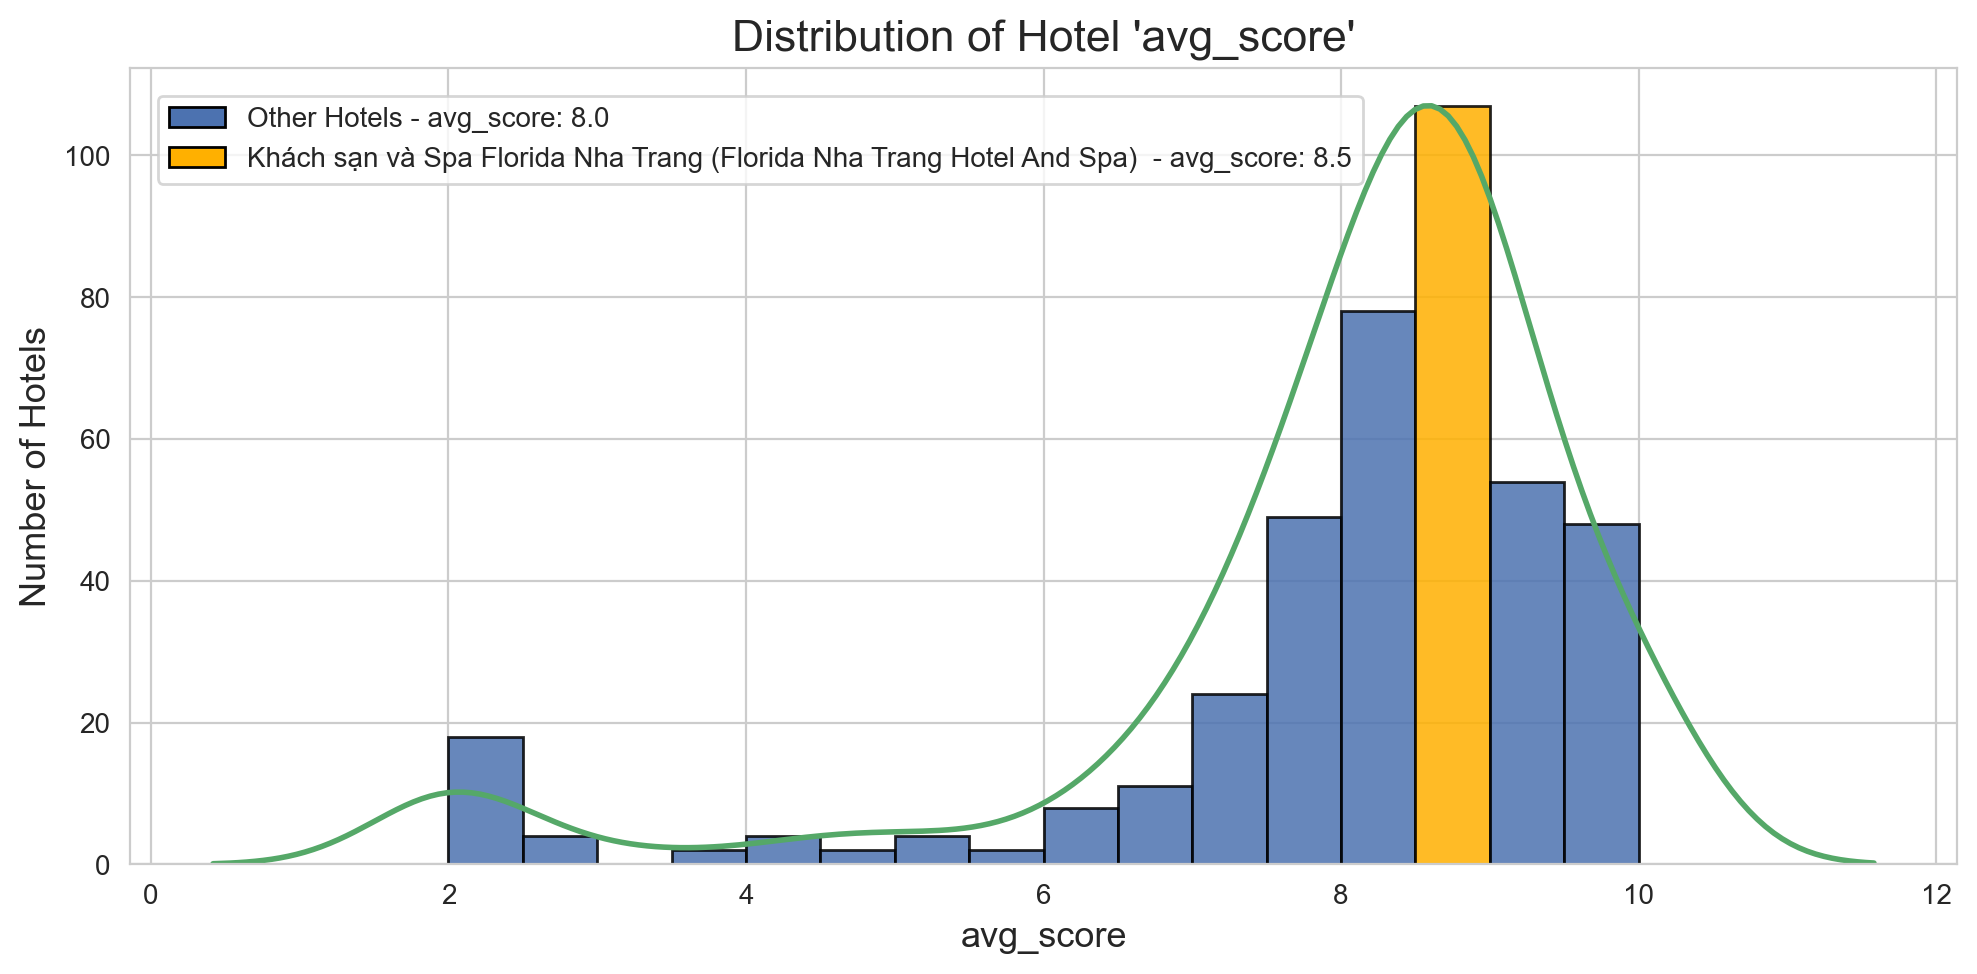

images/
------------------------------
06_insight_overview_hotel_rank


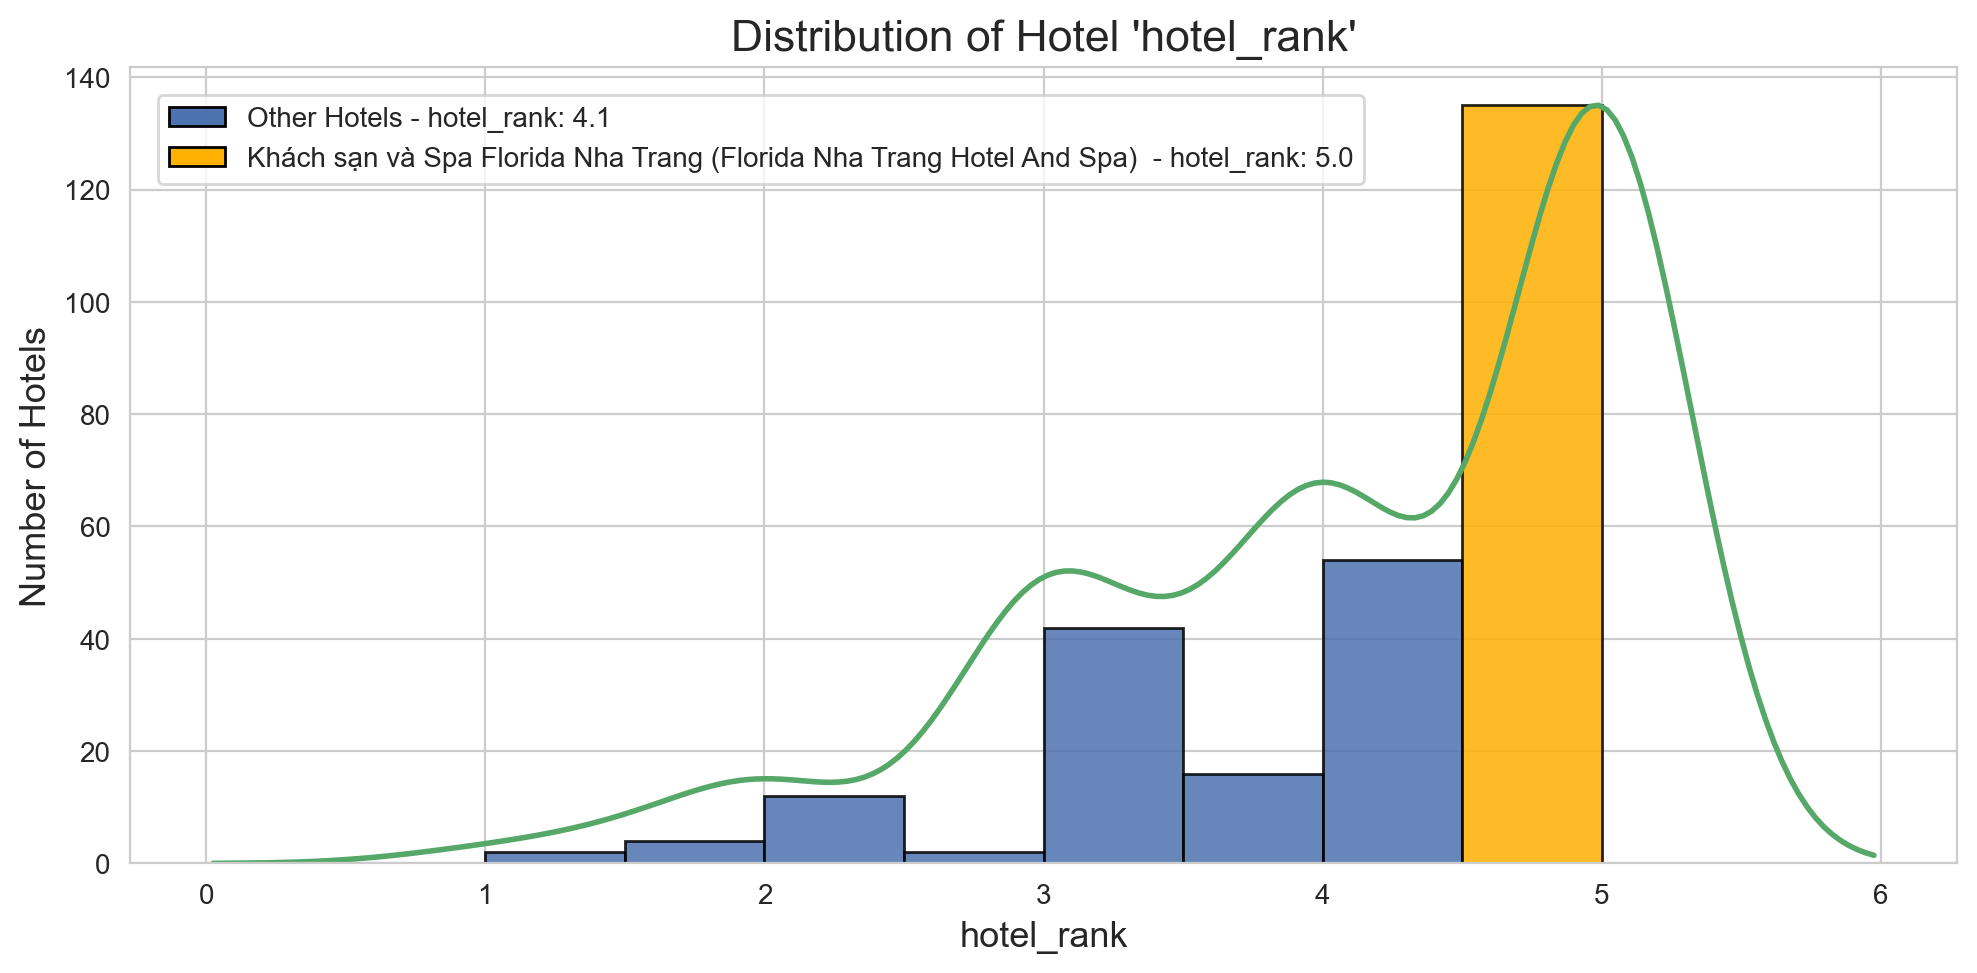

In [115]:
# avg_score & hotel_rank của Hotel được chọn vs. Các Hotel còn lại
hotels_overview = [fn_get_hotel_overview(df_info, hotel_id) for hotel_id in df_info["hotel_id"]]
# hotels_overview = [hotel for hotel in hotels_overview if hotel is not None and pd.notna(hotel["avg_score"])]

# vẽ distribution chart
fn_chart_score_distribution(
    df=pd.DataFrame([hotel for hotel in hotels_overview if hotel is not None and pd.notna(hotel["avg_score"])]),
    score_col="avg_score",
    hotel_id_col="hotel_id",
    selected_hotel_id=search_hotel_id,
    bins_time=2,  # 1 điểm chia vào 2 bins --> 1 bin = 0.5 điểm
    figsize=figsize,
    image_name="05_insight_overview_avg_score",
)

fn_chart_score_distribution(
    df=pd.DataFrame([hotel for hotel in hotels_overview if hotel is not None and pd.notna(hotel["hotel_rank"])]),
    score_col="hotel_rank",
    hotel_id_col="hotel_id",
    selected_hotel_id=search_hotel_id,
    bins_time=2,  # 1 điểm chia vào 2 bins --> 1 bin = 0.5 điểm
    figsize=figsize,
    image_name="06_insight_overview_hotel_rank",
)

#### 7.4.2 Strengths & Weaknesses (theo ratings)
- So sánh từng thuộc tính của 'Hotel được chọn' với Bình quân (mean) các Hotel và tính **diff** = hotel_value - mean_all

In [116]:
rating_cols = ["location","cleanliness","service","facilities","value_for_money","comfort_and_room_quality"]
score_classify_dict = {
    "Strength": 8.5,
    "Neutral": 7.5,
}

In [117]:
# tính toán điểm số
df_diffs = fn_rating_diffs(df=df_info, hotel_id_col="hotel_id", selected_hotel_id=search_hotel_id, rating_cols=rating_cols)
df_diffs = df_diffs.set_index('attr').loc[rating_cols].reset_index() # sort lại trình tự gốc

# phân loại chỉ số: strength / neutral / weakness
df_diffs['score_classify'] = df_diffs['selected_hotel'].apply(lambda x: fn_score_classify(score=x, score_classify_dict=score_classify_dict))

# gắn nhãn "Missing rating" cho hạng mục ko có điểm rating
df_diffs['score_classify'] = df_diffs['score_classify'].fillna("Missing rating")

# show kết quả
display(Markdown(f"### Strengths & Weaknesses | {search_hotel_name}"))
fn_show(df=df_diffs, n=None)

# print nhận xét
for cat in ['Strength', 'Neutral', 'Weakness', "Missing rating"]:
    print(f"{cat}:")
    attrs = df_diffs.loc[df_diffs['score_classify'] == cat, 'attr']
    for attr in attrs:
        print(f"\t+ {attr}")

# save file csv
print('\n')
fn_save_csv(df=df_diffs, folder_path = path + out_path, file_name='11_insight_strengths_weaknesses.csv', header=True, index=True)


### Strengths & Weaknesses | Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)

dataframe: 6 rows x 6 cols


attr  selected_hotel  all_mean  diff  top_percent  \
0                  location             8.5       8.3   0.2         63.6   
1               cleanliness             8.8       8.1   0.7         44.8   
2                   service             8.6       8.3   0.3         59.2   
3                facilities             8.4       7.9   0.5         45.9   
4           value_for_money             8.7       8.2   0.5         49.8   
5  comfort_and_room_quality             NaN       8.3   NaN          NaN   

   score_classify  
0        Strength  
1        Strength  
2        Strength  
3         Neutral  
4        Strength  
5  Missing rating

Strength:
	+ location
	+ cleanliness
	+ service
	+ value_for_money
Neutral:
	+ facilities
Weakness:
Missing rating:
	+ comfort_and_room_quality


data_output/
------------------------------
11_insight_strengths_weaknesses.csv


images/
------------------------------
07_insight_strengths_weaknesses.png


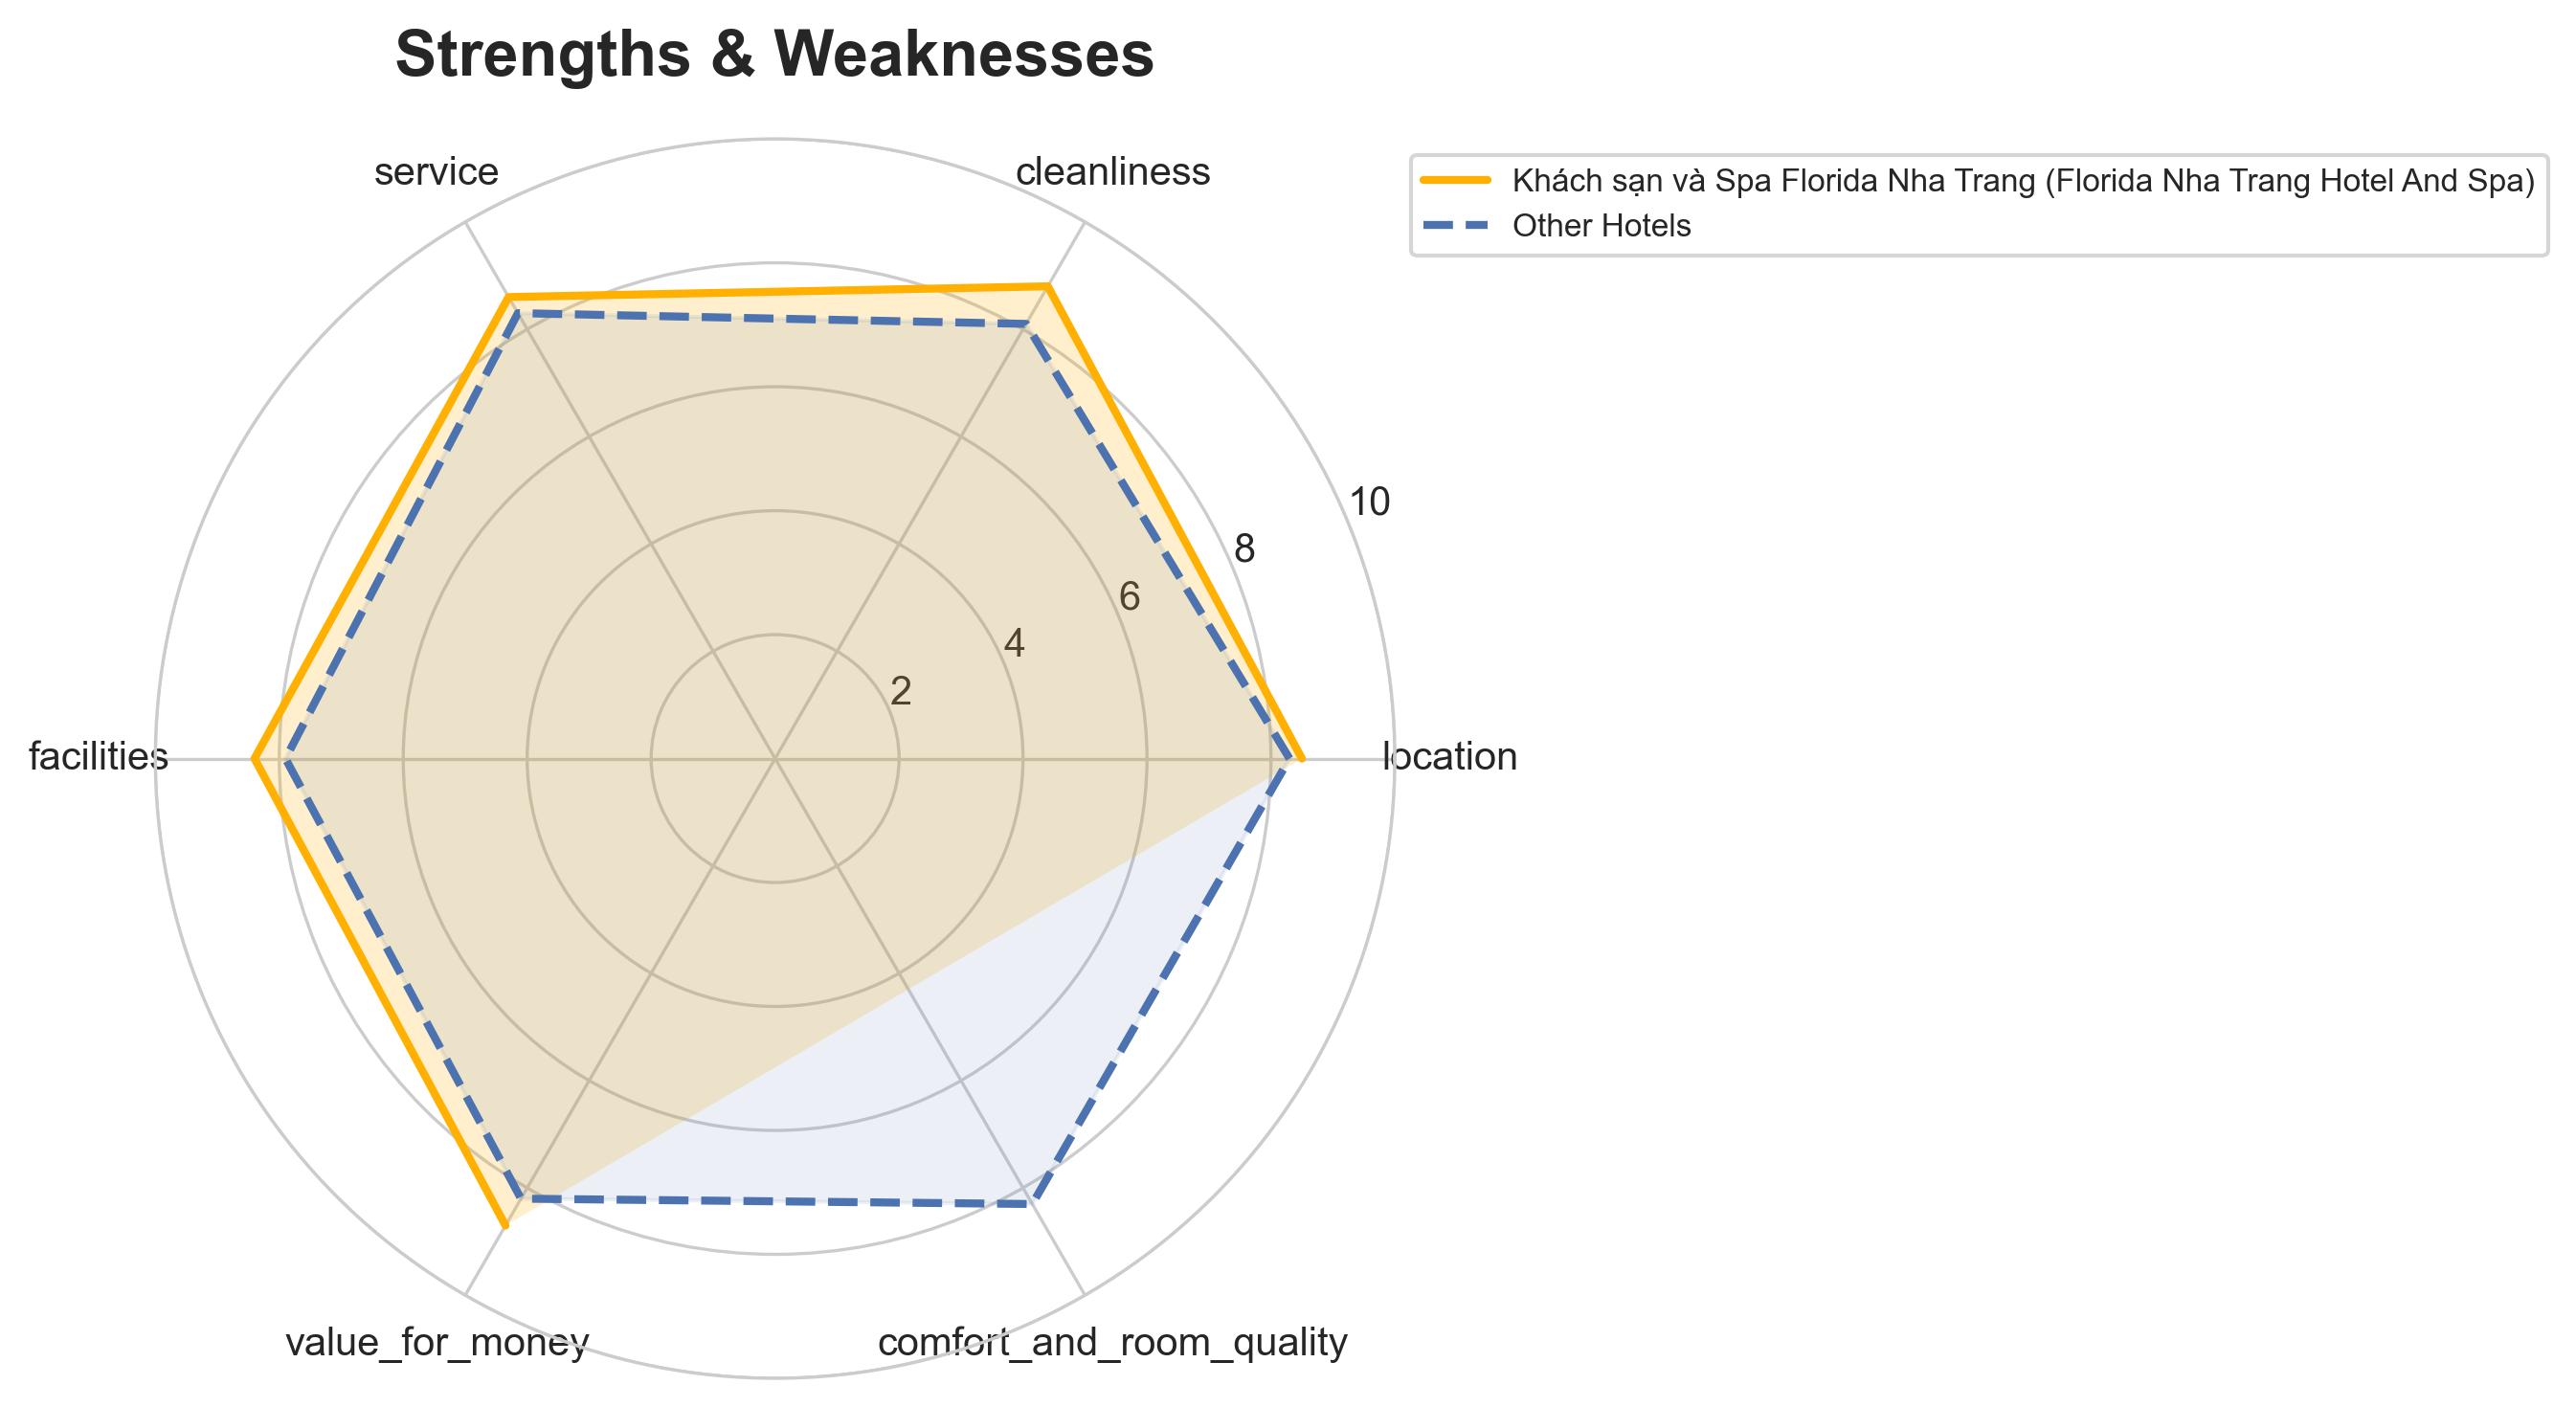

In [118]:
# xem rating bằng radar chart
fn_chart_radar(
    df=df_diffs,
    selected_hotel_name=search_hotel_name,
    figsize=figsize,
    image_name="07_insight_strengths_weaknesses.png",
    dpi=dpi,
)

#### 7.4.3 Customer analysis
- nationality
- group_name, room_type (segments)
- review_month (temporal trends)

images/
------------------------------
08_insight_customer_analysis_selected_hotel.png


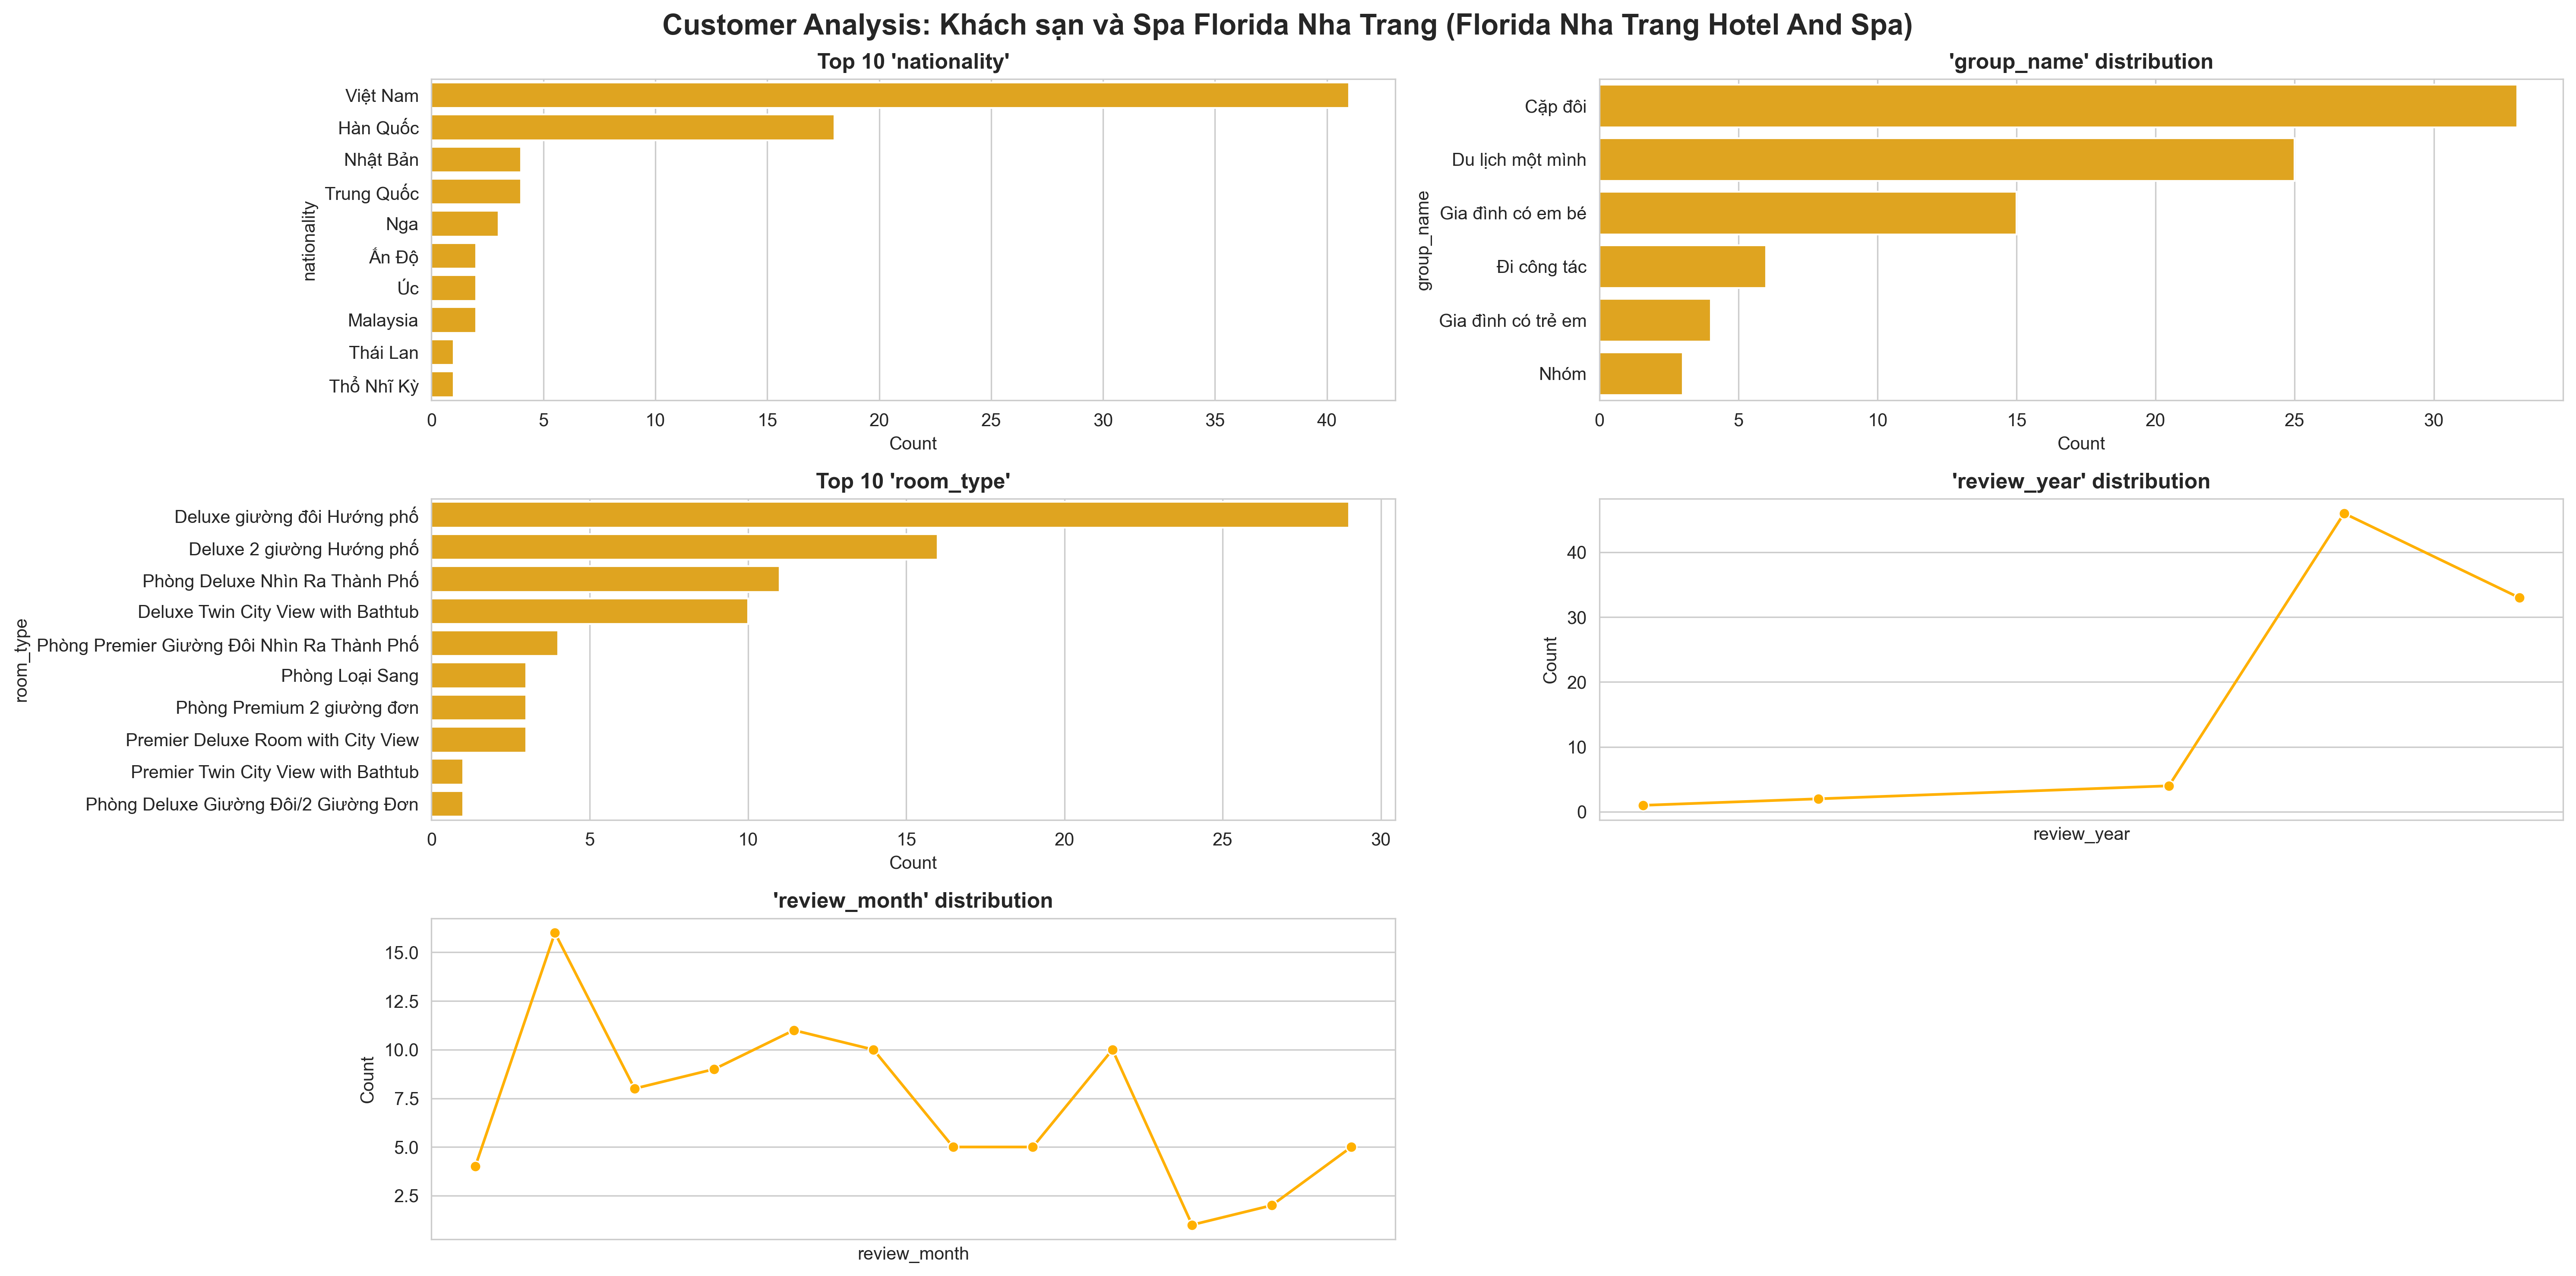

In [119]:
# filter comment của Hotel
df_selected_hotel_comments = df_comments[df_comments['hotel_id'] == search_hotel_id].copy()
df_selected_hotel_comments['review_year'] = pd.to_datetime(df_selected_hotel_comments['stay_month']).dt.year
df_selected_hotel_comments['review_month'] = pd.to_datetime(df_selected_hotel_comments['stay_month']).dt.month

# chọn chart cho cột muốn show
chart_cols_dict = {
    "fn_bar_chart": ["nationality", "group_name", "room_type"],
    "fn_line_timeseries_chart": ["review_year", "review_month"],
}

# show chart minh họa cho Customer Analysis
fn_chart_customer_analysis(
    df=df_selected_hotel_comments,
    chart_cols_dict=chart_cols_dict,
    selected_hotel_name = search_hotel_name,
    # color=sns.color_palette("Set1")[0],
    color = '#FFB000',
    figsize=(figsize[0] * 2, figsize[1] * 2),
    dpi=dpi,
    image_name="08_insight_customer_analysis_selected_hotel.png",
)

In [120]:
for cols in chart_cols_dict.values():
    for col in cols:
        df_temp = df_selected_hotel_comments[col].value_counts(normalize=False).rename_axis(col).reset_index(name='count')
        df_temp['percent'] = (df_temp['count'] / df_temp['count'].sum() * 100).round(1)
        display(df_temp)

nationality  count  percent
0         Việt Nam     41     47.7
1         Hàn Quốc     18     20.9
2       Trung Quốc      4      4.7
3         Nhật Bản      4      4.7
4              Nga      3      3.5
5            Ấn Độ      2      2.3
6               Úc      2      2.3
7         Malaysia      2      2.3
8       Thổ Nhĩ Kỳ      1      1.2
9         Thái Lan      1      1.2
10     New Zealand      1      1.2
11          Canada      1      1.2
12            Pháp      1      1.2
13              Bỉ      1      1.2
14  Vương quốc Anh      1      1.2
15     Tây Ban Nha      1      1.2
16          Hoa Kỳ      1      1.2
17       Hồng Kông      1      1.2

group_name  count  percent
0             Cặp đôi     33     38.4
1    Du lịch một mình     25     29.1
2   Gia đình có em bé     15     17.4
3         Đi công tác      6      7.0
4  Gia đình có trẻ em      4      4.7
5                Nhóm      3      3.5

room_type  count  percent
0                  Deluxe giường đôi Hướng phố     29     33.7
1                    Deluxe 2 giường Hướng phố     16     18.6
2               Phòng Deluxe Nhìn Ra Thành Phố     11     12.8
3           Deluxe Twin City View with Bathtub     10     11.6
4   Phòng Premier Giường Đôi Nhìn Ra Thành Phố      4      4.7
5                              Phòng Loại Sang      3      3.5
6                   Phòng Premium 2 giường đơn      3      3.5
7           Premier Deluxe Room with City View      3      3.5
8          Premier Twin City View with Bathtub      1      1.2
9         Phòng Deluxe Giường Đôi/2 Giường Đơn      1      1.2
10        DELUXE DOUBLE OR TWIN ROOM,CITY VIEW      1      1.2
11                           Deluxe, City View      1      1.2
12            Phòng Được sắp xếp tùy ý khi đến      1      1.2
13                         Phòng Đôi Loại Sang      1      1.2
14           Phòng Loại Sang Senior Giường Đôi      1      1.2

review_year  count  percent
0         2023     46     53.5
1         2024     33     38.4
2         2022      4      4.7
3         2020      2      2.3
4         2019      1      1.2

review_month  count  percent
0              2     16     18.6
1              5     11     12.8
2              6     10     11.6
3              9     10     11.6
4              4      9     10.5
5              3      8      9.3
6              7      5      5.8
7              8      5      5.8
8             12      5      5.8
9              1      4      4.7
10            11      2      2.3
11            10      1      1.2

images/
------------------------------
13_insight_customer_analysis_all.png


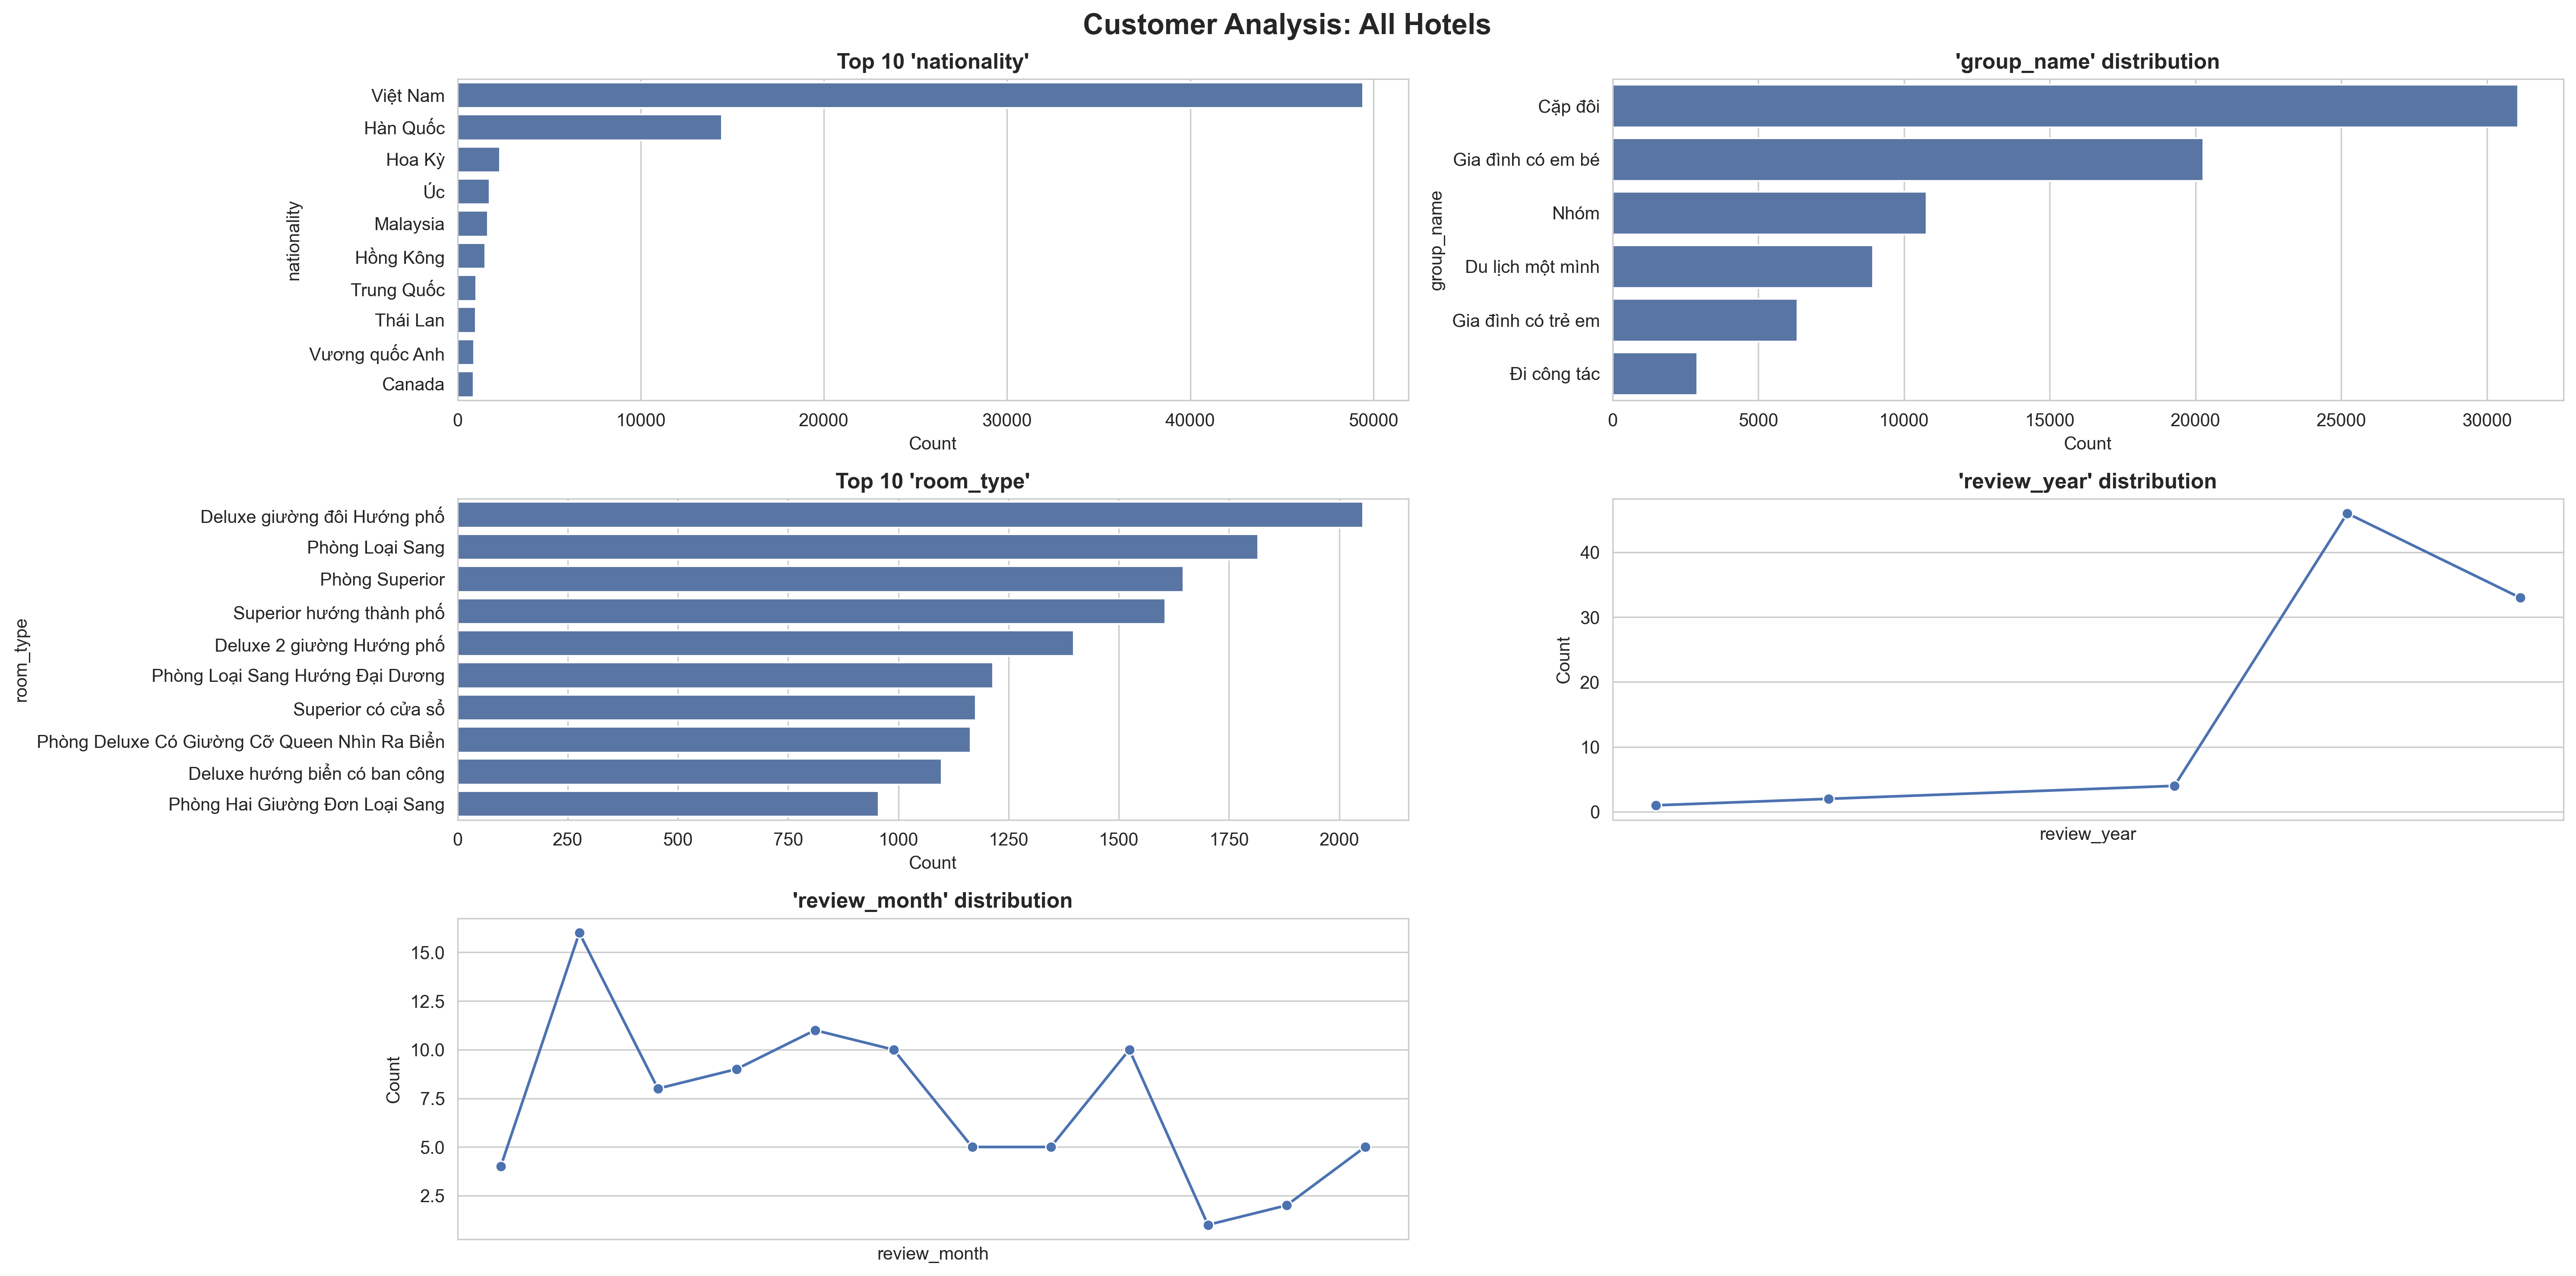

In [121]:
# filter comment của All Hotel
df_all_comments = df_comments.copy()
df_all_comments['review_year'] = pd.to_datetime(df_selected_hotel_comments['stay_month']).dt.year
df_all_comments['review_month'] = pd.to_datetime(df_selected_hotel_comments['stay_month']).dt.month

# show chart minh họa cho Customer Analysis
fn_chart_customer_analysis(
    df=df_all_comments,
    chart_cols_dict=chart_cols_dict,
    selected_hotel_name = 'All Hotels',
    # color=sns.color_palette("Set1")[0],
    color = '#4C72B0',
    figsize=(figsize[0] * 2, figsize[1] * 2),
    dpi=dpi,
    image_name="13_insight_customer_analysis_all.png",
)

#### 7.4.4 Text Mining on Reviews: Positive / Negative Keywords

In [122]:
# xem lại lượng review và cách đánh điểm của reviewer
display(Markdown(f"### Score distribution | All hotel"))
display(fn_score_stats(df=df_comments, score_col="score", score_level_col="score_level"))

display(Markdown(f"### Score distribution | {search_hotel_name}"))
display(fn_score_stats(df=df_selected_hotel_comments, score_col="score", score_level_col="score_level"))

### Score distribution | All hotel

score_level  count  count_pct      mean  min   q1    q2    q3   max
0  Trên cả tuyệt vời  58051       72.3  9.823586  9.0  9.6  10.0  10.0  10.0
1          Tuyệt vời  14814       18.4  8.414999  8.0  8.0   8.4   8.8   8.8
2            Rất tốt   4356        5.4  7.437006  7.0  7.2   7.6   7.6   7.7
3           Hài Lòng   3093        3.9  6.593113  6.3  6.4   6.4   6.8   6.8

### Score distribution | Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)

score_level  count  count_pct      mean  min   q1    q2    q3   max
0  Trên cả tuyệt vời     56       65.1  9.871429  9.2  9.9  10.0  10.0  10.0
1          Tuyệt vời     20       23.3  8.440000  8.0  8.0   8.4   8.8   8.8
2            Rất tốt      6        7.0  7.400000  7.2  7.2   7.4   7.6   7.6
3           Hài Lòng      4        4.7  6.700000  6.4  6.7   6.8   6.8   6.8

images/
------------------------------
09_insight_textmining_score_distribution


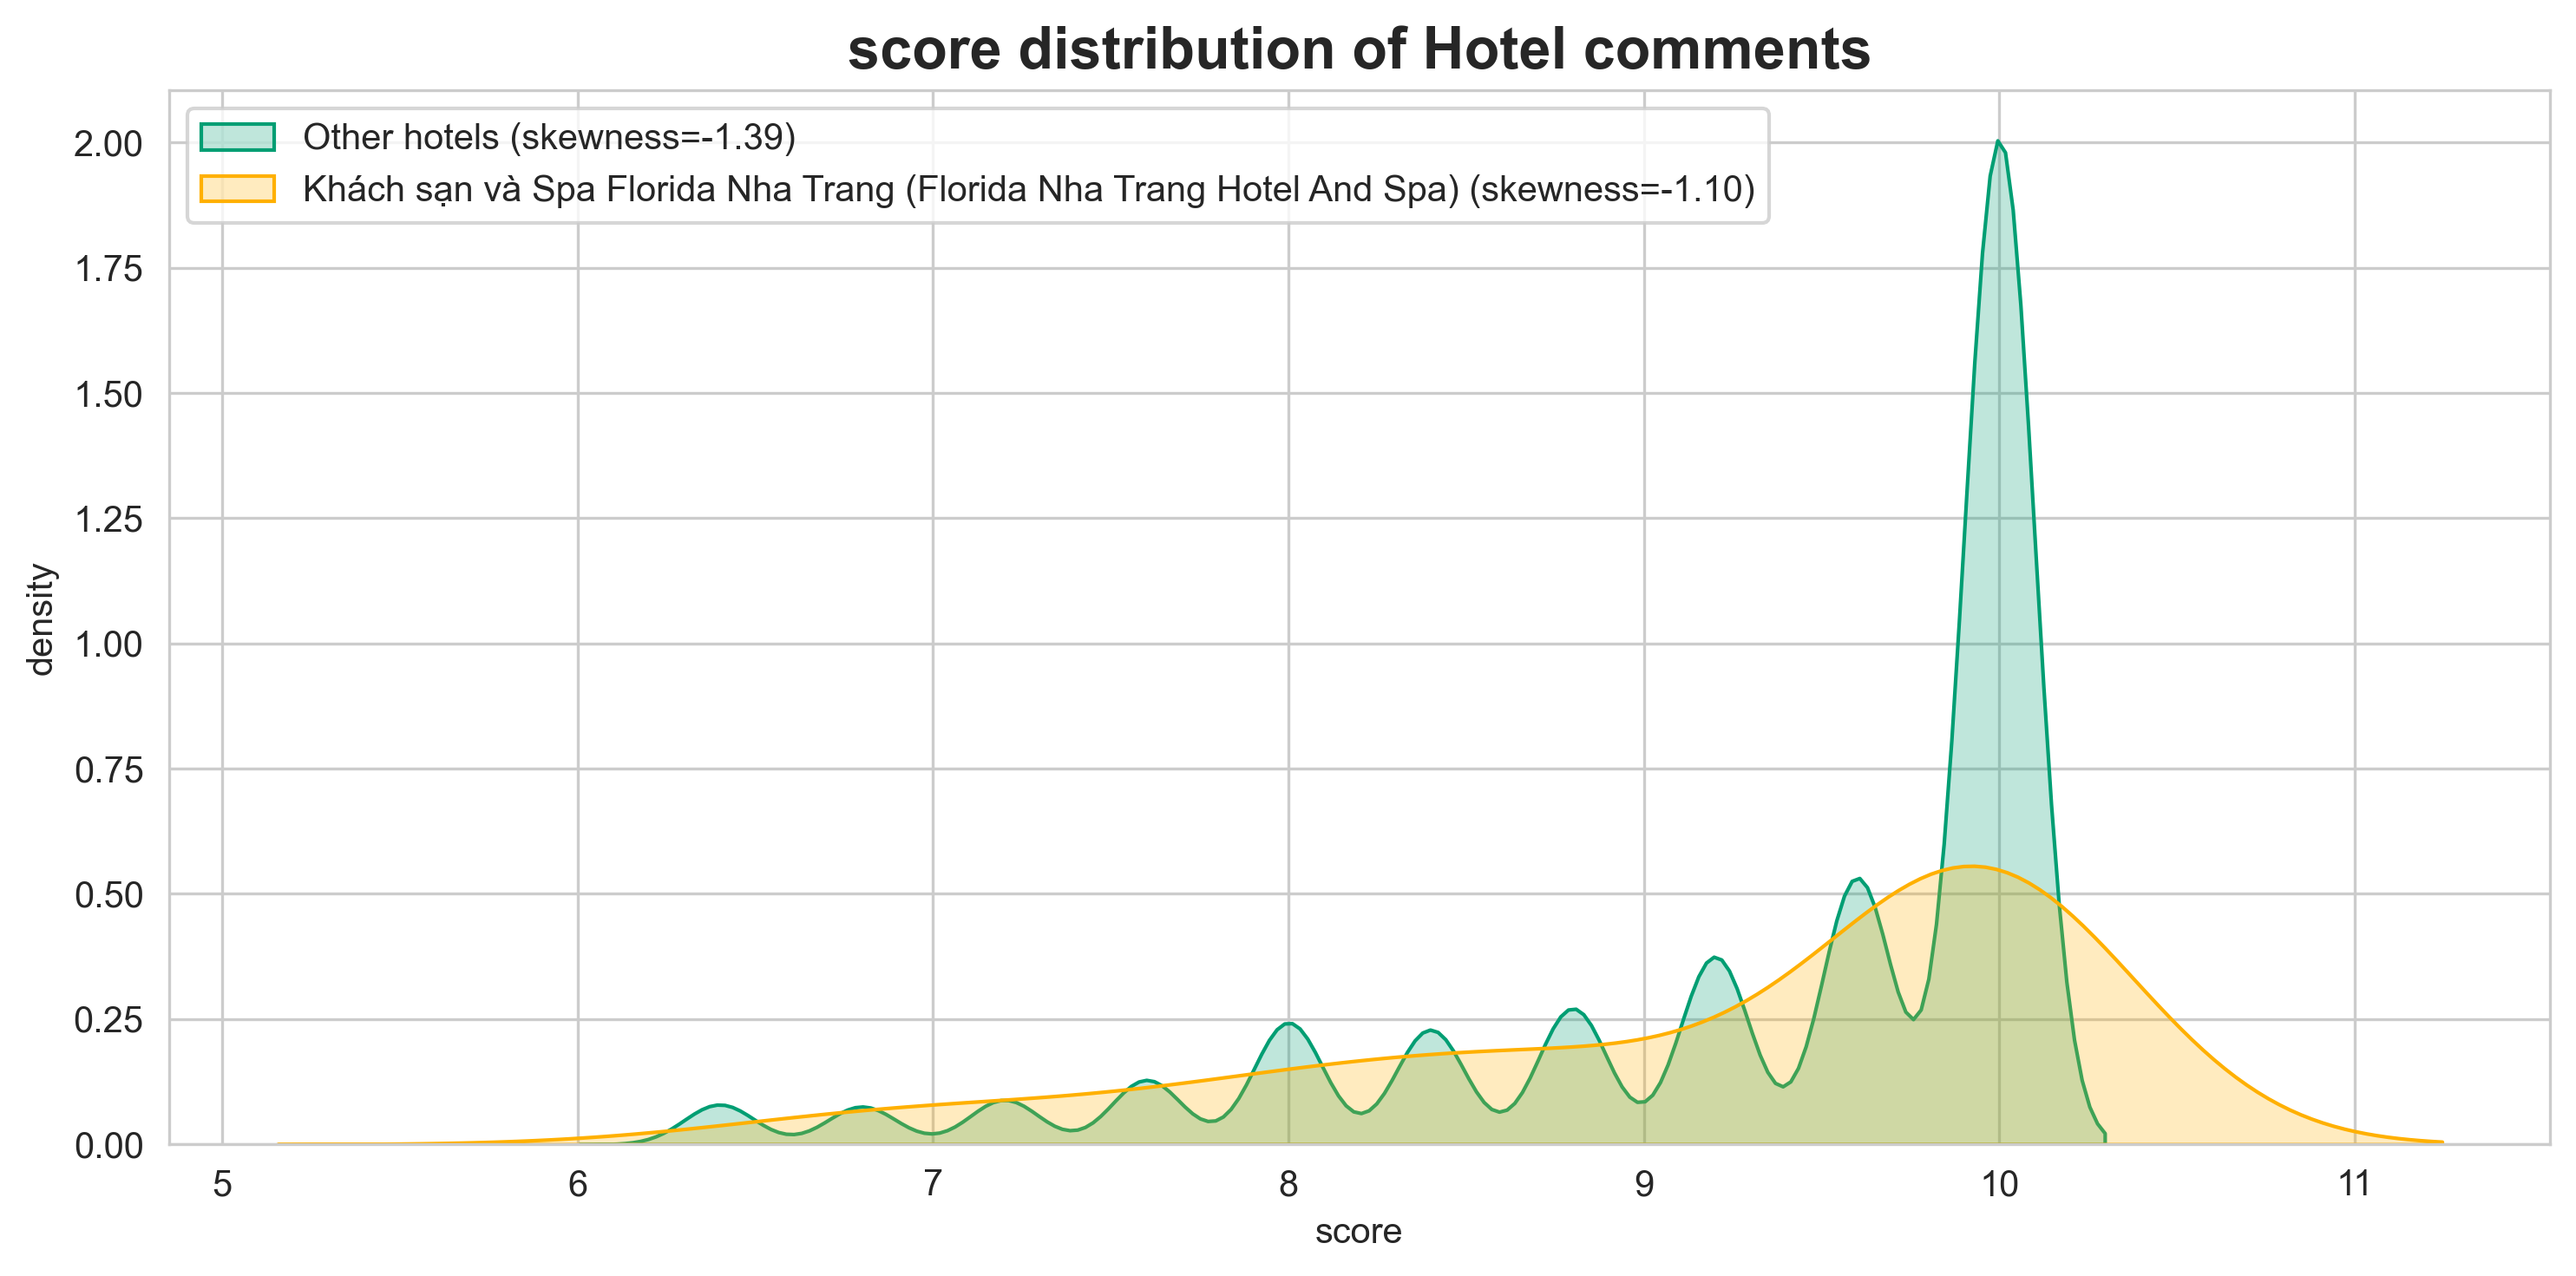

In [123]:
# vẽ phân phối của score
from scipy.stats import skew
plt.figure(figsize=figsize, dpi=dpi)
sns.kdeplot(
    df_comments["score"], 
    fill=True, 
    color="#009E73", 
    linewidth=1, 
    label=f"Other hotels (skewness={skew(df_comments['score'].dropna()):.2f})"
)
sns.kdeplot(
    df_selected_hotel_comments["score"], 
    fill=True, 
    color="#FFB000", 
    linewidth=1, 
    label=f"{search_hotel_name} (skewness={skew(df_selected_hotel_comments['score'].dropna()):.2f})"
)
plt.legend()
plt.title("score distribution of Hotel comments", fontsize=16, fontweight="bold")
plt.xlabel("score")
plt.ylabel("density")
plt.tight_layout()
fn_save_image(path = path + images_path, image_name = "09_insight_textmining_score_distribution", dpi=dpi)
plt.show()

| Quan sát | Nhận xét |
|--------------------------------------------------|---------------------------------------------------------------------------------------------|
| Phân bố review score cực kỳ lệch về phía cao  |- Phần lớn đánh giá có điểm rất cao, cho thấy phân phối lệch về phía tích cực (thiên lệch chọn mẫu).<br>- Peak rõ ràng tại điểm 10, cho thấy đa số khách cho điểm cao, review tích cực, bias nặng, khó khai thác insight từ review tiêu cực. |
| Hành vi đánh giá | Khách hàng chủ yếu để lại đánh giá khi hài lòng, dẫn đến tỷ lệ điểm cao bị đại diện quá mức. |
| Phân loại score_level | score_level được xác định như sau: <br>`Trên cả tuyệt vời`: score `≥ 9`<br>`Tuyệt vời`: score `≥ 8`<br>`Rất tốt`: score `≥ 7`<br>`Hài lòng`: score `≥ 6`<br>Và hiện tại chưa có đánh giá nào có score < 6.0|

In [124]:
display(Markdown(f"### Score distribution | All hotel"))
display(fn_score_stats(df=df_comments, score_col="score", score_level_col="score_level")[['score_level', 'count', 'count_pct', 'min']])

### Score distribution | All hotel

score_level  count  count_pct  min
0  Trên cả tuyệt vời  58051       72.3  9.0
1          Tuyệt vời  14814       18.4  8.0
2            Rất tốt   4356        5.4  7.0
3           Hài Lòng   3093        3.9  6.3

| Gom nhóm                | score threshold mới                | pct | classification |
|----------------------------|----------------------------|:-------------:|:--------------:|
| Trên cả tuyệt vời + Tuyệt vời | ≥ 8.0                      |     90.7%      | Positive       |
| Rất tốt + Hài Lòng            | < 8.0                      |      9.3%     | Negative       |

**Lý do phân nhóm:**  
Để giảm thiểu ảnh hưởng của việc mất cân bằng dữ liệu (imbalance):<br>- Nhóm `Negative` được chọn sao cho chiếm khoảng 10% tổng số đánh giá, gồm các mức `Rất tốt` và `Hài Lòng`.<br>- Nhóm `Positive` gồm `Trên cả tuyệt vời` và `Tuyệt vời`, chiếm khoảng 90%.

In [125]:
# check NULL của các comments
df_comments[['title', 'body']].isnull().sum()

title     0
body     42
dtype: int64

In [126]:
# trích dữ liệu comment để xử lý từ khóa cho comment positive / negative
score_threshold = 8.0
df_nev_pos_comments = df_comments[['num', 'hotel_id', 'score', 'score_level', 'title', 'body']].copy()

# apply score_threshold để phân loại positive / negative thủ công
df_nev_pos_comments['classify'] = df_nev_pos_comments['score'].apply(lambda x: 'pos' if x >= score_threshold else 'nev')

# do có NULL ở body nên dùng title trộn chung với body để tạo ra text mới
df_nev_pos_comments['body_new'] = df_nev_pos_comments['title'].fillna('') + ' ' + df_nev_pos_comments['body'].fillna('')
df_nev_pos_comments = df_nev_pos_comments.drop(columns=['title', 'body'])

fn_show(df=df_nev_pos_comments, n=n_rows)

# save csv file
fn_save_csv(df=df_nev_pos_comments, folder_path = path + out_path, file_name = '12_insight_textmining_comments_classification.csv', header=True, index=True)

dataframe: 80,314 rows x 6 cols


num hotel_id  score        score_level classify  \
0    1      1_1   10.0  Trên cả tuyệt vời      pos   
1    2      1_1   10.0  Trên cả tuyệt vời      pos   
2    3      1_1    9.2  Trên cả tuyệt vời      pos   

                                            body_new  
0  Cao nhất‼︎” Tôi đã ở cùng chủ nhân trong 4 đêm...  
1  Tháng 8” Lựa chọn Mường Thanh vì giá cả phù hợ...  
2  Du lịch tại Nha Trang” Lần này đến với Nha Tra...

data_output/
------------------------------
12_insight_textmining_comments_classification.csv


In [127]:
# xử lý token
df_nev_pos_comments['body_new_clean'] = df_nev_pos_comments['body_new'].apply(
    lambda x: fn_clean_tokens(
        text=str(x),
        dict_list=[emoji, teencode, engvie],
        stopword=stopword_vie,
        wrongword=wrongword,
        remove_number=True,
        remove_punctuation=True,
        remove_vie_tone=False,
        lower=True,
    )
)

In [128]:
# sau xử lý token
fn_show(df=df_nev_pos_comments, n=n_rows)

# save csv file
fn_save_csv(df=df_nev_pos_comments, folder_path = path + out_path, file_name = '13_insight_textmining_comments_classification_token_cleaned.csv', header=True, index=True)

dataframe: 80,314 rows x 7 cols


num hotel_id  score        score_level classify  \
0    1      1_1   10.0  Trên cả tuyệt vời      pos   
1    2      1_1   10.0  Trên cả tuyệt vời      pos   
2    3      1_1    9.2  Trên cả tuyệt vời      pos   

                                            body_new  \
0  Cao nhất‼︎” Tôi đã ở cùng chủ nhân trong 4 đêm...   
1  Tháng 8” Lựa chọn Mường Thanh vì giá cả phù hợ...   
2  Du lịch tại Nha Trang” Lần này đến với Nha Tra...   

                                      body_new_clean  
0  [nhất‼︎”, chủ, nhân, đêm, nhân, viên, thân, th...  
1  [8”, lựa, mường, giá, phù, hợp, online, ưu, đã...  
2  [lịch, trang”, sách, phòng, sạn, mường, sạn, đ...

data_output/
------------------------------
13_insight_textmining_comments_classification_token_cleaned.csv


In [129]:
# TOP words
topword_N = 50

all_topword_nev = fn_topwords(df=df_nev_pos_comments, col='body_new_clean', topN=topword_N, filter='nev')
all_topword_pos = fn_topwords(df=df_nev_pos_comments, col='body_new_clean', topN=topword_N, filter='pos')
selected_hotel_topword_nev = fn_topwords(df=df_nev_pos_comments[df_nev_pos_comments['hotel_id'] == search_hotel_id], col='body_new_clean', topN=topword_N, filter='nev')
selected_hotel_topword_pos = fn_topwords(df=df_nev_pos_comments[df_nev_pos_comments['hotel_id'] == search_hotel_id], col='body_new_clean', topN=topword_N, filter='pos')

# Save csv file
print('\n'); fn_save_csv(df=all_topword_nev, folder_path = path + out_path, file_name = '14_insight_textmining_comments_top_all_nev.csv', header=True, index=True)
print('\n'); fn_save_csv(df=all_topword_pos, folder_path = path + out_path, file_name = '15_insight_textmining_comments_top_all_pos.csv', header=True, index=True)
print('\n'); fn_save_csv(df=selected_hotel_topword_nev, folder_path = path + out_path, file_name = '16_insight_textmining_comments_top_selected_hotel_nev.csv', header=True, index=True)
print('\n'); fn_save_csv(df=selected_hotel_topword_pos, folder_path = path + out_path, file_name = '17_insight_textmining_comments_top_selected_hotel_pos.csv', header=True, index=True)



data_output/
------------------------------
14_insight_textmining_comments_top_all_nev.csv


data_output/
------------------------------
15_insight_textmining_comments_top_all_pos.csv


data_output/
------------------------------
16_insight_textmining_comments_top_selected_hotel_nev.csv


data_output/
------------------------------
17_insight_textmining_comments_top_selected_hotel_pos.csv


### Top word | All Hotels

images/
------------------------------
09_insight_textmining_wordcloud_all_nev.png


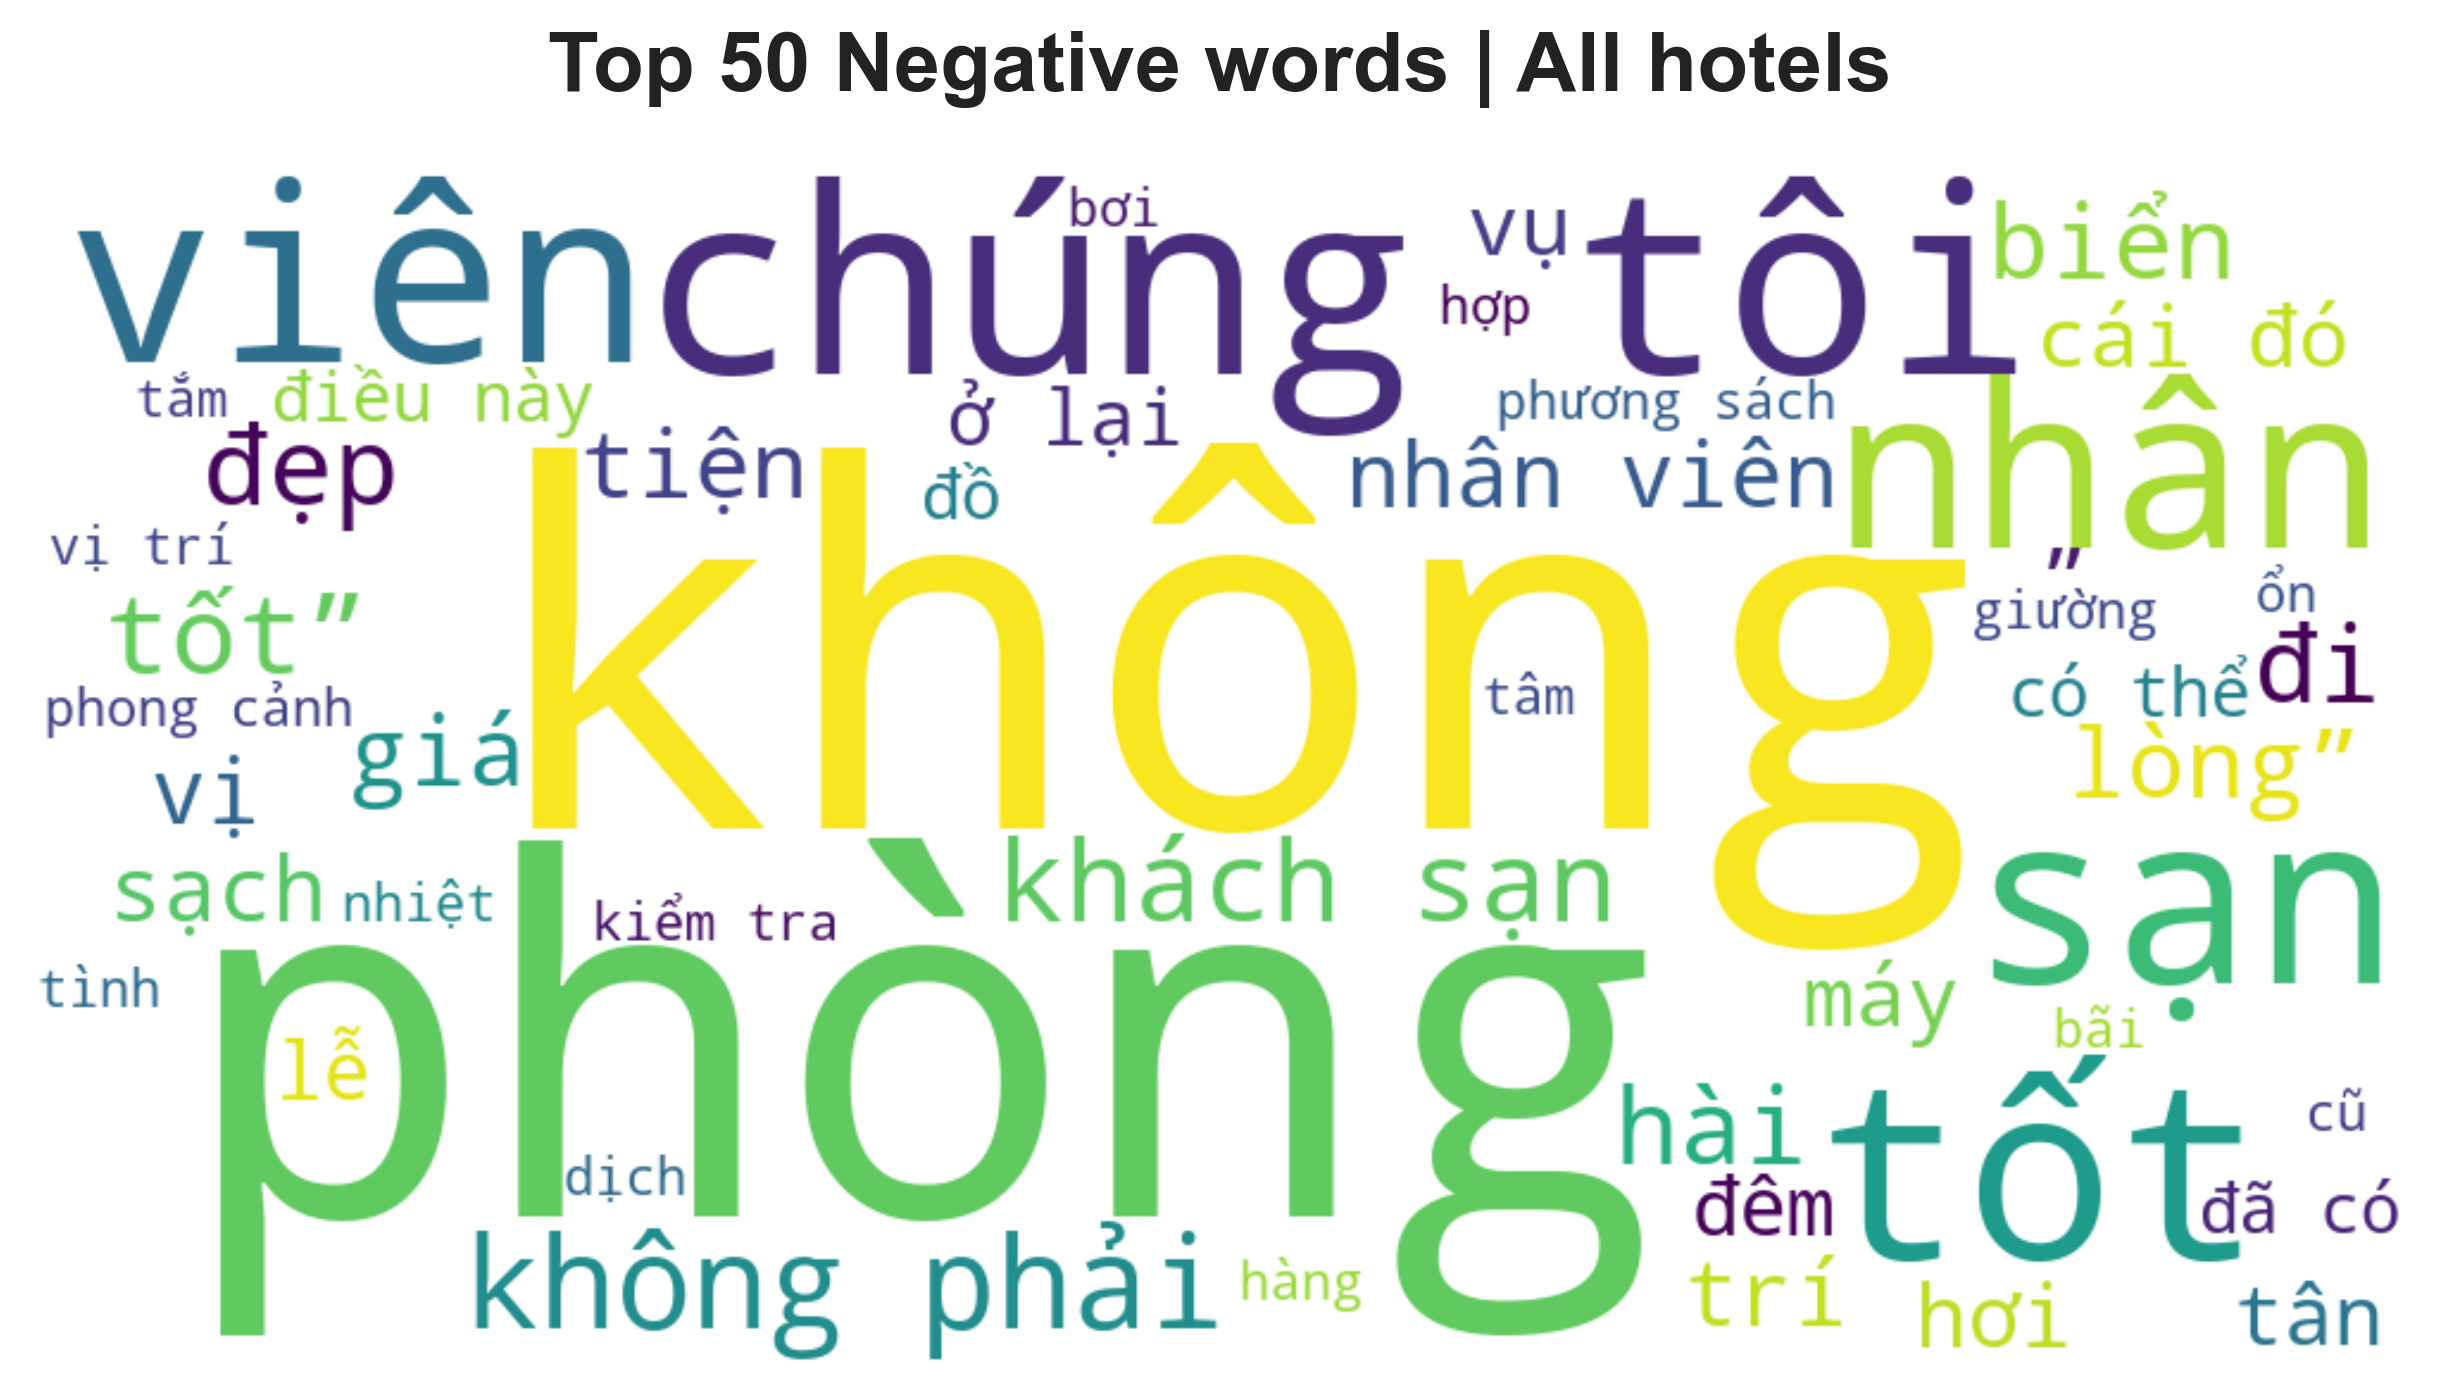

images/
------------------------------
10_insight_textmining_wordcloud_all_pos.png


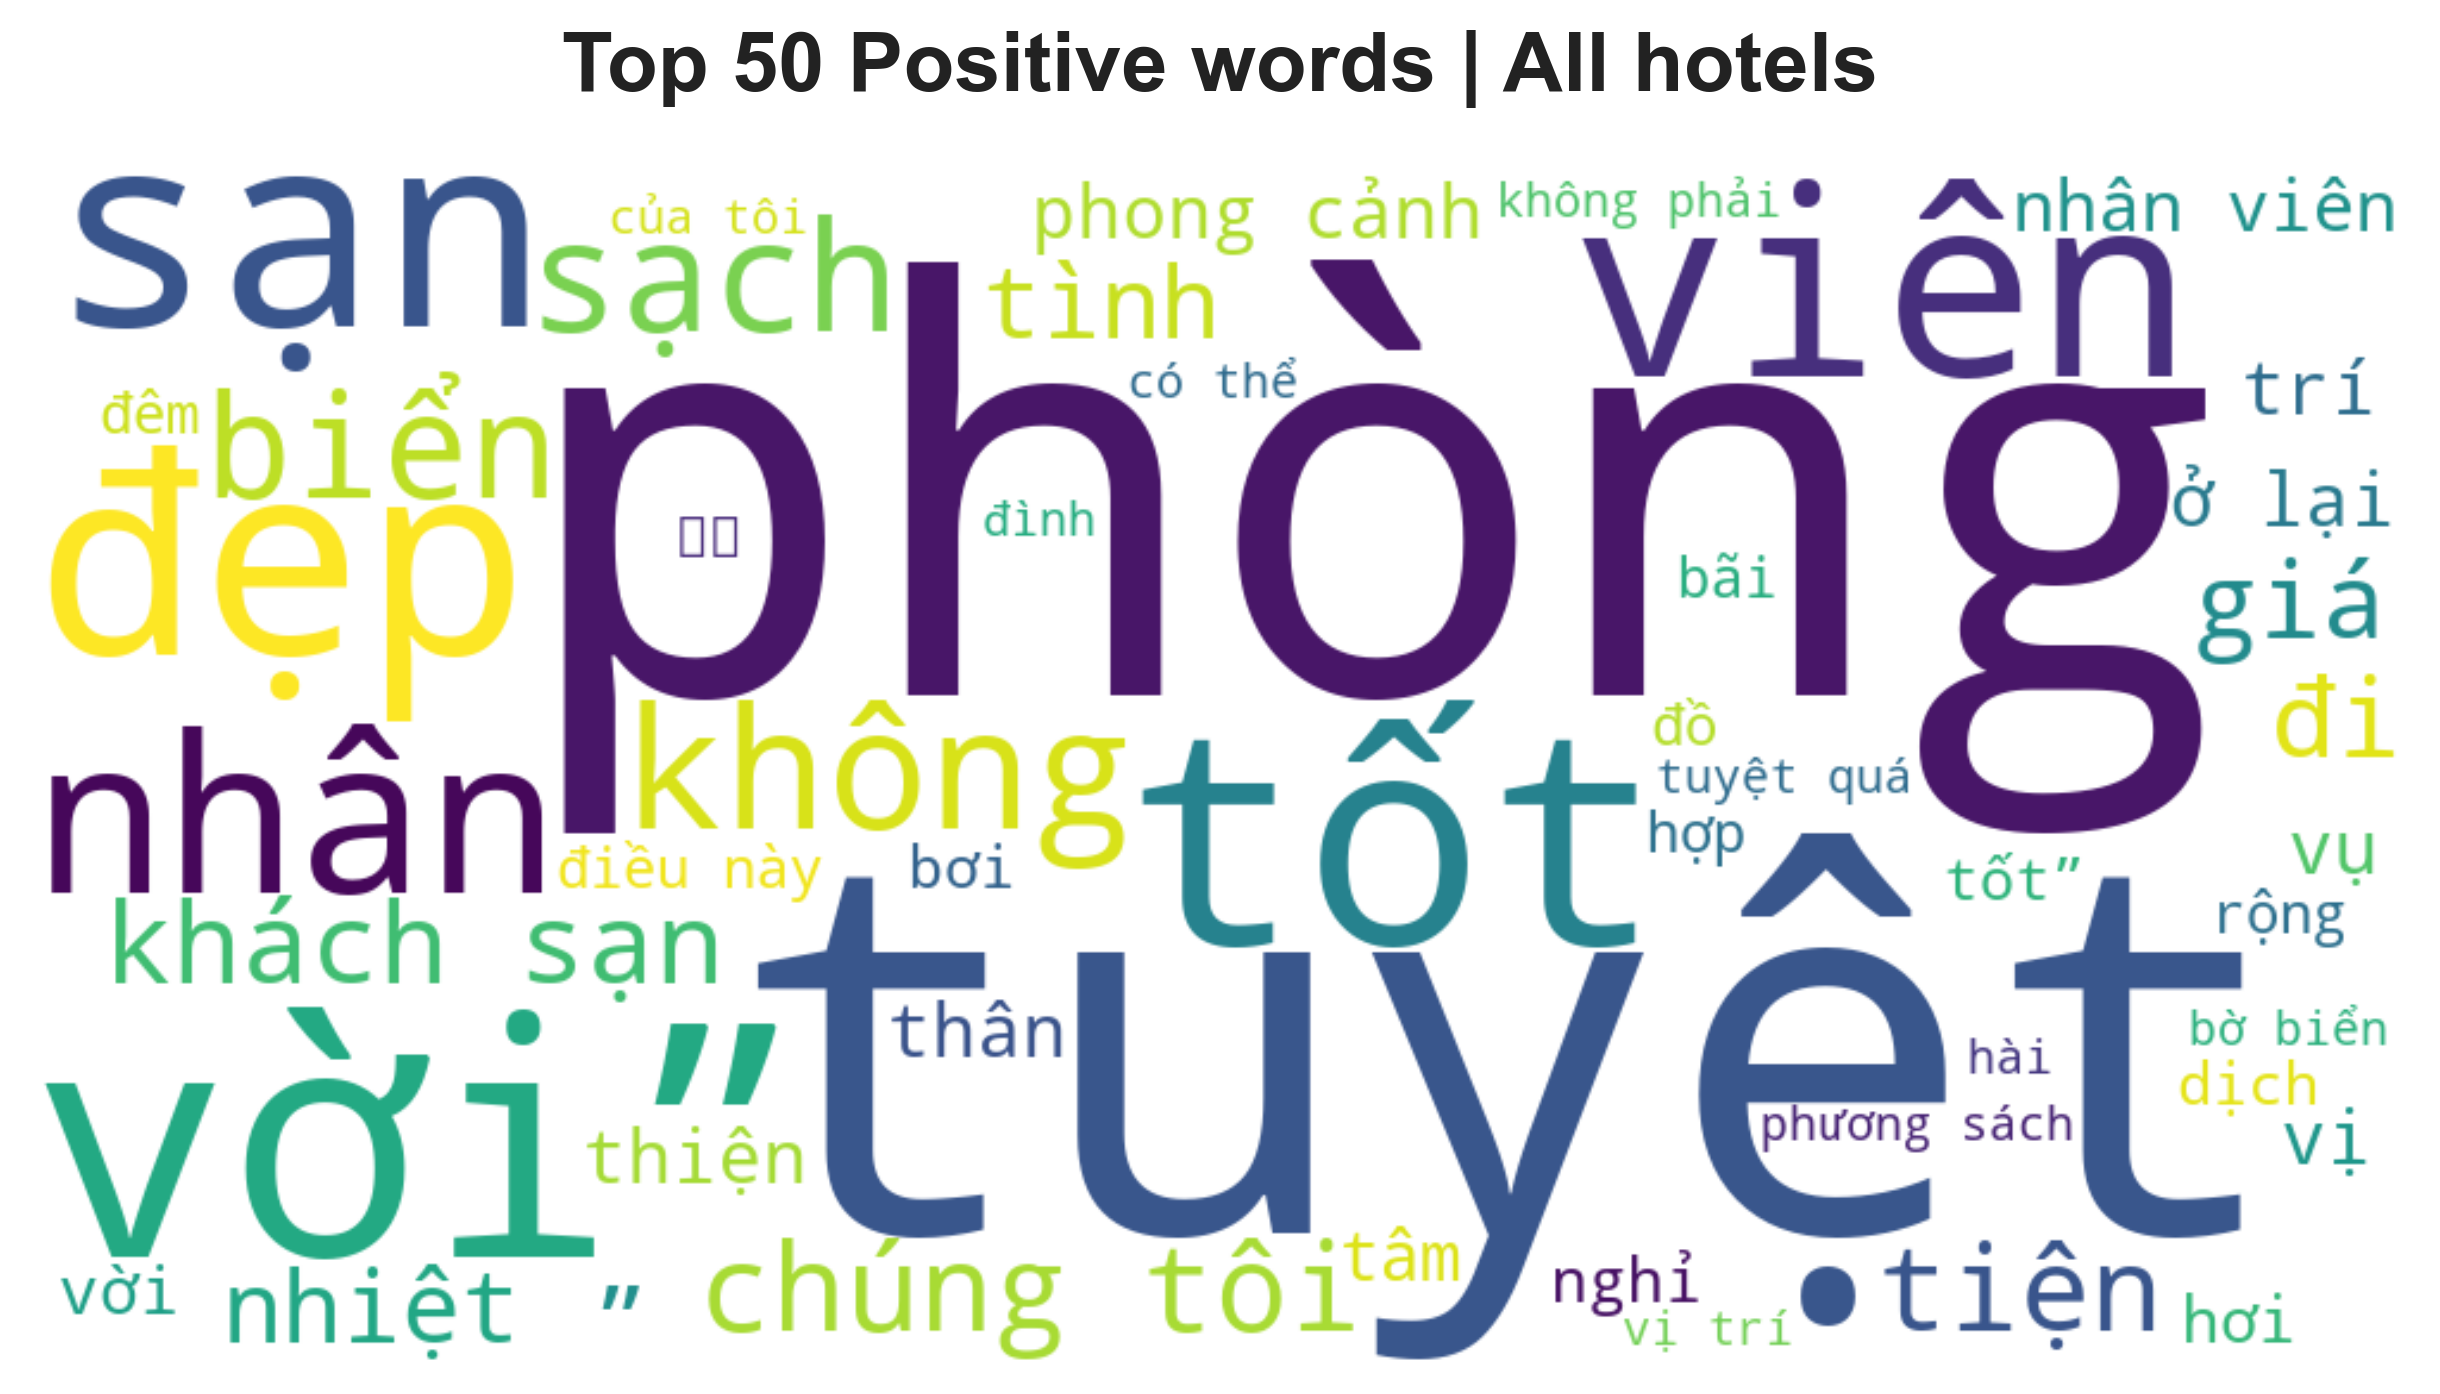

### Top word | Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)

images/
------------------------------
11_insight_textmining_wordcloud_selected_hotel_nev.png


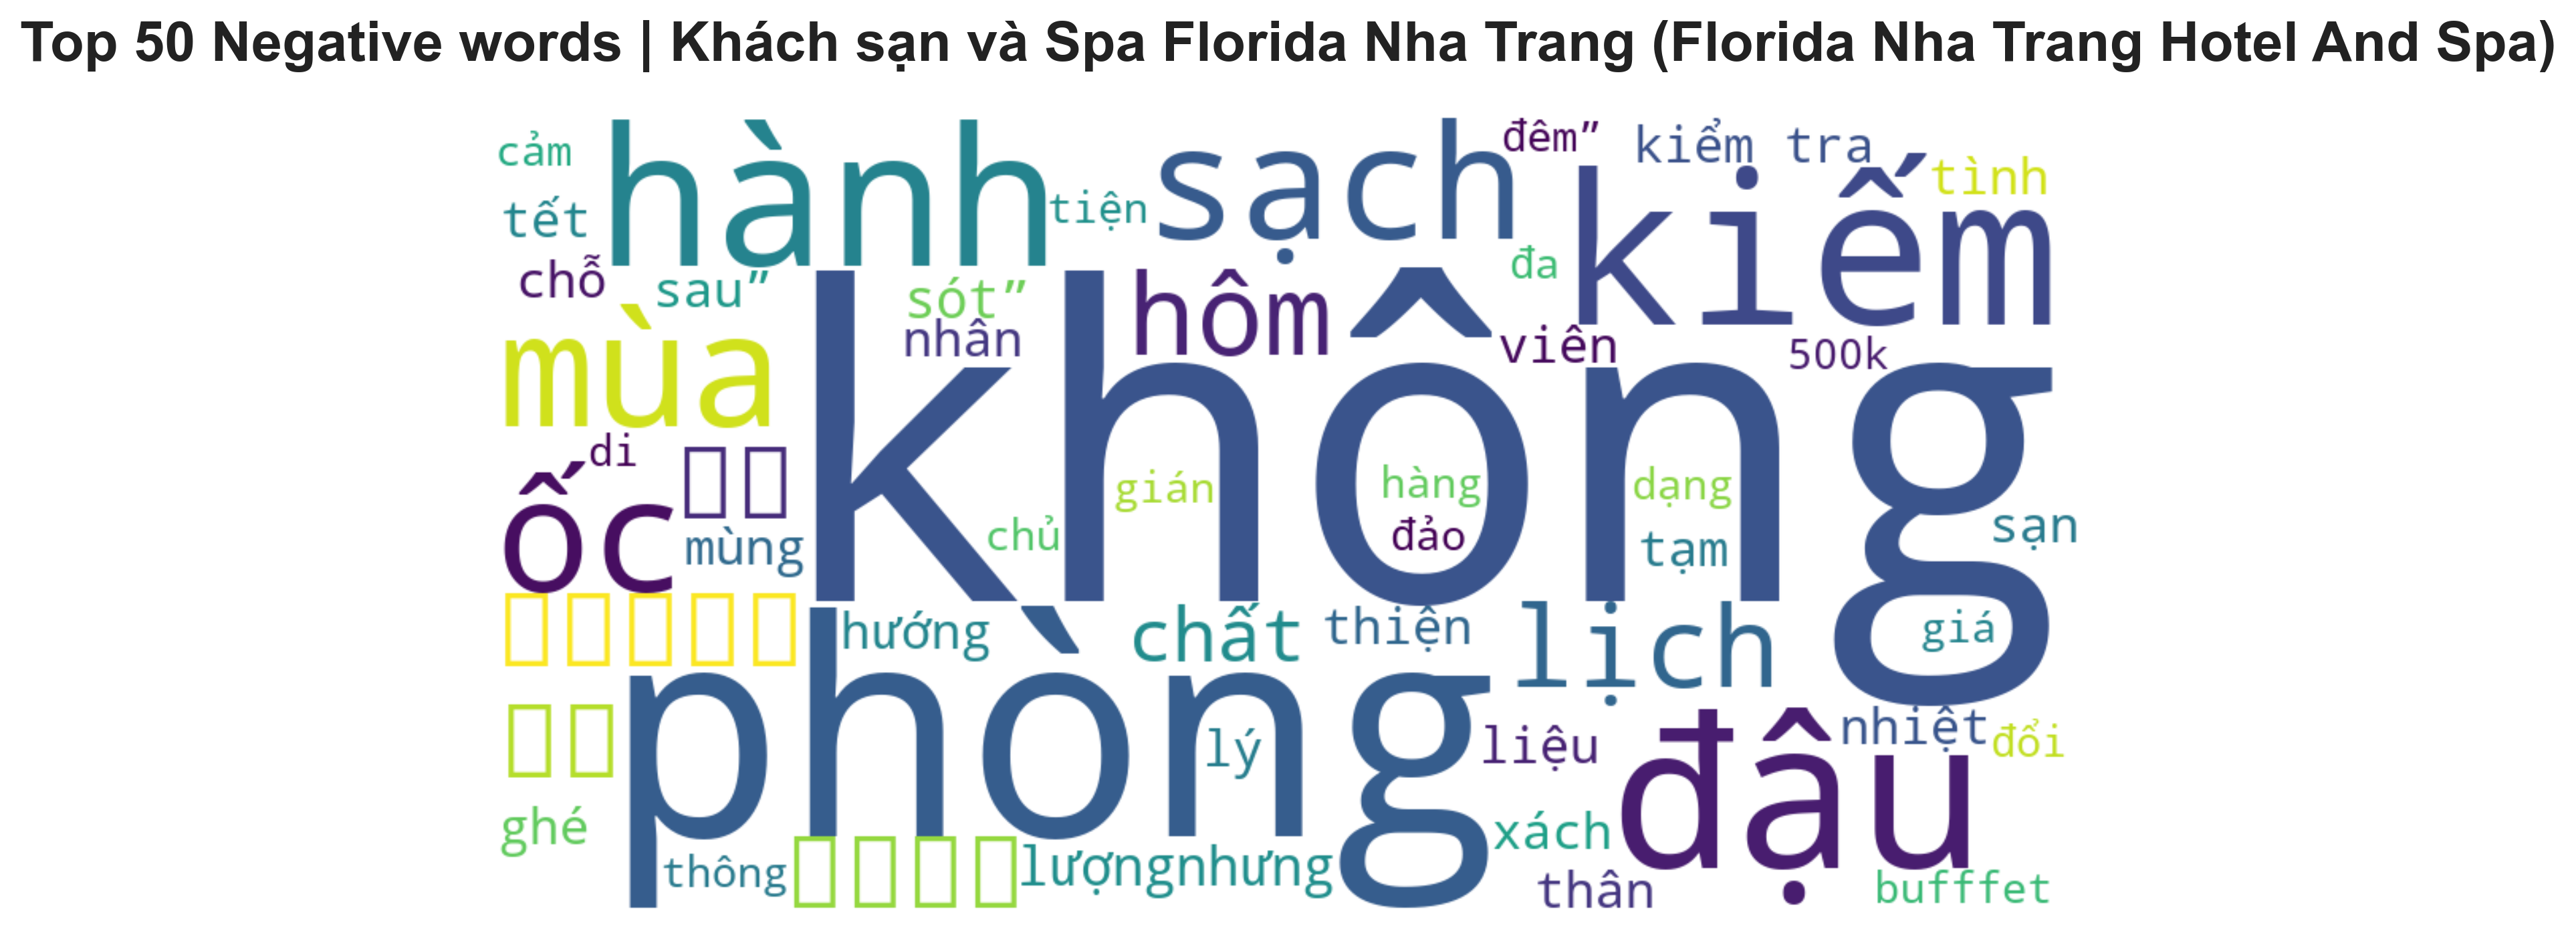

images/
------------------------------
12_insight_textmining_wordcloud_selected_hotel_pos.png


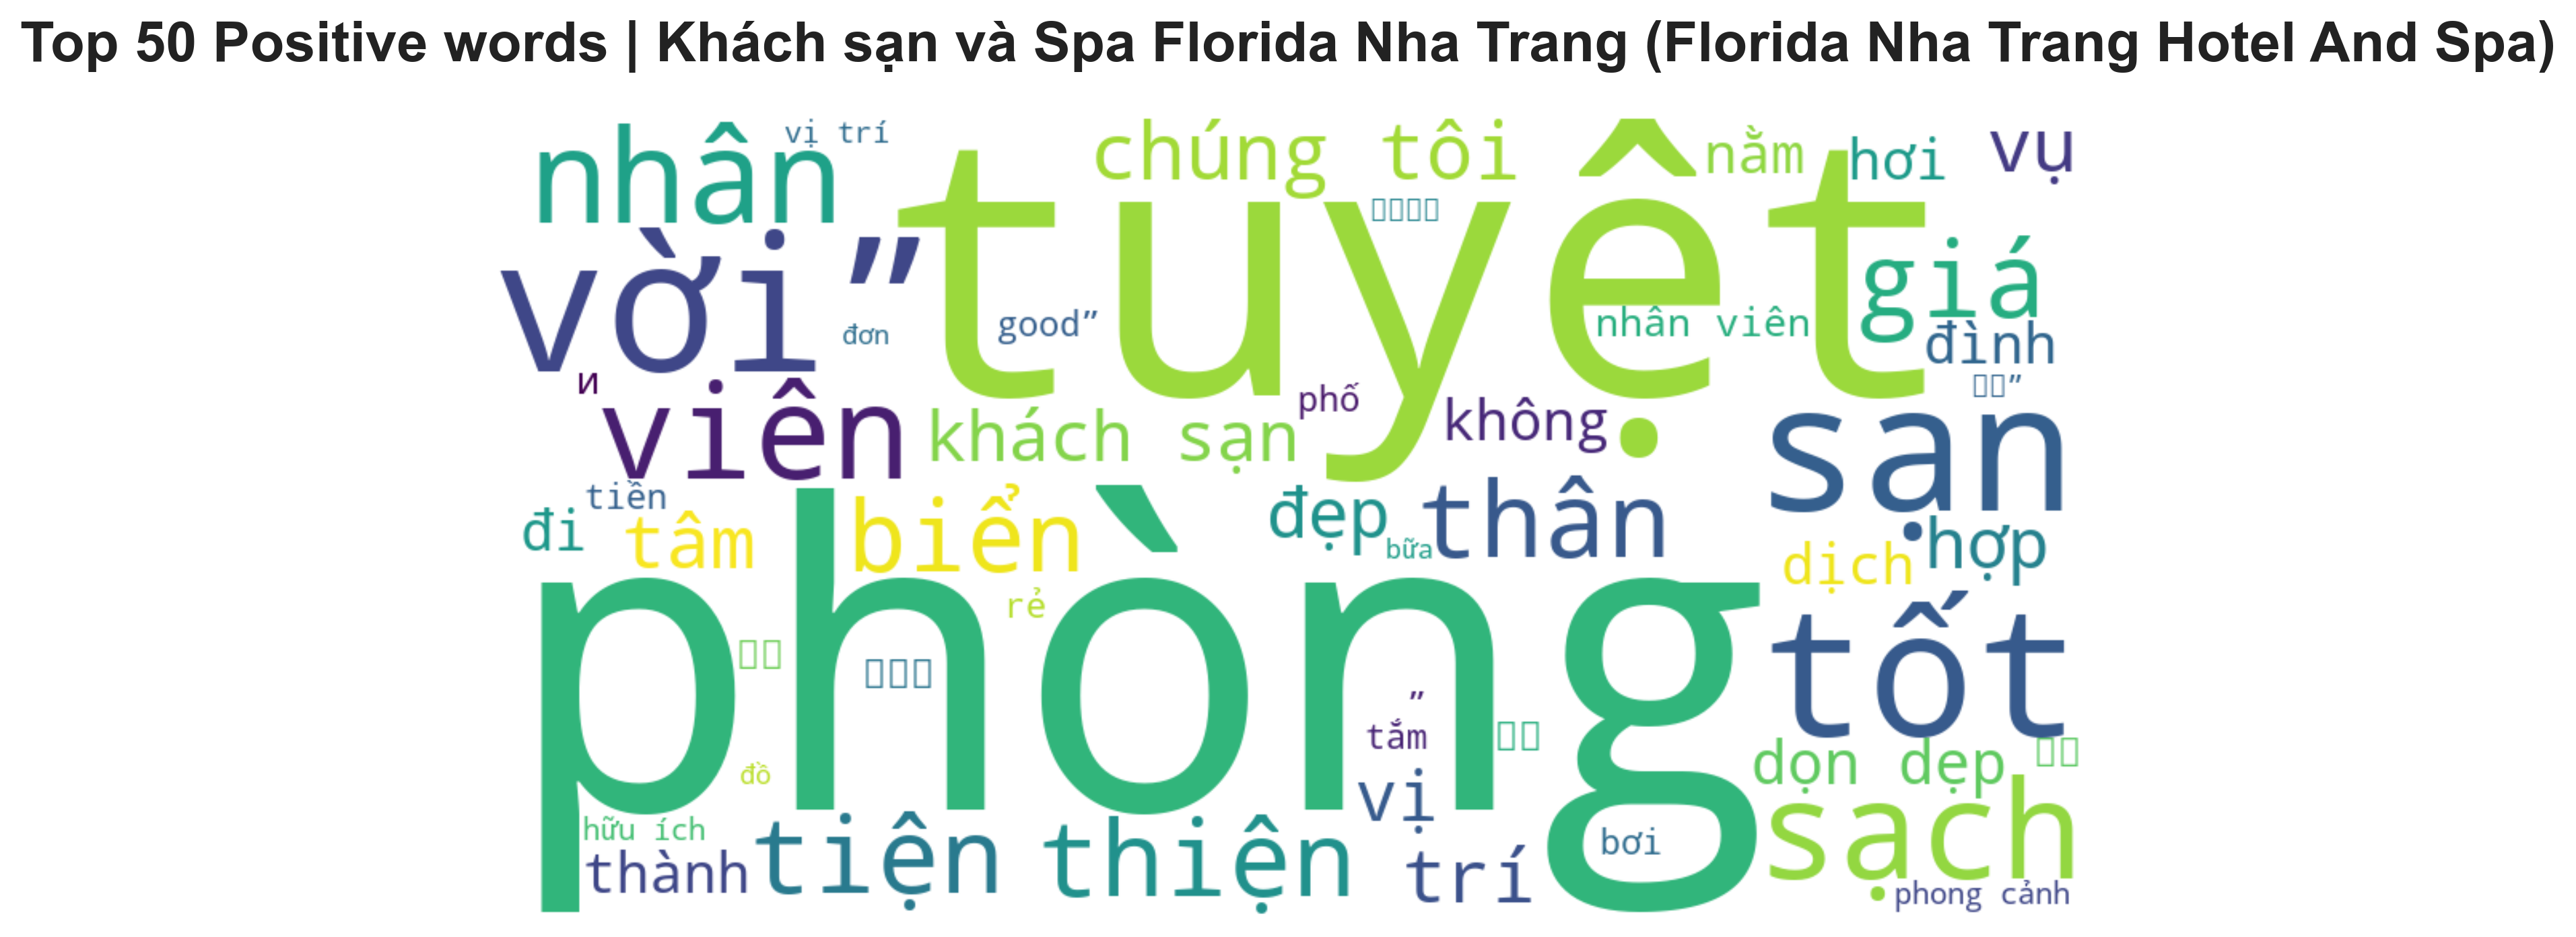

In [130]:
# Show word cloud
display(Markdown(f"### Top word | All Hotels"))
fn_chart_wordcloud(
    df=all_topword_nev,
    title=f"Top {topword_N} Negative words | All hotels",
    figsize=figsize,
    dpi=dpi,
    image_name="09_insight_textmining_wordcloud_all_nev.png",
)

fn_chart_wordcloud(
    df=all_topword_pos,
    title=f"Top {topword_N} Positive words | All hotels",
    figsize=figsize,
    dpi=dpi,
    image_name="10_insight_textmining_wordcloud_all_pos.png",
)

display(Markdown(f"### Top word | {search_hotel_name}"))
fn_chart_wordcloud(
    df=selected_hotel_topword_nev,
    title=f"Top {topword_N} Negative words | {search_hotel_name}",
    figsize=figsize,
    dpi=dpi,
    image_name="11_insight_textmining_wordcloud_selected_hotel_nev.png",
)

fn_chart_wordcloud(
    df=selected_hotel_topword_pos,
    title=f"Top {topword_N} Positive words | {search_hotel_name}",
    figsize=figsize,
    dpi=dpi,
    image_name="12_insight_textmining_wordcloud_selected_hotel_pos.png",
)

| Phương pháp                          | Ưu điểm                                                                 | Nhược điểm                                                                 | Hiệu quả / Ứng dụng chính                          |
|--------------------------------------|-------------------------------------------------------------------------|----------------------------------------------------------------------------|----------------------------------------------------|
| **Content-based (Gensim embedding)** | - Hiểu ngữ nghĩa tốt<br>- Giảm cold-start<br>- Hỗ trợ query từ khóa linh hoạt | - Phụ thuộc chất lượng embedding<br>- Khó khai thác sở thích ẩn | Phù hợp search-based recommendation, metadata rich |
| **Content-based (Cosine similarity)** | - Đơn giản, dễ implement<br>- Tính toán nhanh với tập nhỏ<br>- Minh bạch, dễ giải thích | - Không hiểu ngữ nghĩa sâu<br>- Khó xử lý synonym<br>- Pairwise cosine chậm nếu dataset lớn | Baseline, ổn cho dữ liệu nhỏ/gọn, văn bản ngắn      |
| **Collaborative Filtering (ALS)**    | - Khai thác hành vi tập thể<br>- Cho gợi ý bất ngờ (serendipity)<br>- Hiệu quả khi data lớn | - Cold-start user/item mới<br>- Cần dữ liệu hành vi dày<br>- Khó giải thích latent factor | Mạnh khi có nhiều log hành vi (booking, rating)    |
